# impprtok, adatbehivasok

In [605]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
import pandas as pd
pd.options.mode.chained_assignment = None  
import os
import glob
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, log_loss, confusion_matrix,f1_score, precision_score, recall_score
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from skopt.space import Real, Integer
from skopt import BayesSearchCV

In [606]:
with open('model_ready_dict.pickle', 'rb') as handle:
    model_ready_dict = pickle.load(handle)

for key, df in model_ready_dict.items():
    name = key.replace(" ", "_").lower()
    globals()[name] = df

In [607]:
def convert_decimal_odds_to_probabilities(dfs_dict, odds_columns):

    for key, df in dfs_dict.items():
        for col in odds_columns:
            df[f'prob_{col}'] = 1 / df[col] 
    return dfs_dict



odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
model_ready_dict = convert_decimal_odds_to_probabilities(model_ready_dict, odds)

In [608]:
for key, df in model_ready_dict.items():
    name = key.replace(" ", "_").lower()
    globals()[name] = df

In [609]:
big5 = pd.read_excel("big5_sorted_by_date.xlsx")
big5.drop(columns='Unnamed: 0', inplace=True)

def convert_odds_big5(df, odds_columns):
    for col in odds_columns:
        df[f'prob_{col}'] = 1 / df[col]
    return df

odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']
big5 = convert_odds_big5(big5, odds)

# FTR

## PL, FTR

In [339]:
def logistic_regression_tuning(df, target_col, drop_cols=[], odds=[]):
    df = df.dropna().reset_index(drop=True)

    X = df.drop(columns=[target_col] + drop_cols)
    y = df[target_col]
    
    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))
    test_n = len(df) - train_n - val_n 
    
    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 
    test_set = df.iloc[train_n + val_n:] 

    print(f"tanító halmaz dimenziók: {train_set.shape}")
    print(f"validációs halmaz dimenziók: {val_set.shape}")
        
    print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]

    X_train_odds = X_train[odds]
    X_val_odds = X_val[odds]
    X_train = X_train.drop(columns=odds)
    X_val = X_val.drop(columns=odds)
    
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    
    X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
    X_val_scaled = pd.concat([X_val_scaled, X_val_odds], axis=1)
    
    param_space = [
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l1'],
         'solver': ['liblinear', 'saga'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l2'],
         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['elasticnet'],
         'solver': ['saga'],  
         'l1_ratio': Real(0, 1),
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    ]


    tscv = TimeSeriesSplit(n_splits=5) 
    
    log_reg = LogisticRegression(random_state=1, max_iter=1000)

    bayes_search = BayesSearchCV(
        estimator=log_reg,
        search_spaces=param_space,
        n_iter=50, 
        cv=tscv, 
        scoring='f1',
        refit='f1',
        n_jobs=-1,  
        random_state=1,
        verbose=0
    )
    
    bayes_search.fit(X_train_scaled, y_train)  
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    
    y_pred = best_model.predict(X_val_scaled)
    val_set = val_set.copy()
    val_set.loc[:, 'Predicted'] = y_pred
    
    y_val_probs = best_model.predict_proba(X_val_scaled)
    val_set['P_0'] = y_val_probs[:, 0] 
    val_set['P_1'] = y_val_probs[:, 1]  
    print(classification_report(y_val, y_pred))
    
    plt.figure(figsize=(5, 3))
    cm = confusion_matrix(y_val, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("ModelL")
    plt.ylabel("Valós")
    plt.show()
    
    feature_importances = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': np.abs(best_model.coef_).flatten()
    }).sort_values(by='importance', ascending=False)
    
    top_20_features = feature_importances.head(20)['feature'].tolist()
    print(top_20_features)

    plt.figure(figsize=(6, 4))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
    plt.xlabel("Fontosság (koef.)")
    plt.ylabel("Változó")
    plt.grid(axis='x')
    plt.show()
    
    return val_set, best_params, top_20_features

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)
Accuracy: 0.6622
              precision    recall  f1-score   support

           0       0.67      0.68      0.68       190
           1       0.66      0.64      0.65       180

    accuracy                           0.66       370
   macro avg       0.66      0.66      0.66       370
weighted avg       0.66      0.66      0.66       370



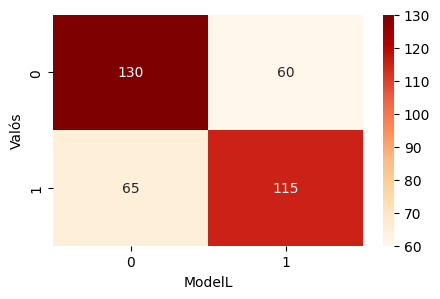

['prob_AwayW_odds_market', 'prob_O2.5_odds_market', 'prob_U2.5_odds_market', 'prob_HomeW_odds_market', 'prob_Draw_odds_market', 'away_expected_points_RA', 'away_np_xg_difference_RA', 'away_np_xg_RA', 'home_np_xg_difference_RA', 'home_expected_points_RA', 'away_xg_RA', 'away_last5_over_2_5_count', 'home_last5_wins_count', 'away_goals_for_RA', 'away_last5_losses_count', 'away_goals_against_RA', 'home_last5_over_2_5_count', 'away_cumulative_goals_diff', 'away_last5_wins_count', 'away_last5_lose_rate']


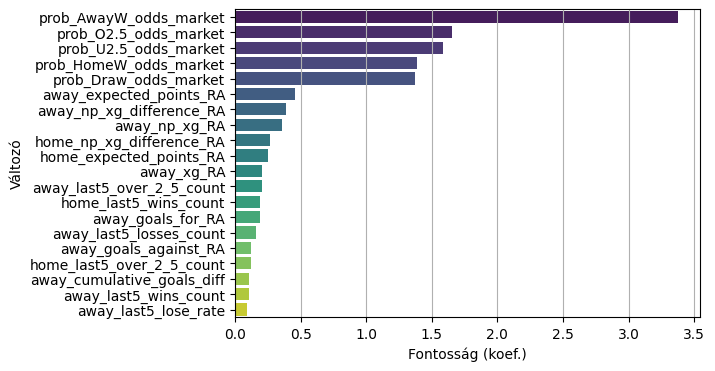

In [340]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


premier_league_tuned_home, premier_league_params_home, premier_league_features_home = logistic_regression_tuning(
    premier_league,
    target_col,
    drop,
    odds
)

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)
Accuracy: 0.6351
              precision    recall  f1-score   support

           0       0.81      0.64      0.71       265
           1       0.41      0.63      0.49       105

    accuracy                           0.64       370
   macro avg       0.61      0.63      0.60       370
weighted avg       0.70      0.64      0.65       370



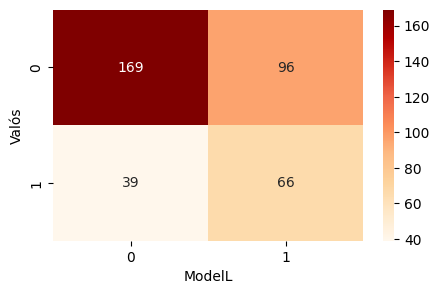

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'prob_Draw_odds_market', 'away_np_xg_difference_RA', 'home_expected_points_RA', 'home_np_xg_difference_RA', 'away_expected_points_RA', 'prob_O2.5_odds_market', 'home_last5_under_2_5_count', 'away_last5_losses_count', 'away_last5_under_2_5_count', 'home_last5_over_2_5_count', 'away_shots_RA', 'prob_U2.5_odds_market', 'away_cumulative_goals_diff', 'home_last5_wins_count', 'home_last5_losses_count', 'away_halftime_goals_RA', 'away_goals_against_RA', 'away_np_xg_RA']


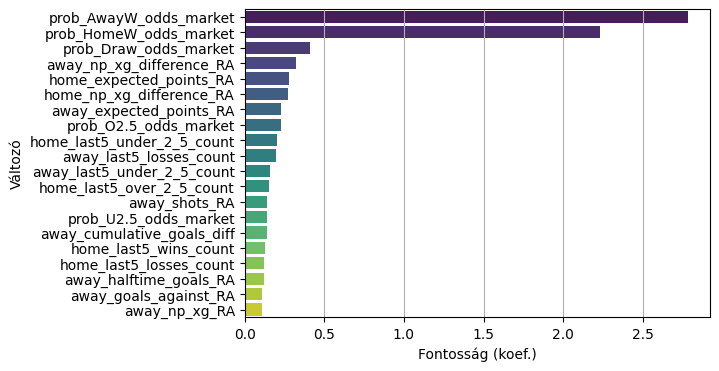

In [341]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

premier_league_tuned_away, premier_league_params_away,premier_league_features_away = logistic_regression_tuning(
    premier_league,
    target_col,
    drop,
    odds
)

### tuned model on train+validation

In [622]:
def logreg_validation(train_data, target_col, drop_cols=[], odds=[], best_params={}):
    """
    Ez a függvény csak a modell tanítását és a scaler létrehozását végzi
    a már előre szétosztott train adatokon.
    """
    # Csak a train adatokon dolgozik
    train_data = train_data.dropna().reset_index(drop=True)

    X_train = train_data.drop(columns=[target_col] + drop_cols)
    y_train = train_data[target_col]

    # Kimentjük az odds oszlopokat
    X_train_odds = X_train[odds].copy()
    X_train_no_odds = X_train.drop(columns=odds)
    
    # Scaler illesztése CSAK a train adatokon
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_no_odds)
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train_no_odds.columns)
    
    # Egyesítjük a skálázott és nem skálázott adatokat
    X_train_final = pd.concat([X_train_scaled.reset_index(drop=True), 
                              X_train_odds.reset_index(drop=True)], axis=1)
    
    # Modell illesztése
    logreg = LogisticRegression(
        C=best_params.get('C', 1.0),
        penalty=best_params.get('penalty', 'l2'),
        solver=best_params.get('solver', 'liblinear'),
        class_weight=best_params.get('class_weight', None),
        random_state=best_params.get('random_state', 1),
        max_iter=1000,
        l1_ratio=best_params.get('l1_ratio', 0.5) if best_params.get('penalty') == 'elasticnet' else None  
    )
    
    logreg.fit(X_train_final, y_train)
    
    return logreg, scaler

In [432]:
def logreg_final(df, drop_cols_home=[], drop_cols_away=[], odds=[], best_params_home={}, best_params_away={}):
    """
    Fő függvény: adatokat feloszt, modelleket tanít, kiértékel
    """
    df = df.dropna().reset_index(drop=True)

    # Adatok felosztása train, validation, és test halmazokra
    train_n = int(round(len(df) * 0.8, 0))
    val_n = int(round(len(df) * 0.1, 0))

    train_set = df.iloc[:train_n].copy()        
    val_set = df.iloc[train_n:train_n + val_n].copy() 
    test_set = df.iloc[train_n + val_n:].copy()

    # Modell tanítása CSAK a train adatokon
    lr_home, scaler_home = logreg_validation(
        train_set, "target_home_win", drop_cols_home, odds, best_params_home
    )

    lr_away, scaler_away = logreg_validation(
        train_set, "target_away_win", drop_cols_away, odds, best_params_away
    )

    # Validation adatok előkészítése
    X_val_home = val_set.drop(columns=drop_cols_home + ["target_home_win"])
    X_val_away = val_set.drop(columns=drop_cols_away + ["target_away_win"])

    X_val_home_odds = X_val_home[odds].copy()
    X_val_home_no_odds = X_val_home.drop(columns=odds)

    X_val_away_odds = X_val_away[odds].copy()
    X_val_away_no_odds = X_val_away.drop(columns=odds)

    # Validation adatok transzformálása a train adatokon tanult scaler-rel
    X_val_home_scaled = scaler_home.transform(X_val_home_no_odds)
    X_val_away_scaled = scaler_away.transform(X_val_away_no_odds)

    X_val_home_scaled = pd.DataFrame(X_val_home_scaled, columns=X_val_home_no_odds.columns)
    X_val_away_scaled = pd.DataFrame(X_val_away_scaled, columns=X_val_away_no_odds.columns)

    X_val_home_scaled = pd.concat([X_val_home_scaled.reset_index(drop=True), 
                                   X_val_home_odds.reset_index(drop=True)], axis=1)
    
    X_val_away_scaled = pd.concat([X_val_away_scaled.reset_index(drop=True), 
                                   X_val_away_odds.reset_index(drop=True)], axis=1)

    # Predikciók a validation adatokon
    prob_home_win_val = lr_home.predict_proba(X_val_home_scaled)[:, 1]
    prob_away_win_val = lr_away.predict_proba(X_val_away_scaled)[:, 1]

    prob_home_win_val = np.maximum(prob_home_win_val, 0)
    prob_away_win_val = np.maximum(prob_away_win_val, 0)
    prob_draw_val = np.maximum(1 - (prob_home_win_val + prob_away_win_val), 0)

    total_prob_val = prob_home_win_val + prob_away_win_val + prob_draw_val
    prob_home_win_val /= total_prob_val
    prob_away_win_val /= total_prob_val
    prob_draw_val /= total_prob_val

    # Legjobb küszöbérték keresése a validation adatokon
    best_f1_macro = 0
    best_threshold = 0.15
    thresholds = np.arange(0.01, 0.30, 0.01)

    true_outcomes_val = []
    for i in range(len(val_set)):
        if val_set.iloc[i]["target_home_win"] == 1:
            true_outcomes_val.append("Home Win")
        elif val_set.iloc[i]["target_away_win"] == 1:
            true_outcomes_val.append("Away Win")
        else:
            true_outcomes_val.append("Draw")

    for threshold in thresholds:
        predictions = []
        for i in range(len(val_set)):
            home_prob = prob_home_win_val[i]
            away_prob = prob_away_win_val[i]

            if abs(home_prob - away_prob) < threshold:
                predictions.append("Draw")
            elif home_prob > away_prob:
                predictions.append("Home Win")
            else:
                predictions.append("Away Win")

        f1_macro = f1_score(true_outcomes_val, predictions, average='macro')

        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            best_threshold = threshold

    # Test adatok előkészítése
    X_test_home = test_set.drop(columns=["target_home_win"] + drop_cols_home)
    X_test_away = test_set.drop(columns=["target_away_win"] + drop_cols_away)

    X_test_home_odds = X_test_home[odds].copy()
    X_test_home_no_odds = X_test_home.drop(columns=odds)

    X_test_away_odds = X_test_away[odds].copy()
    X_test_away_no_odds = X_test_away.drop(columns=odds)

    # Test adatok transzformálása a train adatokon tanult scaler-rel
    X_test_home_scaled = scaler_home.transform(X_test_home_no_odds)
    X_test_away_scaled = scaler_away.transform(X_test_away_no_odds)

    X_test_home_scaled = pd.DataFrame(X_test_home_scaled, columns=X_test_home_no_odds.columns)
    X_test_away_scaled = pd.DataFrame(X_test_away_scaled, columns=X_test_away_no_odds.columns)

    X_test_home_scaled = pd.concat([X_test_home_scaled.reset_index(drop=True), 
                                    X_test_home_odds.reset_index(drop=True)], axis=1)
    
    X_test_away_scaled = pd.concat([X_test_away_scaled.reset_index(drop=True), 
                                    X_test_away_odds.reset_index(drop=True)], axis=1)

    # Predikciók a test adatokon
    model_home_preds = lr_home.predict(X_test_home_scaled)
    model_away_preds = lr_away.predict(X_test_away_scaled)

    prob_home_win_test = lr_home.predict_proba(X_test_home_scaled)[:, 1]
    prob_away_win_test = lr_away.predict_proba(X_test_away_scaled)[:, 1]

    prob_home_win_test = np.maximum(prob_home_win_test, 0)
    prob_away_win_test = np.maximum(prob_away_win_test, 0)
    prob_draw_test = np.maximum(1 - (prob_home_win_test + prob_away_win_test), 0)

    total_prob_test = prob_home_win_test + prob_away_win_test + prob_draw_test
    prob_home_win_test /= total_prob_test
    prob_away_win_test /= total_prob_test
    prob_draw_test /= total_prob_test

    # Eredmények mentése az eredeti DataFrame-be
    test_indices = test_set.index
    
    df.loc[test_indices, "model_home"] = model_home_preds
    df.loc[test_indices, "model_away"] = model_away_preds
    df.loc[test_indices, "prob_home_win"] = prob_home_win_test
    df.loc[test_indices, "prob_away_win"] = prob_away_win_test
    df.loc[test_indices, "prob_draw"] = prob_draw_test

    # Szavazási függvények
    def voting_hard(row):
        if row["model_home"] == 1 and row["model_away"] == 0:
            return "Home Win"
        elif row["model_away"] == 1 and row["model_home"] == 0:
            return "Away Win"
        elif row["model_home"] == 0 and row["model_away"] == 0:
            return "Draw"
        elif row["model_home"] == 1 and row["model_away"] == 1:
            return "Home Win"
        else:
            return "-"

    def voting_soft(row):
        prob_home_win = row['prob_home_win']
        prob_away_win = row['prob_away_win']

        if abs(prob_home_win - prob_away_win) < best_threshold:
            return "Draw"
        elif prob_home_win > prob_away_win:
            return "Home Win"
        elif prob_home_win < prob_away_win:
            return "Away Win"
        else:
            return "-"

    # Csak a test adatokon alkalmazunk szavazást
    df.loc[test_indices, "test_pred_hard"] = df.loc[test_indices].apply(voting_hard, axis=1)
    df.loc[test_indices, "test_pred_soft"] = df.loc[test_indices].apply(voting_soft, axis=1)

    # Konfúziós mátrixok
    plt.figure(figsize=(5, 4))
    cm_home = confusion_matrix(test_set["target_home_win"], model_home_preds)
    sns.heatmap(cm_home, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem hazai Gy', 'Hazai Gy'], yticklabels=['Nem hazai Gy', 'Hazai Gy'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Hazai modell")
    plt.show()

    plt.figure(figsize=(5, 4))
    cm_away = confusion_matrix(test_set["target_away_win"], model_away_preds)
    sns.heatmap(cm_away, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem vendég Gy', 'Vendég Gy'], yticklabels=['Nem vendég Gy', 'Vendég Gy'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Vendég modell")
    plt.show()

    print(f"Legjobb küszöbérték a validációs halmazon: {best_threshold:.2f}")

    return df, lr_home, lr_away

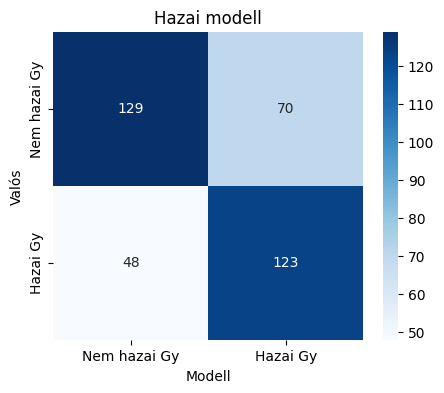

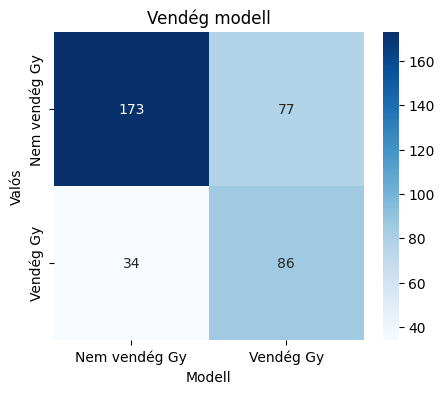

Legjobb küszöbérték a validációs halmazon: 0.22


In [433]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


test_predictions_pl, logreg_home_pl, logreg_away_pl = logreg_final(premier_league,
                                                                   drop_cols_home, drop_cols_away,
                                                                   odds,
                                                                   premier_league_params_home,premier_league_params_away)

In [434]:
def process_predictions(df):
    df = df.dropna()

    df.loc[:, 'FTR'] = 0  
    df.loc[df['target_home_win'] == 1, 'FTR'] = 1  
    df.loc[df['target_away_win'] == 1, 'FTR'] = 2  

    df.loc[:, 'test_pred_numeric_hard'] = 0
    df.loc[df['test_pred_hard'] == "Home Win", 'test_pred_numeric_hard'] = 1  
    df.loc[df['test_pred_hard'] == "Away Win", 'test_pred_numeric_hard'] = 2 
    df.loc[df['test_pred_hard'] == "Draw", 'test_pred_numeric_hard'] = 0  

    df.loc[:, 'test_pred_numeric_soft'] = 0
    df.loc[df['test_pred_soft'] == "Home Win", 'test_pred_numeric_soft'] = 1  
    df.loc[df['test_pred_soft'] == "Away Win", 'test_pred_numeric_soft'] = 2 
    df.loc[df['test_pred_soft'] == "Draw", 'test_pred_numeric_soft'] = 0 

    selected_columns = [
        'target_home_win', 'target_away_win', 'target_draw', 'FTR',
        'test_pred_hard', 'test_pred_soft',
        'test_pred_numeric_hard', 'test_pred_numeric_soft'
    ]
    result_df = df[selected_columns]

    pred_odds = df[['FTR', 'test_pred_numeric_hard', 'test_pred_numeric_soft',
                    'HomeW_odds_market',
                    'AwayW_odds_market',
                    'Draw_odds_market']]


    return pred_odds

pred_odds_pl = process_predictions(test_predictions_pl)

Summary for HARD VOTING model


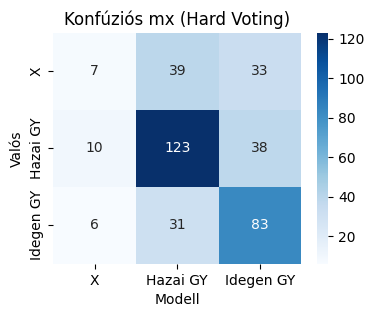

              precision    recall  f1-score   support

           0     0.3043    0.0886    0.1373        79
           1     0.6373    0.7193    0.6758       171
           2     0.5390    0.6917    0.6058       120

    accuracy                         0.5757       370
   macro avg     0.4935    0.4999    0.4730       370
weighted avg     0.5343    0.5757    0.5381       370


Summary for SOFT VOTING model


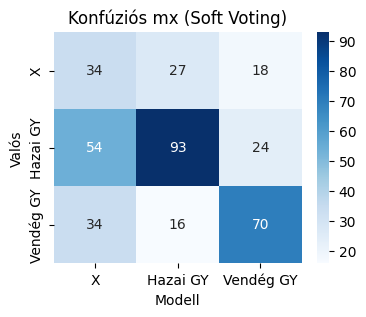

              precision    recall  f1-score   support

           0     0.2787    0.4304    0.3383        79
           1     0.6838    0.5439    0.6059       171
           2     0.6250    0.5833    0.6034       120

    accuracy                         0.5324       370
   macro avg     0.5292    0.5192    0.5159       370
weighted avg     0.5782    0.5324    0.5480       370



In [435]:
def evaluation(pred_odds):
    print("Summary for HARD VOTING model")
    cm_hard = confusion_matrix(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_hard, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['X', 'Hazai GY', 'Idegen GY'], 
                yticklabels=['X', 'Hazai GY', 'Idegen GY'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Konfúziós mx (Hard Voting)")
    plt.show()
    accuracy_hard = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"])
    report_hard = classification_report(pred_odds["FTR"], pred_odds["test_pred_numeric_hard"], digits=4)
    print(report_hard)

    print("\nSummary for SOFT VOTING model")
    cm_soft = confusion_matrix(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm_soft, annot=True, fmt="d", cmap="Blues", 
                xticklabels=['X', 'Hazai GY', 'Vendég GY'], 
                yticklabels=['X', 'Hazai GY', 'Vendég GY'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Konfúziós mx (Soft Voting)")
    plt.show()
    accuracy_soft = accuracy_score(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"])
    report_soft = classification_report(pred_odds["FTR"], pred_odds["test_pred_numeric_soft"], digits=4)
    print(report_soft)

evaluation(pred_odds_pl)

In [436]:
def betting_logreg(df, stake=500):

    """
    Ezzel a fügvénnyel számolom ki a befektetés kamatát.
    Ezt külön megteszem a hard és a soft votingra.
    A tét fix, ezen lehet javítani valamilyen közgazdaságtanból származtatott optimalizálással.
    A profit definíciója a következő:
    
        (tét * historikus szorzó) - tét
    Felszummázzuk, majd a százalékos ROI-t a következőképpen kapjuk meg:
    
        (egyes meccsek profitjai felszummázva / összes elköltött pénz) * 100
    """
    df = df.copy() 

    df['Profit_hard'] = 0
    df['Profit_hard'] = df.apply(
        lambda row: (stake * row['HomeW_odds_market'] - stake) if row['test_pred_numeric_hard'] == 1 and row['FTR'] == 1 else
                     (stake * row['AwayW_odds_market'] - stake) if row['test_pred_numeric_hard'] == 2 and row['FTR'] == 2 else
                     (stake * row['Draw_odds_market'] - stake) if row['test_pred_numeric_hard'] == 0 and row['FTR'] == 0 else
                     -stake, axis=1
    )

    total_profit_hard = df['Profit_hard'].sum()
    total_bets = len(df)

    roi_hard = (total_profit_hard / (total_bets * stake)) * 100
    
    print(f"ROI hard : {roi_hard:.2f}%")

    df['Profit_soft'] = 0
    df['Profit_soft'] = df.apply(
        lambda row: (stake * row['HomeW_odds_market'] - stake) if row['test_pred_numeric_soft'] == 1 and row['FTR'] == 1 else
                     (stake * row['AwayW_odds_market'] - stake) if row['test_pred_numeric_soft'] == 2 and row['FTR'] == 2 else
                     (stake * row['Draw_odds_market'] - stake) if row['test_pred_numeric_soft'] == 0 and row['FTR'] == 0 else
                     -stake, axis=1
    )

    total_profit_soft = df['Profit_soft'].sum()
    total_bets = len(df)

    roi_soft = (total_profit_soft / (total_bets * stake)) * 100

    print(f"ROI soft : {roi_soft:.2f}%")

    df_profit_hard = df[df['FTR'] == df['test_pred_numeric_hard']]
    df_loss_hard = df[df['FTR'] != df['test_pred_numeric_hard']]
    
    df_profit_soft = df[df['FTR'] == df['test_pred_numeric_soft']]
    df_loss_soft = df[df['FTR'] != df['test_pred_numeric_soft']]

    return roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,df

roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(pred_odds_pl,
                                                                                                                  stake=1)

ROI hard : 2.10%
ROI soft : 3.17%


Válassz(1 vagy 2):
1 - Hard votingos ROI
2 - Soft votingos ROI
 2


>0% profit 22 fordulóban


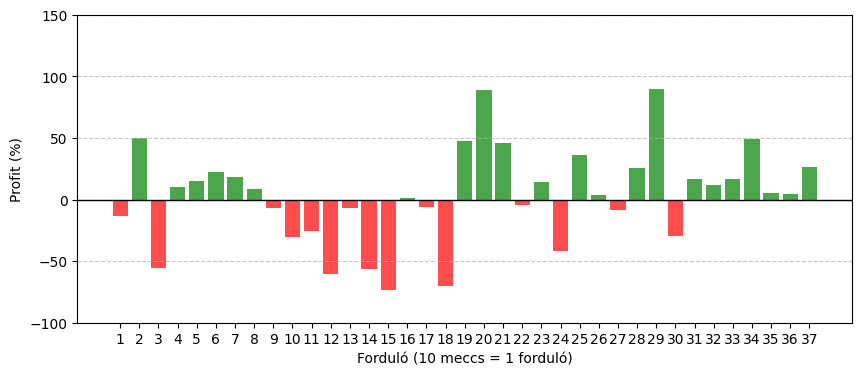

In [439]:
def ROI_sim_per_round(df, stake=1, round_size=int):
    
    df = df.copy().reset_index(drop=True)
    
    valasztas = input("Válassz(1 vagy 2):\n1 - Hard votingos ROI\n2 - Soft votingos ROI\n")
    if valasztas == "1":
        profit_column = "Profit_hard"
    elif valasztas == "2":
        profit_column = "Profit_soft"
    else:
        print("Csak 1 vagy 2 lehet az input")
        return
    
    df['Round'] = (df.index // round_size) + 1  
    roi_per_round = df.groupby('Round').agg({profit_column: 'sum'})
    roi_per_round['Total_Bets'] = df.groupby('Round').size()
    roi_per_round['ROI'] = (roi_per_round[profit_column] / (roi_per_round['Total_Bets'] * stake)) * 100

        
    positive_rounds = (roi_per_round['ROI'] > 0).sum()
    
    print(f'>0% profit {positive_rounds} fordulóban')

    colors = ['red' if roi < 0 else 'green' for roi in roi_per_round['ROI']]
    plt.figure(figsize=(10, 4))
    plt.bar(roi_per_round.index, roi_per_round['ROI'], color=colors, alpha=0.7)
    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Profit (%)')
    # plt.title(f'Fogadási szimuláció, 2023-2024-es teszt szezon')
    plt.axhline(0, color='black', linewidth=1)
    plt.xticks(roi_per_round.index)  
    plt.ylim(-100, 150)  # Set y-axis limit
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(r'abrak/PL_soft_ROI.jpg', format='jpg', dpi=300)
    # plt.savefig(r'abrak/PL_hard_ROI_logreg.jpg', format='jpg', dpi=300)
    plt.show()

ROI_sim_per_round(pred_odds_soft, round_size=10)

## Bundesliga, FTR

tanító halmaz dimenziók: (2376, 67)
validációs halmaz dimenziók: (297, 67)

tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)
Accuracy: 0.6296
              precision    recall  f1-score   support

           0       0.65      0.63      0.64       156
           1       0.61      0.62      0.62       141

    accuracy                           0.63       297
   macro avg       0.63      0.63      0.63       297
weighted avg       0.63      0.63      0.63       297



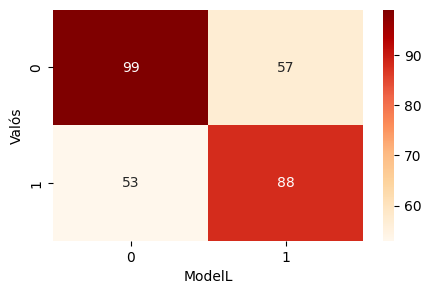

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'home_deep_completions_RA', 'away_cumulative_goals_diff', 'GD_diff', 'away_np_xg_difference_RA', 'home_np_xg_difference_RA', 'away_shots_RA', 'home_halftime_goals_RA', 'draw_rate_diff', 'away_ppda_RA', 'away_halftime_goals_RA', 'home_points_cumulative', 'home_last5_under_2_5_count', 'home_shots_OT_RA', 'home_shots_RA', 'home_ppda_RA', 'home_goals_against_RA', 'away_deep_completions_RA', 'home_np_xg_RA']


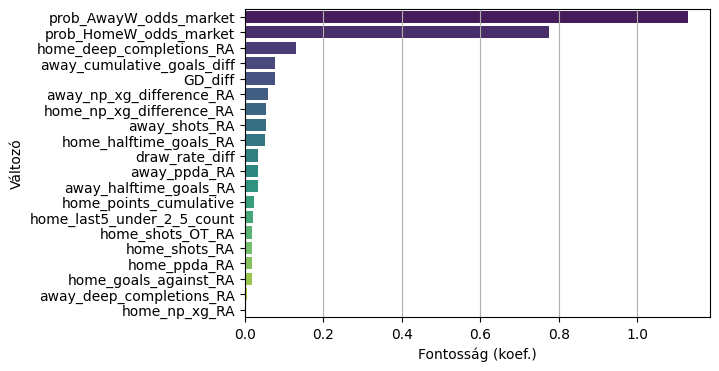

In [441]:
# target_col = 'target_home_win'
# drop = ['target_o2.5', 'target_away_win', 'target_draw']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

bundesliga_tuned_home, bundesliga_params_home, bundesliga_features_away = logistic_regression_tuning(
    bundesliga,
    target_col,
    drop,
    odds)

tanító halmaz dimenziók: (2376, 67)
validációs halmaz dimenziók: (297, 67)

tanító halmaz indexek: (i: 1 -> 2376)
validációs halmaz:  (i: 2377 -> 2673)
Accuracy: 0.6330
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       214
           1       0.40      0.59      0.47        83

    accuracy                           0.63       297
   macro avg       0.60      0.62      0.60       297
weighted avg       0.69      0.63      0.65       297



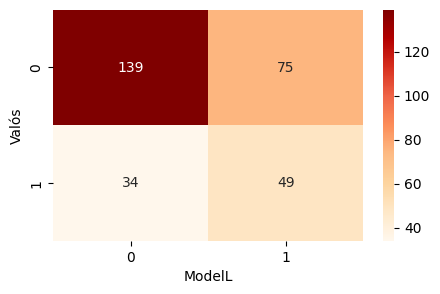

['GD_diff', 'prob_HomeW_odds_market', 'away_np_xg_difference_RA', 'away_deep_completions_RA', 'home_shots_OT_RA', 'home_deep_completions_RA', 'home_np_xg_difference_RA', 'home_expected_points_RA', 'home_clinicality', 'home_ppda_RA', 'away_cumulative_goals_diff', 'home_xg_RA', 'home_np_xg_RA', 'home_cumulative_goals_diff', 'home_last5_wins_count', 'home_last5_losses_count', 'home_last5_draws_count', 'home_last5_over_2_5_count', 'home_last5_under_2_5_count', 'home_last5_win_rate']


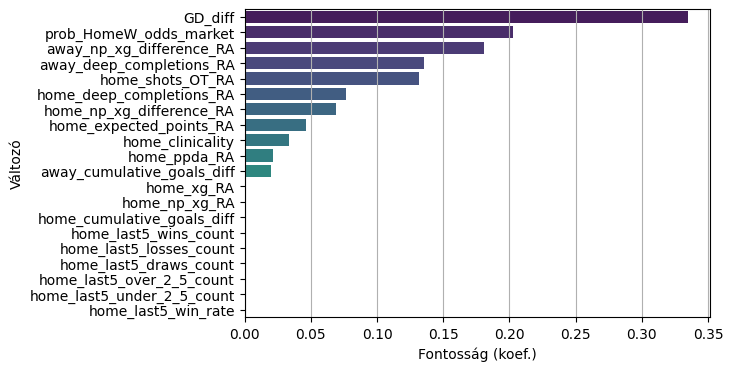

In [442]:
# target_col = 'target_away_win'
# drop = ['target_o2.5', 'target_home_win', 'target_draw']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

bundesliga_tuned_away, bundesliga_params_away, bundesliga_features_away = logistic_regression_tuning(bundesliga,
                                                                           target_col,
                                                                           drop,
                                                                           odds)

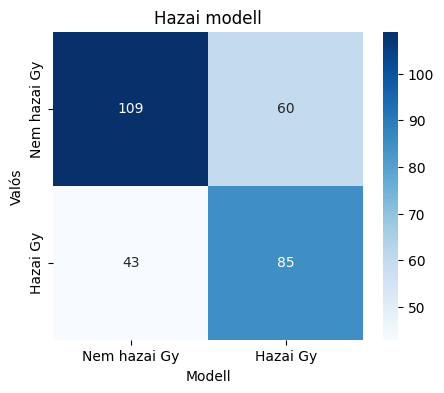

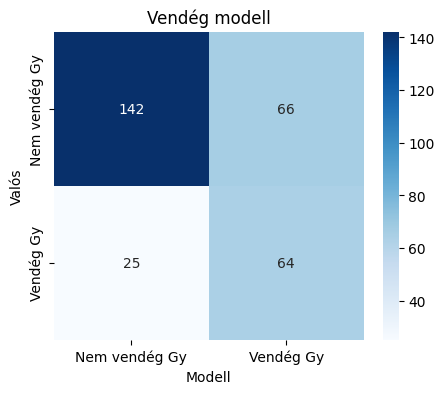

Legjobb küszöbérték a validációs halmazon: 0.18


In [443]:
# drop_cols_home =['target_away_win', 'target_draw','target_o2.5']

drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


test_predictions_bundesliga, logreg_home_bundesliga, logreg_away_bundesliga = logreg_final(
    bundesliga, drop_cols_home, drop_cols_away, odds, bundesliga_params_home, bundesliga_params_away
)

Summary for HARD VOTING model


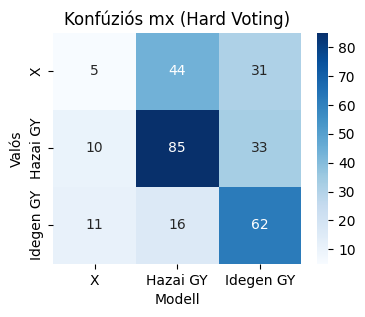

              precision    recall  f1-score   support

           0     0.1923    0.0625    0.0943        80
           1     0.5862    0.6641    0.6227       128
           2     0.4921    0.6966    0.5767        89

    accuracy                         0.5118       297
   macro avg     0.4235    0.4744    0.4313       297
weighted avg     0.4519    0.5118    0.4666       297


Summary for SOFT VOTING model


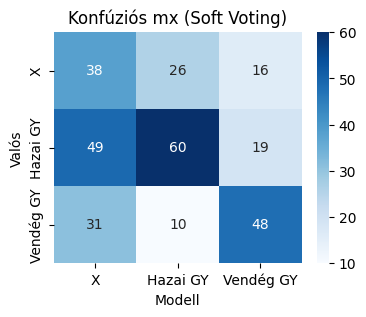

              precision    recall  f1-score   support

           0     0.3220    0.4750    0.3838        80
           1     0.6250    0.4688    0.5357       128
           2     0.5783    0.5393    0.5581        89

    accuracy                         0.4916       297
   macro avg     0.5084    0.4944    0.4926       297
weighted avg     0.5294    0.4916    0.5015       297



In [444]:
pred_odds_bundesliga = process_predictions(test_predictions_bundesliga)
evaluation(pred_odds_bundesliga)

In [445]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(
    pred_odds_bundesliga,
    stake=500)

ROI hard : -5.38%
ROI soft : 5.24%


## Serie A, FTR

tanító halmaz dimenziók: (2862, 67)
validációs halmaz dimenziók: (358, 67)

tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3220)
Accuracy: 0.6257
              precision    recall  f1-score   support

           0       0.69      0.62      0.66       205
           1       0.55      0.63      0.59       153

    accuracy                           0.63       358
   macro avg       0.62      0.63      0.62       358
weighted avg       0.63      0.63      0.63       358



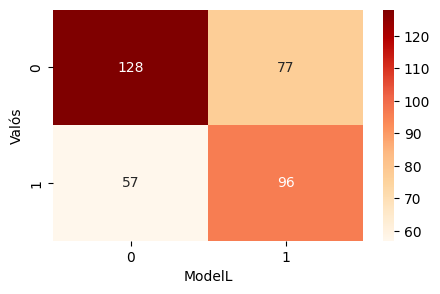

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'home_np_xg_RA', 'cumulative_points_diff', 'home_last5_draws_count', 'home_xg_RA', 'home_goals_against_RA', 'away_cumulative_goals_diff', 'home_np_xg_difference_RA', 'home_shots_OT_RA', 'away_np_xg_difference_RA', 'home_last5_draw_rate', 'home_last5_lose_rate', 'away_last5_over_2_5_count', 'away_points_cumulative', 'home_deep_completions_RA', 'away_ppda_RA', 'away_last5_wins_count', 'home_clinicality', 'home_last5_under_2_5_count']


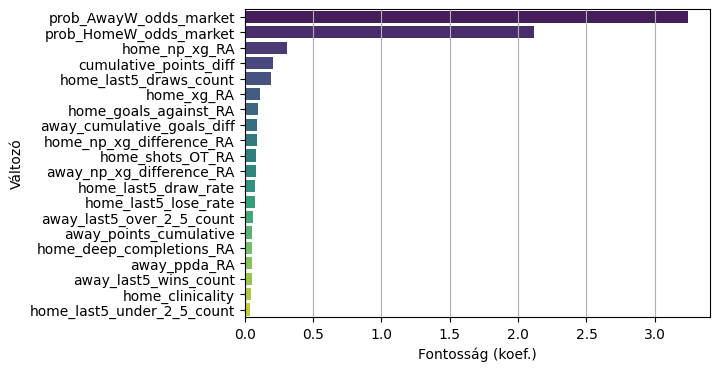

In [446]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

serie_a_tuned_home, serie_a_params_home, serie_a_features_home = logistic_regression_tuning(serie_a, target_col, drop, odds)

tanító halmaz dimenziók: (2862, 67)
validációs halmaz dimenziók: (358, 67)

tanító halmaz indexek: (i: 1 -> 2862)
validációs halmaz:  (i: 2863 -> 3220)
Accuracy: 0.6508
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       245
           1       0.46      0.63      0.53       113

    accuracy                           0.65       358
   macro avg       0.63      0.64      0.63       358
weighted avg       0.69      0.65      0.66       358



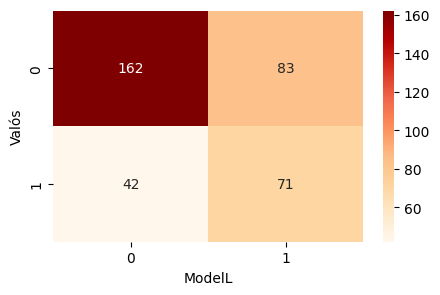

['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'home_np_xg_RA', 'home_shots_OT_RA', 'home_halftime_goals_RA', 'away_last5_over_2_5_count', 'home_expected_points_RA', 'away_cumulative_goals_diff', 'away_np_xg_difference_RA', 'away_last5_wins_count', 'home_last5_wins_count', 'home_ppda_RA', 'home_np_xg_difference_RA', 'away_goals_for_RA', 'away_total_goals_RA', 'away_last5_under_2_5_count', 'home_shots_RA', 'home_last5_over_2_5_count', 'away_shots_OT_RA', 'home_deep_completions_RA']


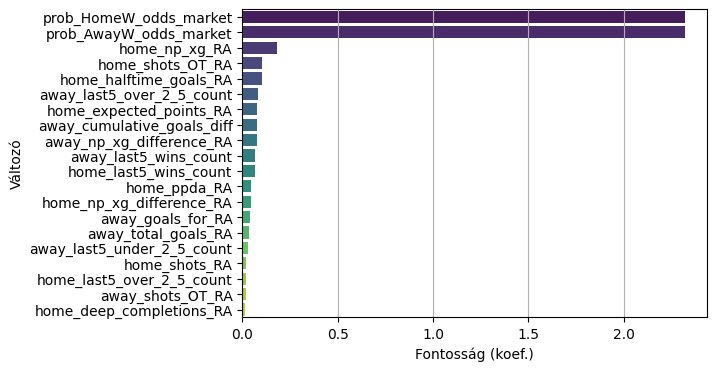

In [447]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

serie_a_tuned_away, serie_a_params_away, serie_a_features_away = logistic_regression_tuning(serie_a, target_col, drop, odds)

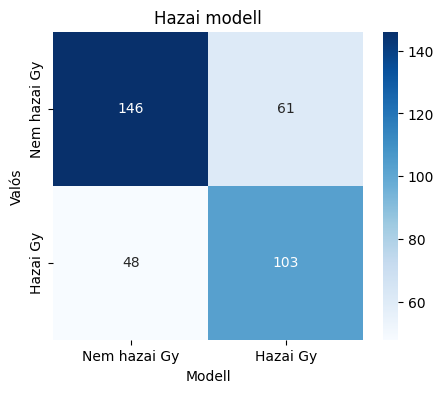

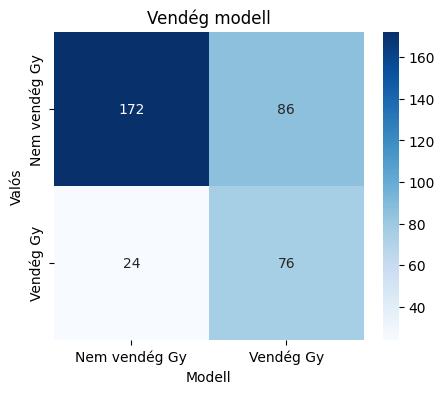

Legjobb küszöbérték a validációs halmazon: 0.19


In [448]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_serie_a, logreg_home_serie_a, logreg_away_serie_a = logreg_final(
    serie_a, drop_cols_home, drop_cols_away, odds, serie_a_params_home, serie_a_params_away
)


Summary for HARD VOTING model


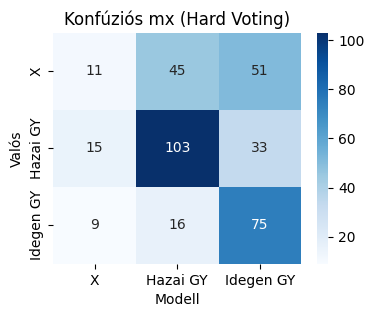

              precision    recall  f1-score   support

           0     0.3143    0.1028    0.1549       107
           1     0.6280    0.6821    0.6540       151
           2     0.4717    0.7500    0.5792       100

    accuracy                         0.5279       358
   macro avg     0.4713    0.5116    0.4627       358
weighted avg     0.4906    0.5279    0.4839       358


Summary for SOFT VOTING model


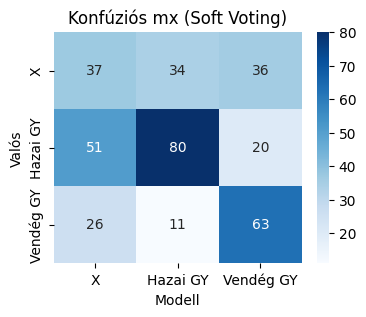

              precision    recall  f1-score   support

           0     0.3246    0.3458    0.3348       107
           1     0.6400    0.5298    0.5797       151
           2     0.5294    0.6300    0.5753       100

    accuracy                         0.5028       358
   macro avg     0.4980    0.5019    0.4966       358
weighted avg     0.5148    0.5028    0.5053       358



In [449]:
pred_odds_serie_a = process_predictions(test_predictions_serie_a)
evaluation(pred_odds_serie_a)

In [450]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(
    pred_odds_serie_a,
    stake=500)

ROI hard : 1.99%
ROI soft : 2.72%


## La Liga, FTR

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)
Accuracy: 0.6162
              precision    recall  f1-score   support

           0       0.63      0.64      0.63       191
           1       0.61      0.59      0.60       179

    accuracy                           0.62       370
   macro avg       0.62      0.62      0.62       370
weighted avg       0.62      0.62      0.62       370



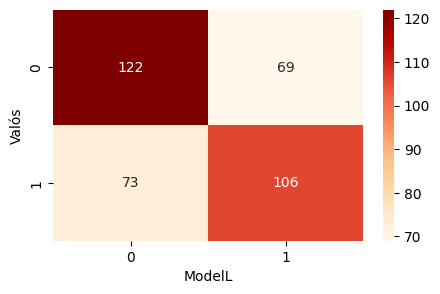

['GD_diff', 'cumulative_points_diff', 'away_cumulative_goals_diff', 'home_deep_completions_RA', 'away_deep_completions_RA', 'home_cumulative_goals_diff', 'prob_HomeW_odds_market', 'home_shots_OT_RA', 'home_expected_points_RA', 'prob_AwayW_odds_market', 'home_ppda_RA', 'home_np_xg_difference_RA', 'home_points_cumulative', 'away_np_xg_RA', 'home_shots_RA', 'away_expected_points_RA', 'home_np_xg_RA', 'away_np_xg_difference_RA', 'away_xg_RA', 'away_points_cumulative']


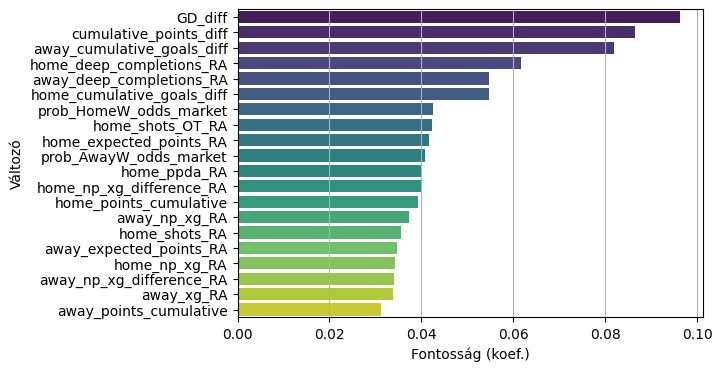

In [451]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

la_liga_tuned_home, la_liga_params_home, la_liga_features_home = logistic_regression_tuning(la_liga, target_col, drop, odds)

tanító halmaz dimenziók: (2958, 67)
validációs halmaz dimenziók: (370, 67)

tanító halmaz indexek: (i: 1 -> 2958)
validációs halmaz:  (i: 2959 -> 3328)
Accuracy: 0.6541
              precision    recall  f1-score   support

           0       0.83      0.65      0.73       265
           1       0.43      0.66      0.52       105

    accuracy                           0.65       370
   macro avg       0.63      0.65      0.62       370
weighted avg       0.71      0.65      0.67       370



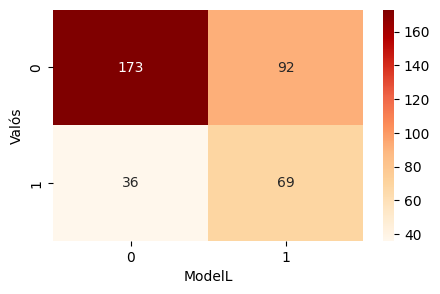

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'away_last5_draw_rate', 'home_goals_for_RA', 'home_expected_points_RA', 'away_last5_draws_count', 'home_np_xg_difference_RA', 'home_clinicality', 'prob_Draw_odds_market', 'home_last5_under_2_5_count', 'home_halftime_goals_RA', 'away_cumulative_goals_diff', 'away_clinicality', 'away_goals_against_RA', 'away_np_xg_RA', 'home_last5_draw_rate', 'away_goals_for_RA', 'home_shots_RA', 'home_xg_RA', 'away_halftime_goals_RA']


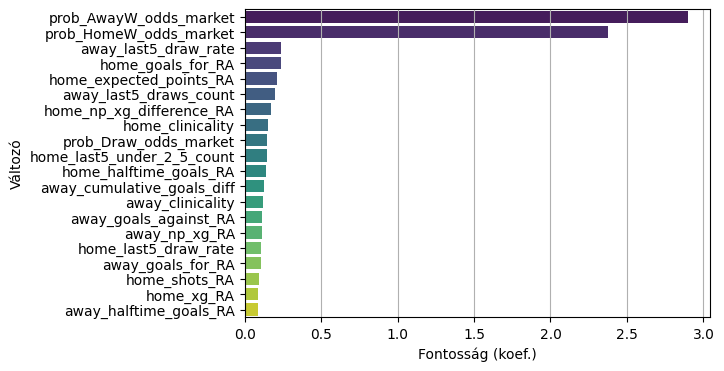

In [452]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']


target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

la_liga_tuned_away, la_liga_params_away,la_liga_features_away = logistic_regression_tuning(la_liga, target_col, drop, odds)

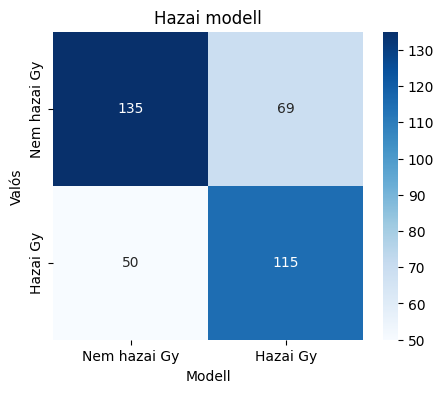

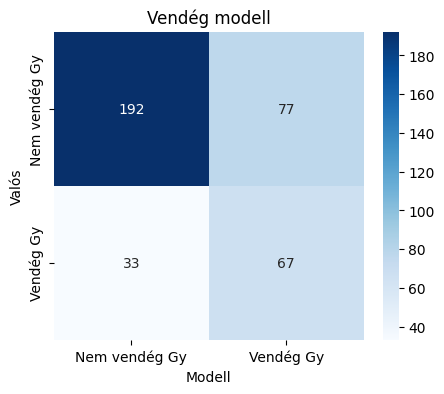

Legjobb küszöbérték a validációs halmazon: 0.12


In [453]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_la_liga, logreg_home_la_liga, logreg_away_la_liga = logreg_final(
    la_liga, drop_cols_home, drop_cols_away, odds, la_liga_params_home, la_liga_params_away
)

Summary for HARD VOTING model


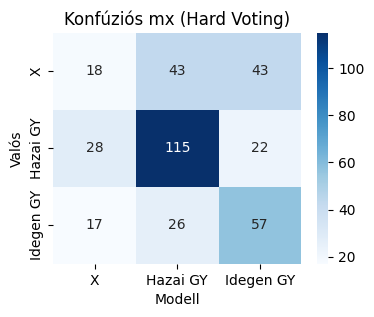

              precision    recall  f1-score   support

           0     0.2857    0.1731    0.2156       104
           1     0.6250    0.6970    0.6590       165
           2     0.4672    0.5700    0.5135       100

    accuracy                         0.5149       369
   macro avg     0.4593    0.4800    0.4627       369
weighted avg     0.4866    0.5149    0.4946       369


Summary for SOFT VOTING model


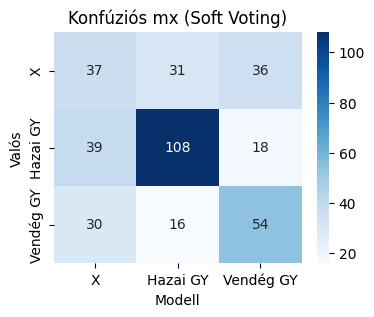

              precision    recall  f1-score   support

           0     0.3491    0.3558    0.3524       104
           1     0.6968    0.6545    0.6750       165
           2     0.5000    0.5400    0.5192       100

    accuracy                         0.5393       369
   macro avg     0.5153    0.5168    0.5155       369
weighted avg     0.5454    0.5393    0.5419       369



In [454]:
pred_odds_la_liga = process_predictions(test_predictions_la_liga)
evaluation(pred_odds_la_liga)

In [455]:
roi_hard,roi_soft, df_profit_hard, df_loss_hard,df_profit_soft,df_loss_soft,pred_odds_soft = betting_logreg(
    pred_odds_la_liga,
    stake=500)

ROI hard : 0.24%
ROI soft : 10.09%


## Ligue 1, FTR

tanító halmaz dimenziók: (2817, 67)
validációs halmaz dimenziók: (352, 67)

tanító halmaz indexek: (i: 1 -> 2817)
validációs halmaz:  (i: 2818 -> 3169)
Accuracy: 0.6591
              precision    recall  f1-score   support

           0       0.74      0.63      0.68       205
           1       0.58      0.69      0.63       147

    accuracy                           0.66       352
   macro avg       0.66      0.66      0.66       352
weighted avg       0.67      0.66      0.66       352



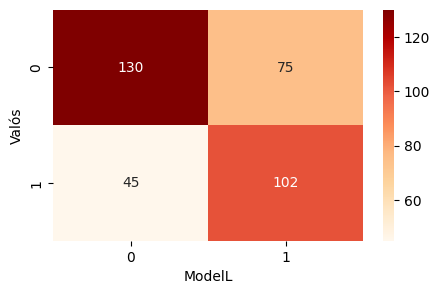

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'prob_O2.5_odds_market', 'prob_U2.5_odds_market', 'home_last5_over_2_5_count', 'away_last5_over_2_5_count', 'home_goals_for_RA', 'home_last5_under_2_5_count', 'away_last5_under_2_5_count', 'home_clinicality', 'away_last5_draws_count', 'away_expected_points_RA', 'home_last5_draws_count', 'away_np_xg_RA', 'home_last5_wins_count', 'away_last5_losses_count', 'home_last5_losses_count', 'home_xg_RA', 'away_last5_wins_count', 'away_clinicality']


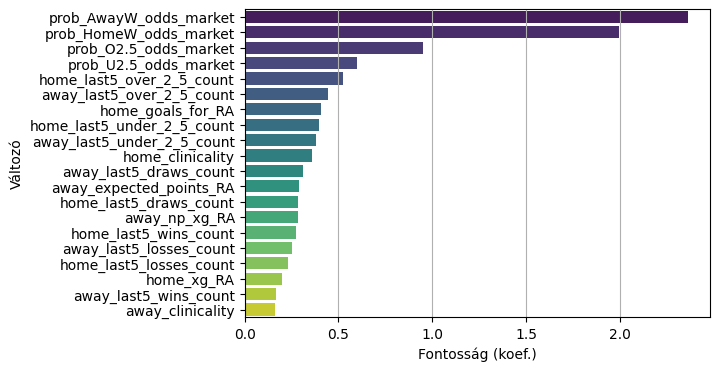

In [456]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

ligue_1_tuned_home, ligue_1_params_home, ligue_1_features_home = logistic_regression_tuning(ligue_1, target_col, drop, odds)

tanító halmaz dimenziók: (2817, 67)
validációs halmaz dimenziók: (352, 67)

tanító halmaz indexek: (i: 1 -> 2817)
validációs halmaz:  (i: 2818 -> 3169)
Accuracy: 0.6875
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       233
           1       0.53      0.66      0.59       119

    accuracy                           0.69       352
   macro avg       0.67      0.68      0.67       352
weighted avg       0.71      0.69      0.69       352



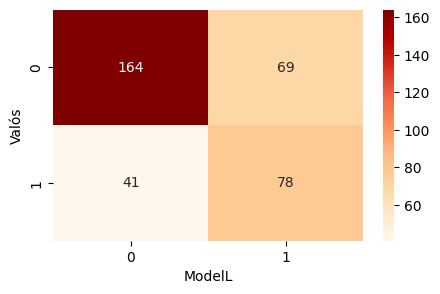

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'home_goals_for_RA', 'prob_U2.5_odds_market', 'home_clinicality', 'away_goals_for_RA', 'home_xg_RA', 'away_last5_losses_count', 'away_cumulative_goals_diff', 'away_last5_draw_rate', 'home_deep_completions_RA', 'away_expected_points_RA', 'home_np_xg_RA', 'away_xg_RA', 'away_np_xg_RA', 'away_deep_completions_RA', 'away_last5_draws_count', 'home_last5_wins_count', 'home_expected_points_RA', 'home_last5_draws_count']


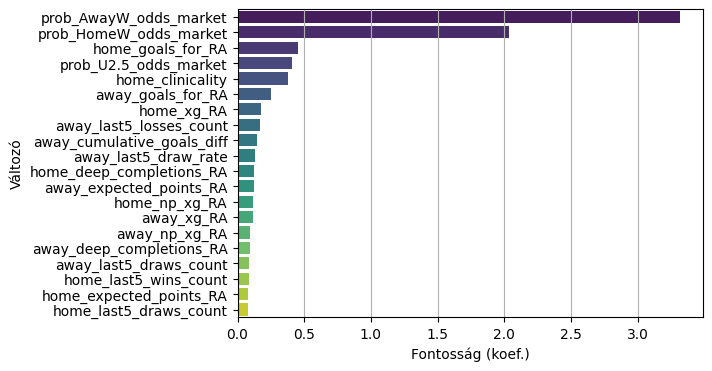

In [457]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw']
odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']

target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

ligue_1_tuned_away, ligue_1_params_away, ligue_1_features_away = logistic_regression_tuning(ligue_1, target_col, drop, odds)

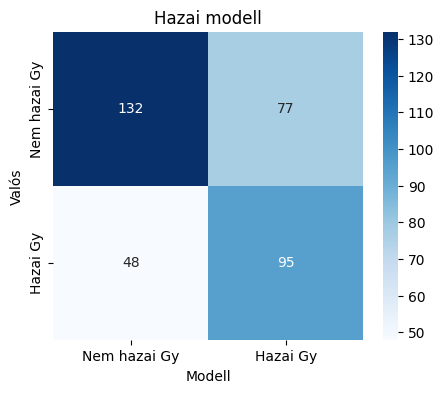

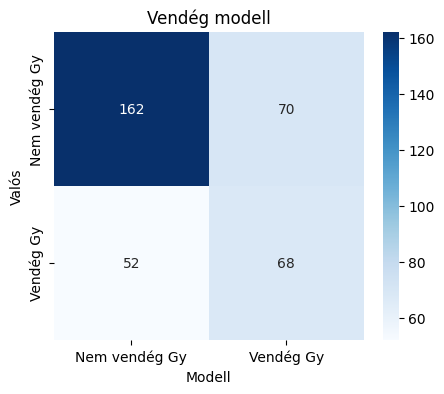

Legjobb küszöbérték a validációs halmazon: 0.07


In [458]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_ligue_1, logreg_home_ligue_1, logreg_away_ligue_1 = logreg_final(
    ligue_1, drop_cols_home, drop_cols_away, odds, ligue_1_params_home, ligue_1_params_away
)

Summary for HARD VOTING model


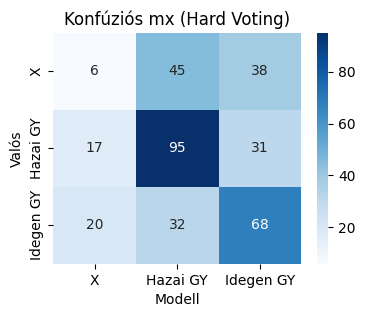

              precision    recall  f1-score   support

           0     0.1395    0.0674    0.0909        89
           1     0.5523    0.6643    0.6032       143
           2     0.4964    0.5667    0.5292       120

    accuracy                         0.4801       352
   macro avg     0.3961    0.4328    0.4078       352
weighted avg     0.4289    0.4801    0.4484       352


Summary for SOFT VOTING model


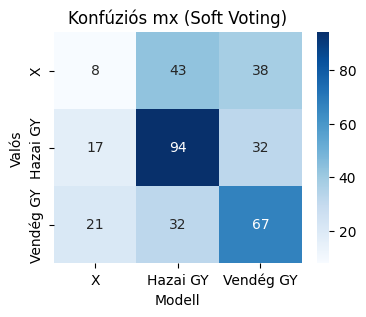

              precision    recall  f1-score   support

           0     0.1739    0.0899    0.1185        89
           1     0.5562    0.6573    0.6026       143
           2     0.4891    0.5583    0.5214       120

    accuracy                         0.4801       352
   macro avg     0.4064    0.4352    0.4142       352
weighted avg     0.4367    0.4801    0.4525       352



In [459]:
pred_odds_ligue_1 = process_predictions(test_predictions_ligue_1)
evaluation(pred_odds_ligue_1)

In [460]:
roi_hard, roi_soft, df_profit_hard, df_loss_hard, df_profit_soft, df_loss_soft, pred_odds_soft = betting_logreg(
    pred_odds_ligue_1,
    stake=500
)

ROI hard : -8.62%
ROI soft : -8.26%


## Kombinált, FTR

tanító halmaz dimenziók: (13971, 67)
validációs halmaz dimenziók: (1746, 67)

tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)
Accuracy: 0.6552
              precision    recall  f1-score   support

           0       0.69      0.67      0.68       949
           1       0.62      0.64      0.63       797

    accuracy                           0.66      1746
   macro avg       0.65      0.65      0.65      1746
weighted avg       0.66      0.66      0.66      1746



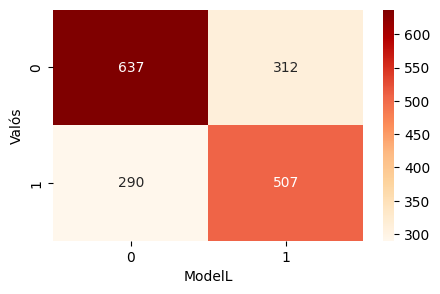

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'prob_U2.5_odds_market', 'home_np_xg_difference_RA', 'away_expected_points_RA', 'away_cumulative_goals_diff', 'away_np_xg_RA', 'home_np_xg_RA', 'home_last5_under_2_5_count', 'home_halftime_goals_RA', 'away_last5_over_2_5_count', 'win_rate_diff', 'away_last5_wins_count', 'away_points_cumulative', 'home_shots_OT_RA', 'home_ppda_RA', 'home_last5_losses_count', 'home_last5_over_2_5_count', 'GD_diff', 'away_deep_completions_RA']


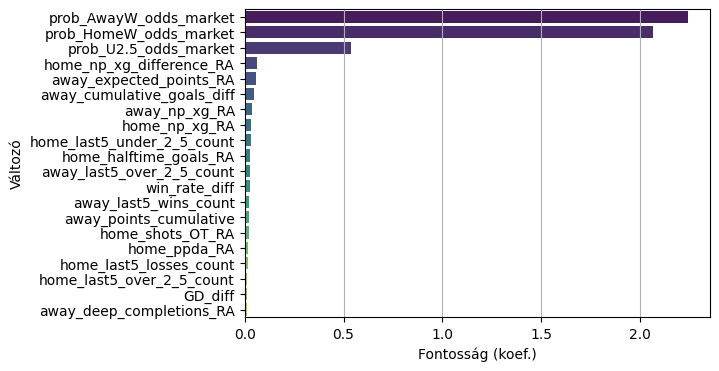

In [461]:
target_col = 'target_home_win'
drop = ['target_o2.5', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

big5_tuned_home, big5_params_home, big5_features_home = logistic_regression_tuning(big5, target_col, drop, odds)

tanító halmaz dimenziók: (13971, 67)
validációs halmaz dimenziók: (1746, 67)

tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)
Accuracy: 0.6466
              precision    recall  f1-score   support

           0       0.81      0.65      0.72      1222
           1       0.44      0.65      0.52       524

    accuracy                           0.65      1746
   macro avg       0.63      0.65      0.62      1746
weighted avg       0.70      0.65      0.66      1746



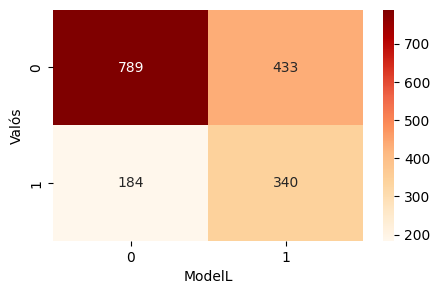

['prob_AwayW_odds_market', 'prob_HomeW_odds_market', 'home_clinicality', 'away_cumulative_goals_diff', 'away_last5_losses_count', 'home_shots_OT_RA', 'away_last5_draw_rate', 'away_goals_for_RA', 'home_last5_under_2_5_count', 'home_last5_losses_count', 'away_np_xg_difference_RA', 'home_expected_points_RA', 'home_deep_completions_RA', 'home_np_xg_difference_RA', 'away_last5_draws_count', 'away_last5_wins_count', 'away_ppda_RA', 'home_halftime_goals_RA', 'away_expected_points_RA', 'home_shots_RA']


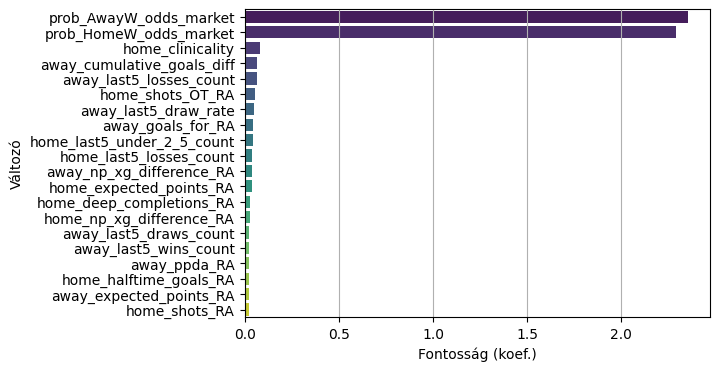

In [462]:
target_col = 'target_away_win'
drop = ['target_o2.5', 'target_home_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

big5_tuned_away, big5_params_away, big5_features_away = logistic_regression_tuning(big5, target_col, drop, odds)

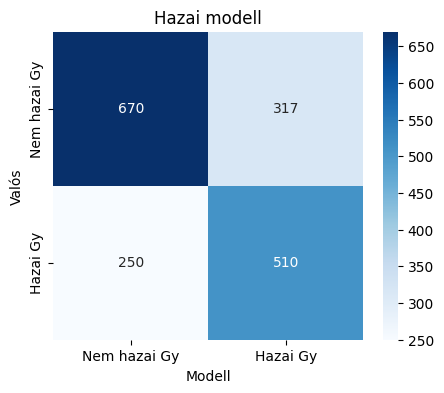

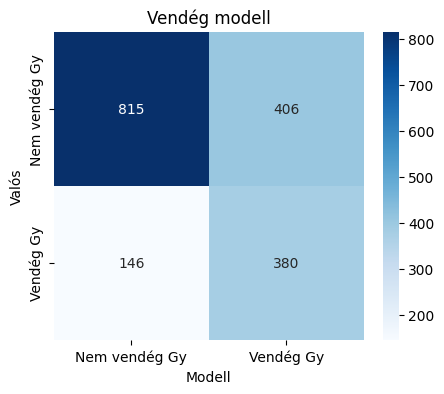

Legjobb küszöbérték a validációs halmazon: 0.20


In [463]:
drop_cols_home =['target_away_win', 'target_draw','target_o2.5',
                 'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# drop_cols_away =['target_home_win', 'target_draw','target_o2.5']

drop_cols_away =['target_home_win', 'target_draw','target_o2.5',
                'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']

# odds = ['HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

test_predictions_big5, logreg_home_big5, logreg_away_big5 = logreg_final(
    big5, drop_cols_home, drop_cols_away, odds, big5_params_home, big5_params_away
)

Summary for HARD VOTING model


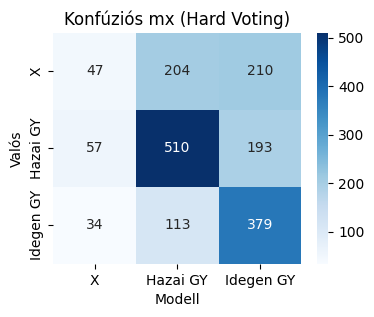

              precision    recall  f1-score   support

           0     0.3406    0.1020    0.1569       461
           1     0.6167    0.6711    0.6427       760
           2     0.4847    0.7205    0.5795       526

    accuracy                         0.5358      1747
   macro avg     0.4806    0.4978    0.4597      1747
weighted avg     0.5041    0.5358    0.4955      1747


Summary for SOFT VOTING model


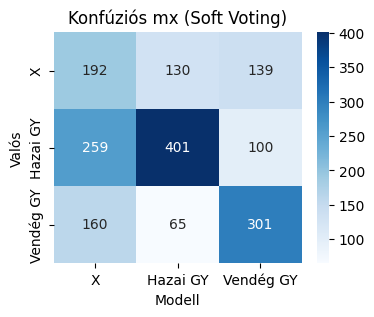

              precision    recall  f1-score   support

           0     0.3142    0.4165    0.3582       461
           1     0.6728    0.5276    0.5914       760
           2     0.5574    0.5722    0.5647       526

    accuracy                         0.5117      1747
   macro avg     0.5148    0.5055    0.5048      1747
weighted avg     0.5434    0.5117    0.5219      1747



In [464]:
pred_odds_big5 = process_predictions(test_predictions_big5)
evaluation(pred_odds_big5)

In [465]:
roi_hard, roi_soft, df_profit_hard, df_loss_hard, df_profit_soft, df_loss_soft, pred_odds_soft = betting_logreg(
    pred_odds_big5,
    stake=500
)

ROI hard : 1.38%
ROI soft : 4.83%


# U/O 2.5

## PL

In [205]:
# def logistic_regression_tuning_underover(df, target_col, drop_cols=[], odds=[]):
#     df = df.dropna().reset_index(drop=True)

#     X = df.drop(columns=[target_col] + drop_cols)
#     y = df[target_col]
    
#     train_n = int(len(df) * 0.8) 
#     val_n = int(len(df) * 0.1)    
    
#     train_set = df.iloc[:train_n]        
#     val_set = df.iloc[train_n:train_n + val_n] 
#     test_set = df.iloc[train_n + val_n:]  

#     print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
#     print(f"validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")
#     print(f"teszt halmaz:  (i: {test_set.index[0]+1} -> {test_set.index[-1]+1})")

#     X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
#     X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]
#     X_test, y_test = test_set.drop(columns=[target_col] + drop_cols), test_set[target_col]

#     X_train_odds = X_train[odds]
#     X_val_odds = X_val[odds]
#     X_test_odds = X_test[odds]
    
#     X_train = X_train.drop(columns=odds)
#     X_val = X_val.drop(columns=odds)
#     X_test = X_test.drop(columns=odds)

#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_val_scaled = scaler.transform(X_val)
#     X_test_scaled = scaler.transform(X_test)

    
#     X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
#     X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    
#     X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
#     X_val_scaled = pd.concat([X_val_scaled, X_val_odds], axis=1)
    
#     param_space = [
#         {'C': Real(1e-3, 1e3, prior='log-uniform'),
#          'penalty': ['l1'],
#          'solver': ['liblinear', 'saga'],
#          'class_weight': [None, 'balanced'],
#          'max_iter': Integer(100, 500)},
    
#         {'C': Real(1e-3, 1e3, prior='log-uniform'),
#          'penalty': ['l2'],
#          'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
#          'class_weight': [None, 'balanced'],
#          'max_iter': Integer(100, 500)},
    
#         {'C': Real(1e-3, 1e3, prior='log-uniform'),
#          'penalty': ['elasticnet'],
#          'solver': ['saga'],  
#          'l1_ratio': Real(0, 1),
#          'class_weight': [None, 'balanced'],
#          'max_iter': Integer(100, 500)},
#     ]

#     tscv = TimeSeriesSplit(n_splits=5) 
    
#     log_reg = LogisticRegression(random_state=1, max_iter=1000)

#     bayes_search = BayesSearchCV(
#         estimator=log_reg,
#         search_spaces=param_space,
#         n_iter=50, 
#         cv=tscv, 
#         scoring='f1',
#         refit='f1',
#         n_jobs=-1,  
#         random_state=1,
#         verbose=0
#     )
    
#     bayes_search.fit(X_train_scaled, y_train)  
#     best_model = bayes_search.best_estimator_
#     best_params = bayes_search.best_params_
    
#     y_val_probs = best_model.predict_proba(X_val_scaled)
#     val_set = val_set.copy()
#     val_set['P_0'] = y_val_probs[:, 0] 
#     val_set['P_1'] = y_val_probs[:, 1]  

#     thresholds = np.arange(0.1, 0.7, 0.01)
#     f1_scores = []
    
#     for t in thresholds:
#         preds = (y_val_probs[:, 1] >= t).astype(int)
#         f1_scores.append(f1_score(y_val, preds, average='macro'))
    
#     best_threshold = thresholds[np.argmax(f1_scores)]
#     best_f1 = max(f1_scores)
    
#     print(f"\nLegjobb threshold: {best_threshold:.2f}, Legjobb F1: {best_f1:.4f}")
    
#     plt.figure(figsize=(7, 4))
#     plt.plot(thresholds, f1_scores, color='teal')
#     plt.axvline(best_threshold, color='red', linestyle='--', label=f'Legjobb: {best_threshold:.2f}')
#     plt.xlabel("Határérték")
#     plt.ylabel("Átlagos F1-érték")
#     plt.grid()
#     plt.legend()
#     plt.show()

#     y_pred = (y_val_probs[:, 1] >= best_threshold).astype(int)
#     val_set['Predicted'] = y_pred

#     print(classification_report(y_val, y_pred))
    
#     plt.figure(figsize=(5, 3))
#     cm = confusion_matrix(y_val, y_pred)
#     sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
#     plt.xlabel("Modell")
#     plt.ylabel("Valós")
#     plt.show()
    
#     feature_importances = pd.DataFrame({
#         'feature': X_train_scaled.columns,
#         'importance': np.abs(best_model.coef_).flatten()
#     }).sort_values(by='importance', ascending=False)
    
#     top_20_features = feature_importances.head(20)['feature'].tolist()
#     print(top_20_features)

#     plt.figure(figsize=(6, 4))
#     sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
#     plt.xlabel("Fontosság (koef.)")
#     plt.ylabel("Változó")
#     plt.grid(axis='x')
#     plt.show()
    
#     return val_set, best_params, top_20_features


In [466]:
def logistic_regression_tuning_underover(df, target_col, drop_cols=[], odds=[]):

    df = df.dropna().reset_index(drop=True)

    train_n = int(len(df) * 0.8) 
    val_n = int(len(df) * 0.1)    
    
    train_set = df.iloc[:train_n]        
    val_set = df.iloc[train_n:train_n + val_n] 
    test_set = df.iloc[train_n + val_n:]  

    print(f"\nTanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
    print(f"Validációs halmaz:  (i: {val_set.index[0]+1} -> {val_set.index[-1]+1})")
    print(f"Teszt halmaz:  (i: {test_set.index[0]+1} -> {test_set.index[-1]+1})")

    X_train, y_train = train_set.drop(columns=[target_col] + drop_cols), train_set[target_col]
    X_val, y_val = val_set.drop(columns=[target_col] + drop_cols), val_set[target_col]
    X_test, y_test = test_set.drop(columns=[target_col] + drop_cols), test_set[target_col]

    X_train_odds = X_train[odds] if odds else pd.DataFrame(index=X_train.index)
    X_val_odds = X_val[odds] if odds else pd.DataFrame(index=X_val.index)
    X_test_odds = X_test[odds] if odds else pd.DataFrame(index=X_test.index)
    
    if odds:
        X_train = X_train.drop(columns=odds)
        X_val = X_val.drop(columns=odds)
        X_test = X_test.drop(columns=odds)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
    X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
    X_val_scaled = pd.concat([X_val_scaled, X_val_odds], axis=1)
    X_test_scaled = pd.concat([X_test_scaled, X_test_odds], axis=1)
    
    param_space = [
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l1'],
         'solver': ['liblinear', 'saga'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['l2'],
         'solver': ['liblinear', 'saga', 'lbfgs', 'newton-cg'],
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    
        {'C': Real(1e-3, 1e3, prior='log-uniform'),
         'penalty': ['elasticnet'],
         'solver': ['saga'],  
         'l1_ratio': Real(0, 1),
         'class_weight': [None, 'balanced'],
         'max_iter': Integer(100, 500)},
    ]

    tscv = TimeSeriesSplit(n_splits=5) 
    
    log_reg = LogisticRegression(random_state=1, max_iter=1000)

    bayes_search = BayesSearchCV(
        estimator=log_reg,
        search_spaces=param_space,
        n_iter=50, 
        cv=tscv, 
        scoring='f1',
        refit='f1',
        n_jobs=-1,  
        random_state=1,
        verbose=0
    )
    
    bayes_search.fit(X_train_scaled, y_train)  
    best_model = bayes_search.best_estimator_
    best_params = bayes_search.best_params_
    
    print("\nLegjobb hiperparaméterek:")
    for param, value in best_params.items():
        print(f"{param}: {value}")
    
    y_val_probs = best_model.predict_proba(X_val_scaled)
    val_results = val_set.copy()
    val_results['P_0'] = y_val_probs[:, 0] 
    val_results['P_1'] = y_val_probs[:, 1]  

    thresholds = np.arange(0.1, 0.7, 0.01)
    f1_scores = []
    
    for t in thresholds:
        preds = (y_val_probs[:, 1] >= t).astype(int)
        f1_scores.append(f1_score(y_val, preds, average='macro'))
    
    best_threshold = thresholds[np.argmax(f1_scores)]
    best_f1 = max(f1_scores)
    
    print(f"\nLegjobb threshold: {best_threshold:.2f}, Legjobb F1: {best_f1:.4f}")
    
    plt.figure(figsize=(7, 4))
    plt.plot(thresholds, f1_scores, color='teal')
    plt.axvline(best_threshold, color='red', linestyle='--', label=f'Legjobb: {best_threshold:.2f}')
    plt.xlabel("Határérték")
    plt.ylabel("Átlagos F1-érték")
    plt.grid()
    plt.legend()
    plt.title("Határérték optimalizálása a validációs halmazon")
    plt.show()

    # Apply the best threshold to validation predictions
    y_val_pred = (y_val_probs[:, 1] >= best_threshold).astype(int)
    val_results['Predicted'] = y_val_pred

    print("\nValidációs halmaz eredményei:")
    print(classification_report(y_val, y_val_pred))
    
    plt.figure(figsize=(5, 3))
    cm_val = confusion_matrix(y_val, y_val_pred)
    sns.heatmap(cm_val, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Validációs halmaz konfúziós mátrixa")
    plt.show()
    
    feature_importances = pd.DataFrame({
        'feature': X_train_scaled.columns,
        'importance': np.abs(best_model.coef_).flatten()
    }).sort_values(by='importance', ascending=False)
    
    top_20_features = feature_importances.head(20)['feature'].tolist()
    
    plt.figure(figsize=(8, 6))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
    plt.xlabel("Fontosság (koef.)")
    plt.ylabel("Változó")
    plt.grid(axis='x')
    plt.title("Top 20 legfontosabb változó")
    plt.tight_layout()
    plt.show()
    
    y_test_probs = best_model.predict_proba(X_test_scaled)
    test_results = test_set.copy()
    test_results['P_0'] = y_test_probs[:, 0]
    test_results['P_1'] = y_test_probs[:, 1]
    y_test_pred = (y_test_probs[:, 1] >= best_threshold).astype(int)
    test_results['Predicted'] = y_test_pred
    
    print("\nTeszt halmaz eredményei:")
    print(classification_report(y_test, y_test_pred))
    
    plt.figure(figsize=(5, 3))
    cm_test = confusion_matrix(y_test, y_test_pred)
    sns.heatmap(cm_test, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title("Teszt halmaz konfúziós mátrixa")
    plt.show()
    
    return test_results, best_model, top_20_features


Tanító halmaz indexek: (i: 1 -> 2958)
Validációs halmaz:  (i: 2959 -> 3327)
Teszt halmaz:  (i: 3328 -> 3698)
Hyperparaméterek hangolása...

Legjobb hiperparaméterek:
C: 171.3928432232203
class_weight: None
max_iter: 500
penalty: l2
solver: lbfgs

Legjobb threshold: 0.49, Legjobb F1: 0.5581


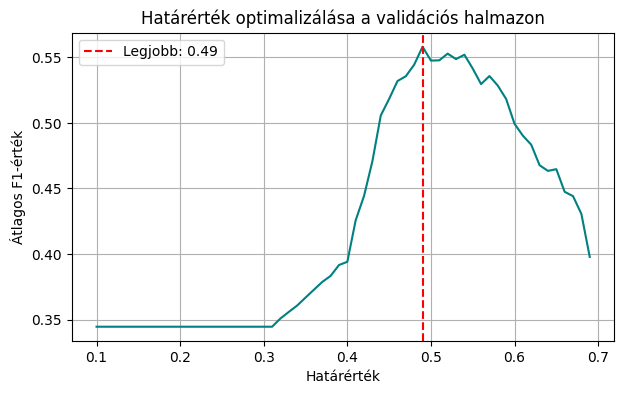


Validációs halmaz eredményei:
              precision    recall  f1-score   support

           0       0.57      0.42      0.48       175
           1       0.57      0.71      0.64       194

    accuracy                           0.57       369
   macro avg       0.57      0.56      0.56       369
weighted avg       0.57      0.57      0.56       369



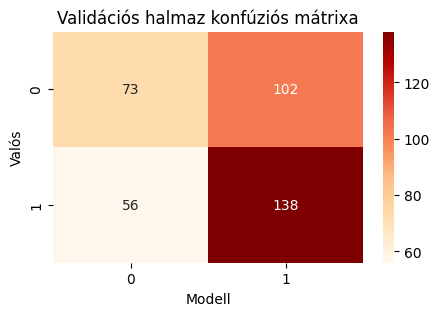

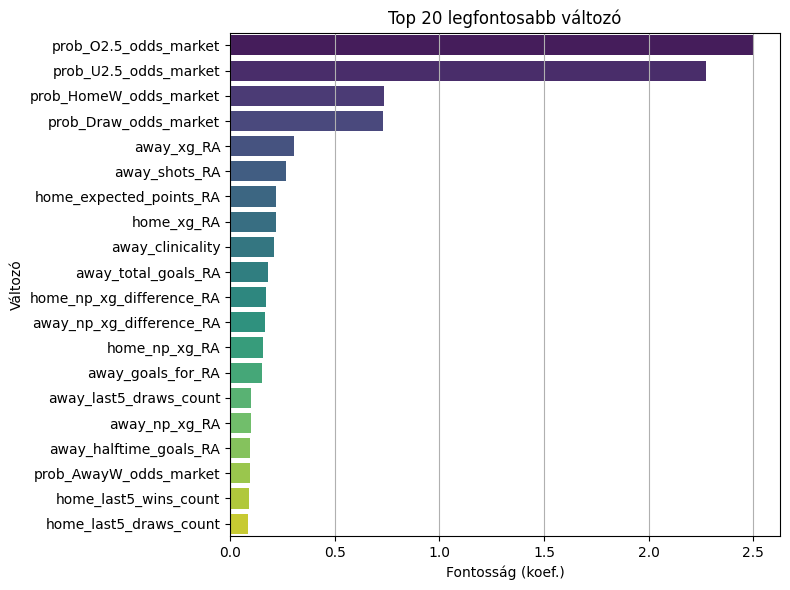


Teszt halmaz eredményei:
              precision    recall  f1-score   support

           0       0.47      0.20      0.28       129
           1       0.67      0.88      0.76       242

    accuracy                           0.64       371
   macro avg       0.57      0.54      0.52       371
weighted avg       0.60      0.64      0.60       371



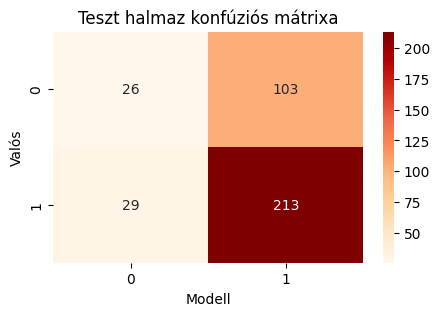

In [467]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

premier_league_tuned_UO, pl_lr_uo, premier_league_features_UO  = logistic_regression_tuning_underover(
    premier_league,
    target_col,
    drop,
    odds
)

In [299]:
# def logistic_regression_test_underover(df, target_col, drop_cols=[], odds=[], best_params={}):
    
#     df = df.dropna().reset_index(drop=True)

#     X = df.drop(columns=[target_col] + drop_cols)
#     y = df[target_col]
    
#     train_n = int(round(len(df) * 0.9, 0))
#     test_n = len(df) - train_n 

#     train_set = df.iloc[:train_n]        
#     test_set = df.iloc[train_n:] 

#     print(f"\ntanító halmaz indexek: (i: {train_set.index[0]+1} -> {train_set.index[-1]+1})")
#     print(f"teszt halmaz:  (i: {test_set.index[0]+1} -> {test_set.index[-1]+1})")

#     X_train = train_set.drop(columns=[target_col] + drop_cols)
#     y_train = train_set[target_col]
#     X_test = test_set.drop(columns=[target_col] + drop_cols)
#     y_test = test_set[target_col]

#     X_train_odds = X_train[odds]
#     X_test_odds = X_test[odds]
#     X_train = X_train.drop(columns=odds)
#     X_test = X_test.drop(columns=odds)
    
#     scaler = StandardScaler()
#     X_train_scaled = scaler.fit_transform(X_train)
#     X_test_scaled = scaler.transform(X_test)
    
#     X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
#     X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)
    
#     X_train_scaled = pd.concat([X_train_scaled, X_train_odds], axis=1)
#     X_test_scaled = pd.concat([X_test_scaled, X_test_odds], axis=1)

#     log_reg = LogisticRegression(
#         C=best_params.get('C', 1.0),
#         penalty=best_params.get('penalty', 'l2'),
#         solver=best_params.get('solver', 'liblinear'),
#         class_weight=best_params.get('class_weight', None),
#         # class_weight='balanced',
#         random_state=best_params.get('random_state', 1),
#         max_iter=1000,
#         l1_ratio=best_params.get('l1_ratio', 0.5) if best_params.get('penalty') == 'elasticnet' else None  
#     )
    
#     log_reg.fit(X_train_scaled, y_train)

#     y_test_probs = log_reg.predict_proba(X_test_scaled)
    
#     thresholds = np.arange(0.1, 0.7, 0.01)
#     f1_scores = []

#     for t in thresholds:
#         preds = (y_test_probs[:, 1] >= t).astype(int)
#         f1_scores.append(f1_score(y_test, preds, average='macro'))

#     best_threshold = thresholds[np.argmax(f1_scores)]
#     best_f1 = max(f1_scores)

#     print(f"\nBest threshold: {best_threshold:.2f}, Best F1: {best_f1:.4f}")

#     plt.figure(figsize=(7, 4))
#     plt.plot(thresholds, f1_scores, color='teal')
#     plt.axvline(best_threshold, color='red', linestyle='--')
#     plt.xlabel("Határérték")
#     plt.ylabel("Átlagos F1-érték")
#     plt.grid()
#     plt.show()

#     y_pred = (y_test_probs[:, 1] >= best_threshold).astype(int)

#     test_set = test_set.copy()
#     test_set['P_0'] = y_test_probs[:, 0]
#     test_set['P_1'] = y_test_probs[:, 1]
#     test_set['Predicted'] = y_pred

#     print(classification_report(y_test, y_pred))

#     feature_importances = pd.DataFrame({
#         'feature': X_train_scaled.columns,
#         'importance': np.abs(log_reg.coef_).flatten()
#     }).sort_values(by='importance', ascending=False)
    
#     top_20_features = feature_importances.head(20)['feature'].tolist()
#     print(top_20_features)

#     plt.figure(figsize=(6, 4))
#     sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
#     plt.xlabel("Fontosság (koef.)")
#     plt.ylabel("Változó")
#     plt.grid(axis='x')
#     plt.show()
    
#     plt.figure(figsize=(5, 3))
#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
#     plt.xlabel("Modell")
#     plt.ylabel("Valós")
#     plt.show()

#     return test_set



tanító halmaz indexek: (i: 1 -> 3328)
teszt halmaz:  (i: 3329 -> 3698)

Best threshold: 0.59, Best F1: 0.5257


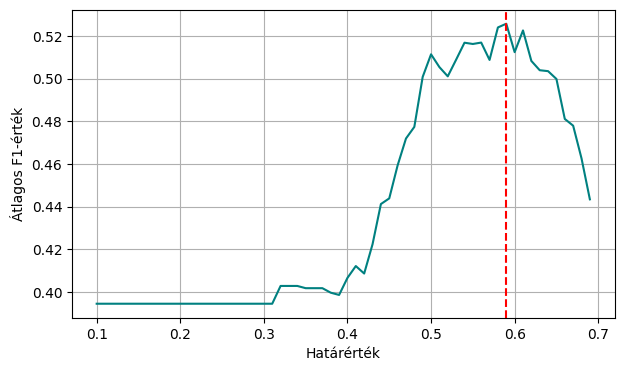

              precision    recall  f1-score   support

           0       0.38      0.46      0.42       129
           1       0.67      0.60      0.64       241

    accuracy                           0.55       370
   macro avg       0.53      0.53      0.53       370
weighted avg       0.57      0.55      0.56       370



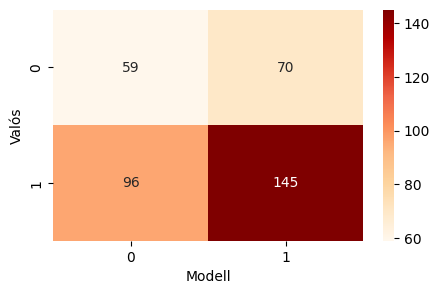

In [208]:
# target_col = 'target_o2.5'
# drop = ['target_home_win', 'target_away_win', 'target_draw',
#        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

# premier_league_test_UO = logistic_regression_test_underover(
#     premier_league,
#     target_col,
#     drop,
#     odds,
#     premier_league_params_UO
# )

In [469]:
def betting_logreg_underover(df, stake=1):
    
    df = df.copy() 

    df['Profit'] = 0
    df['Profit'] = df.apply(
        lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                     (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                     -stake, axis=1
    )

    total_profit = df['Profit'].sum()
    total_bets = len(df)

    roi = (total_profit / (total_bets * stake)) * 100
    
    print(f"ROI: {roi:.2f}%")

    df_profit = df[df['target_o2.5'] == df['Predicted']]
    df_loss = df[df['target_o2.5'] != df['Predicted']]

    return roi, df_profit, df_loss, df

roi, df_profit, df_loss, pred_odds = betting_logreg_underover(premier_league_tuned_UO, stake=1)


ROI: 3.74%


>0% profit 16 fordulóban


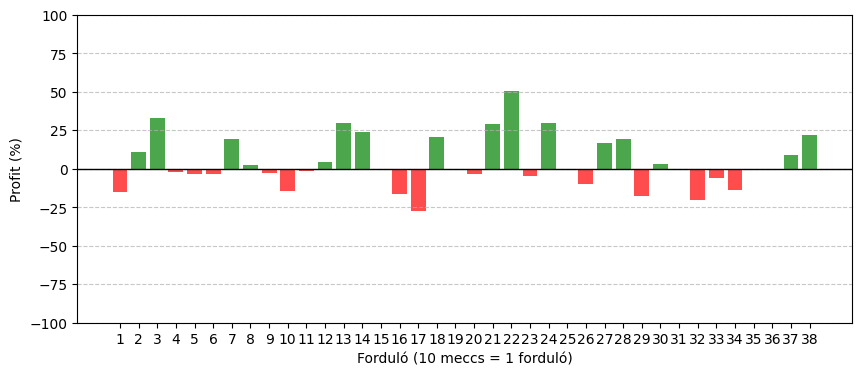

In [471]:
def ROI_sim_UO(df, stake=1, round_size=int):
    
    df = df.copy().reset_index(drop=True)
    
    df['Profit'] = df.apply(
        lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                     (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                     -stake, axis=1
    )
    
    df['Round'] = (df.index // round_size) + 1  
    roi_per_round = df.groupby('Round').agg({'Profit': 'sum'})
    roi_per_round['Total_Bets'] = df.groupby('Round').size()
    roi_per_round['ROI'] = (roi_per_round['Profit'] / (roi_per_round['Total_Bets'] * stake)) * 100

    positive_rounds = (roi_per_round['ROI'] > 0).sum()
    
    print(f'>0% profit {positive_rounds} fordulóban')

    colors = ['red' if roi < 0 else 'green' for roi in roi_per_round['ROI']]
    plt.figure(figsize=(10, 4))
    plt.bar(roi_per_round.index, roi_per_round['ROI'], color=colors, alpha=0.7)
    plt.xlabel(f'Forduló ({round_size} meccs = 1 forduló)')
    plt.ylabel('Profit (%)')
    plt.axhline(0, color='black', linewidth=1)
    plt.xticks(roi_per_round.index)  
    plt.ylim(-100, 100)  
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.savefig(r'abrak/PL_ROI_UO.jpg', format='jpg', dpi=300)
    plt.show()

ROI_sim_UO(premier_league_tuned_UO, round_size=10)

## Bundesliga


Tanító halmaz indexek: (i: 1 -> 2376)
Validációs halmaz:  (i: 2377 -> 2673)
Teszt halmaz:  (i: 2674 -> 2970)
Hyperparaméterek hangolása...

Legjobb hiperparaméterek:
C: 0.012734150498152325
class_weight: None
l1_ratio: 0.48231966084731764
max_iter: 284
penalty: elasticnet
solver: saga

Legjobb threshold: 0.58, Legjobb F1: 0.5371


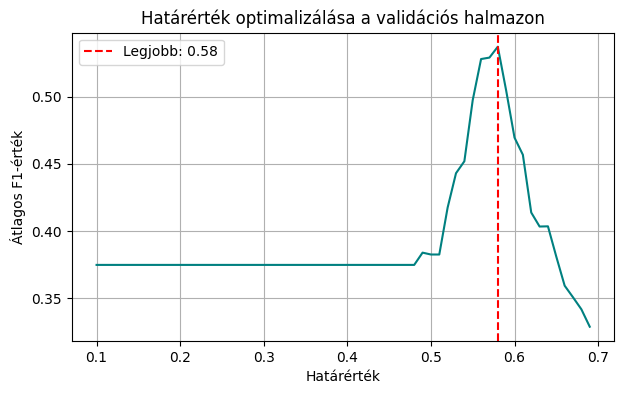


Validációs halmaz eredményei:
              precision    recall  f1-score   support

           0       0.44      0.51      0.47       119
           1       0.64      0.57      0.60       178

    accuracy                           0.55       297
   macro avg       0.54      0.54      0.54       297
weighted avg       0.56      0.55      0.55       297



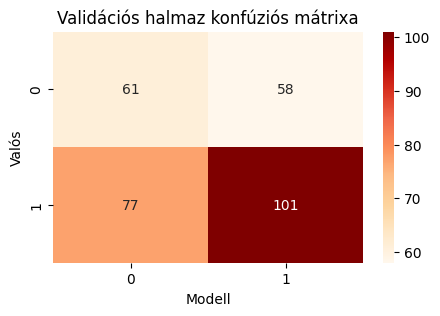

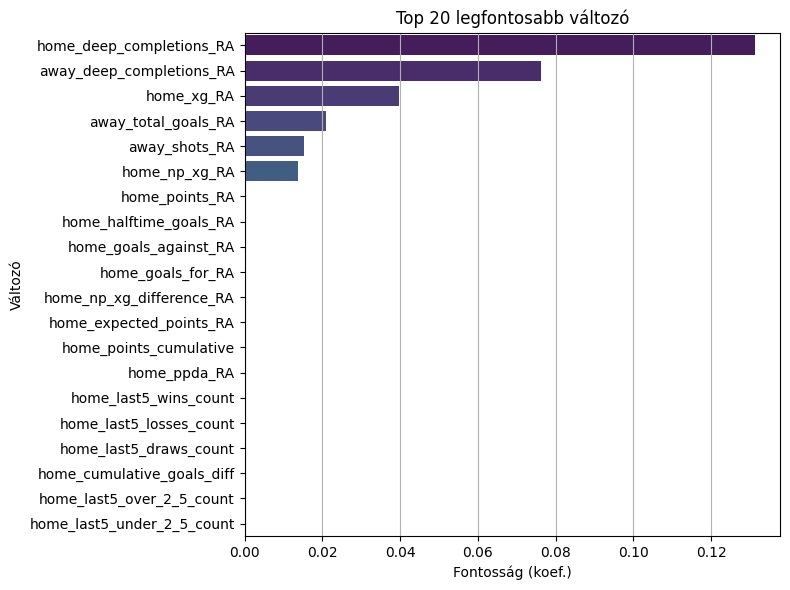


Teszt halmaz eredményei:
              precision    recall  f1-score   support

           0       0.50      0.45      0.47       112
           1       0.69      0.73      0.71       185

    accuracy                           0.62       297
   macro avg       0.59      0.59      0.59       297
weighted avg       0.62      0.62      0.62       297



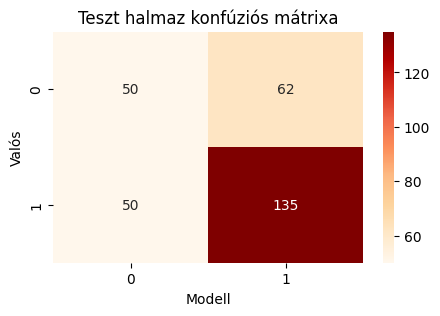

In [473]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']


bundesliga_tuned_UO, gm_lr_uo, bundesliga_features_UO = logistic_regression_tuning_underover(
    bundesliga,  
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 2673)
teszt halmaz:  (i: 2674 -> 2970)

Best threshold: 0.59, Best F1: 0.6065


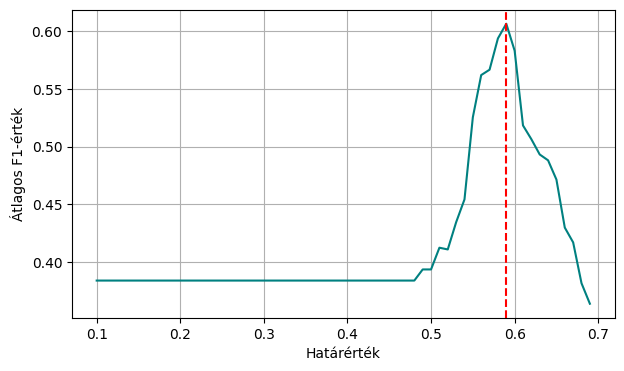

              precision    recall  f1-score   support

           0       0.50      0.58      0.53       112
           1       0.72      0.64      0.68       185

    accuracy                           0.62       297
   macro avg       0.61      0.61      0.61       297
weighted avg       0.63      0.62      0.62       297

['home_deep_completions_RA', 'away_deep_completions_RA', 'home_xg_RA', 'away_shots_RA', 'home_np_xg_RA', 'away_total_goals_RA', 'home_points_RA', 'home_halftime_goals_RA', 'home_goals_against_RA', 'home_goals_for_RA', 'home_np_xg_difference_RA', 'home_expected_points_RA', 'home_points_cumulative', 'home_ppda_RA', 'home_last5_wins_count', 'home_last5_losses_count', 'home_last5_draws_count', 'home_cumulative_goals_diff', 'home_last5_over_2_5_count', 'home_last5_under_2_5_count']


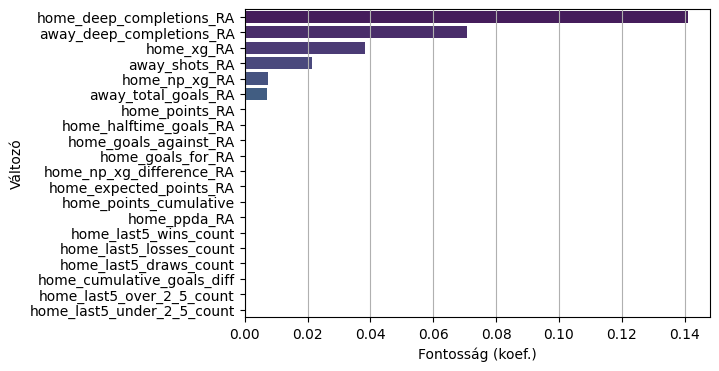

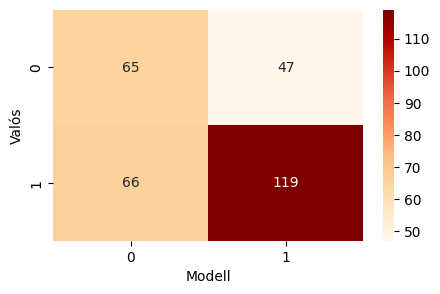

In [301]:
# target_col = 'target_o2.5'
# drop = ['target_home_win', 'target_away_win', 'target_draw',
#        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

# bundesliga_test_UO = logistic_regression_test_underover(
#     bundesliga,
#     target_col,
#     drop,
#     odds,
#     bundesliga_params_UO
# )

In [475]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(bundesliga_tuned_UO, stake=1)

ROI: 4.44%


>0% profit 15 fordulóban


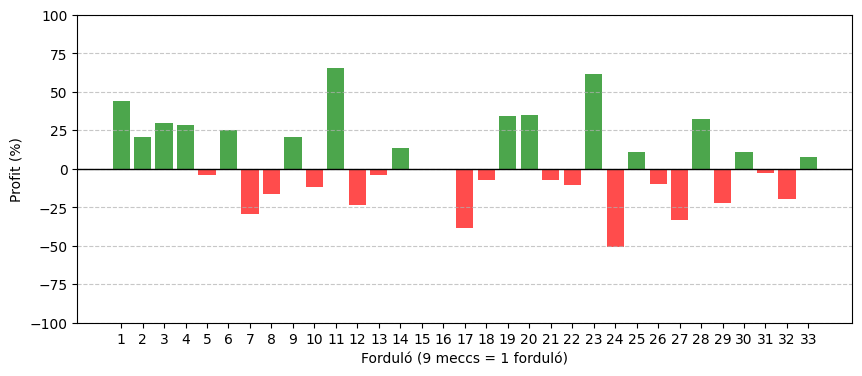

In [476]:
ROI_sim_UO(bundesliga_tuned_UO, round_size=9)

## Serie A


Tanító halmaz indexek: (i: 1 -> 2862)
Validációs halmaz:  (i: 2863 -> 3219)
Teszt halmaz:  (i: 3220 -> 3578)
Hyperparaméterek hangolása...

Legjobb hiperparaméterek:
C: 4.722790071300537
class_weight: None
max_iter: 108
penalty: l1
solver: liblinear

Legjobb threshold: 0.51, Legjobb F1: 0.5323


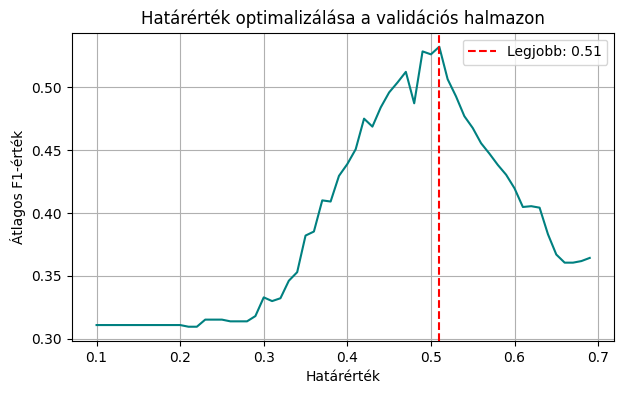


Validációs halmaz eredményei:
              precision    recall  f1-score   support

           0       0.58      0.70      0.63       196
           1       0.51      0.37      0.43       161

    accuracy                           0.55       357
   macro avg       0.54      0.54      0.53       357
weighted avg       0.55      0.55      0.54       357



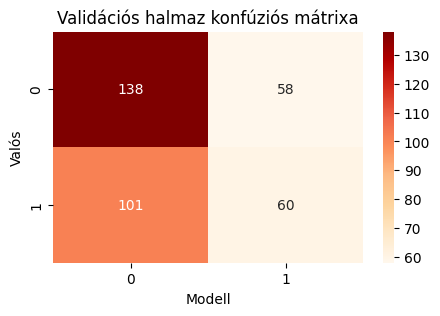

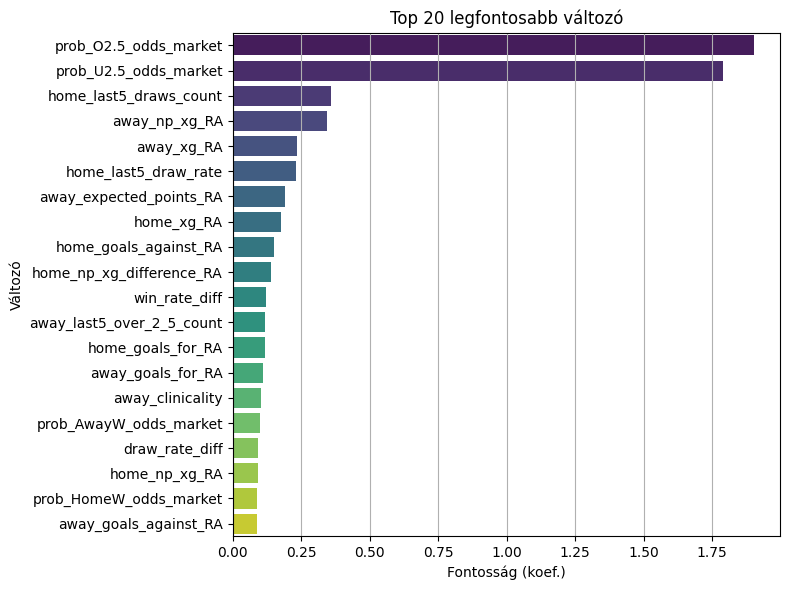


Teszt halmaz eredményei:
              precision    recall  f1-score   support

           0       0.56      0.71      0.62       182
           1       0.58      0.41      0.48       177

    accuracy                           0.57       359
   macro avg       0.57      0.56      0.55       359
weighted avg       0.57      0.57      0.56       359



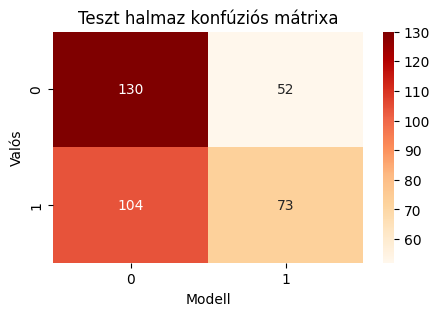

In [478]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


serie_a_tuned_UO, it_lr_uo, serie_a_features_UO = logistic_regression_tuning_underover(
    serie_a,  
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 3220)
teszt halmaz:  (i: 3221 -> 3578)

Best threshold: 0.43, Best F1: 0.5809


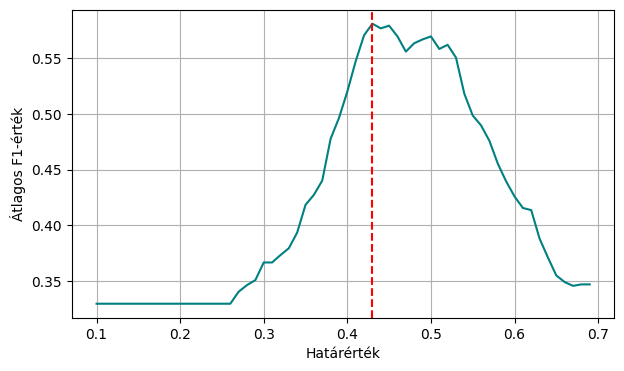

              precision    recall  f1-score   support

           0       0.64      0.44      0.52       182
           1       0.56      0.74      0.64       176

    accuracy                           0.59       358
   macro avg       0.60      0.59      0.58       358
weighted avg       0.60      0.59      0.58       358



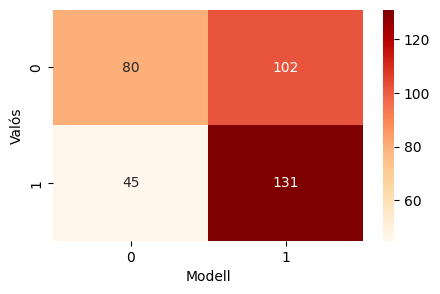

In [217]:
# target_col = 'target_o2.5'
# drop = ['target_home_win', 'target_away_win', 'target_draw',
#        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

# serie_a_test_UO = logistic_regression_test_underover(
#     serie_a,
#     target_col,
#     drop,
#     odds,
#     serie_a_params_UO
# )

In [479]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(serie_a_tuned_UO, stake=1)

ROI: -1.41%


## La Liga


Tanító halmaz indexek: (i: 1 -> 2957)
Validációs halmaz:  (i: 2958 -> 3326)
Teszt halmaz:  (i: 3327 -> 3697)
Hyperparaméterek hangolása...

Legjobb hiperparaméterek:
C: 638.8439386591792
class_weight: None
max_iter: 339
penalty: l1
solver: saga

Legjobb threshold: 0.46, Legjobb F1: 0.5771


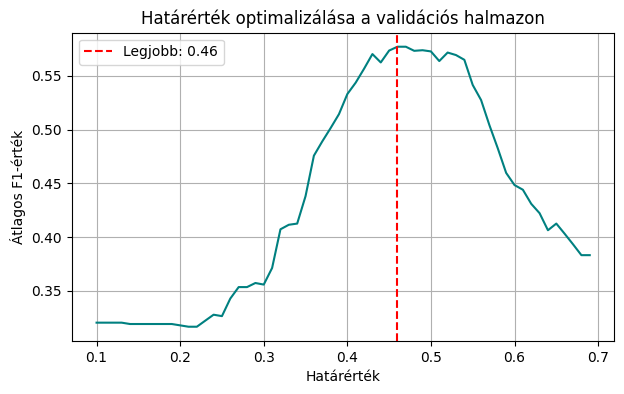


Validációs halmaz eredményei:
              precision    recall  f1-score   support

           0       0.62      0.53      0.57       195
           1       0.54      0.63      0.59       174

    accuracy                           0.58       369
   macro avg       0.58      0.58      0.58       369
weighted avg       0.58      0.58      0.58       369



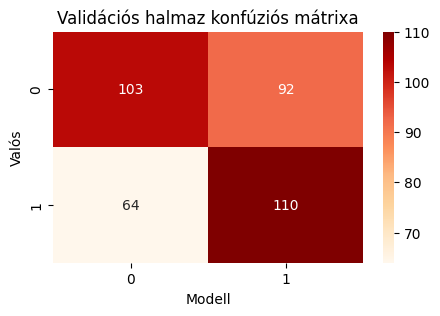

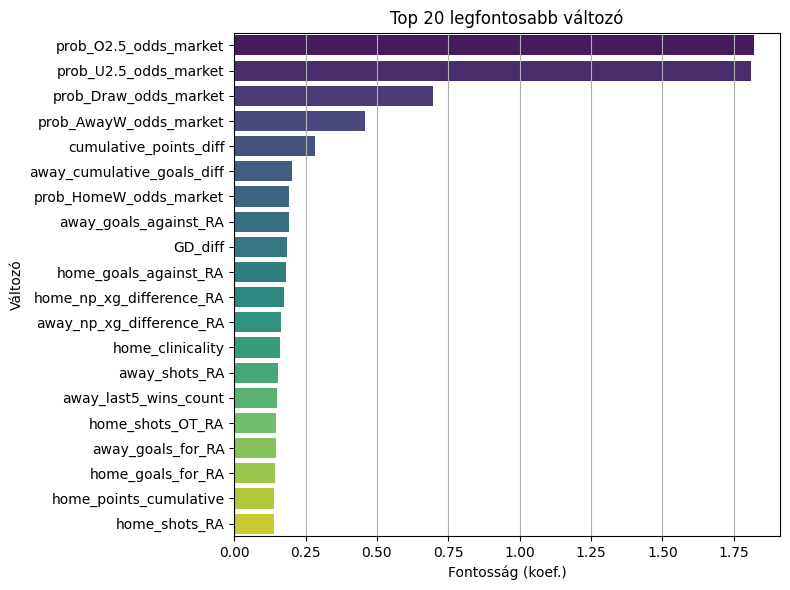


Teszt halmaz eredményei:
              precision    recall  f1-score   support

           0       0.66      0.58      0.62       198
           1       0.58      0.66      0.62       173

    accuracy                           0.62       371
   macro avg       0.62      0.62      0.62       371
weighted avg       0.62      0.62      0.62       371



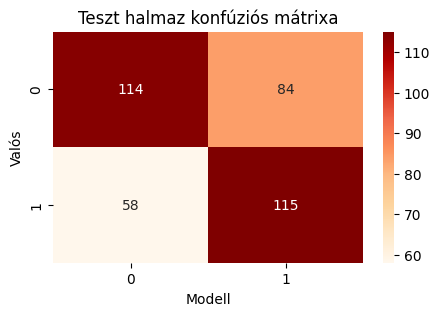

In [480]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


la_liga_tuned_UO, sp_lr_uo, la_liga_features_UO = logistic_regression_tuning_underover(
    la_liga, 
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 3327)
teszt halmaz:  (i: 3328 -> 3697)

Best threshold: 0.47, Best F1: 0.6431


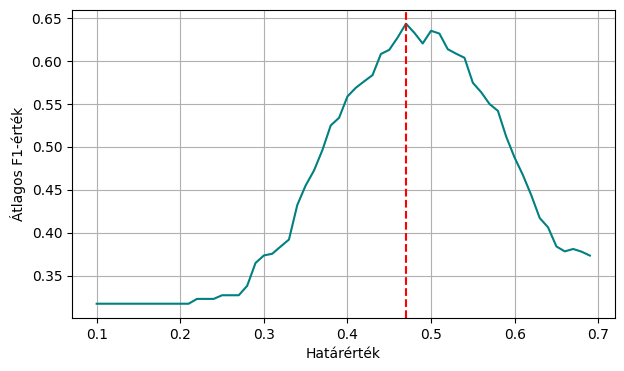

              precision    recall  f1-score   support

           0       0.68      0.62      0.65       198
           1       0.61      0.67      0.64       172

    accuracy                           0.64       370
   macro avg       0.64      0.64      0.64       370
weighted avg       0.65      0.64      0.64       370



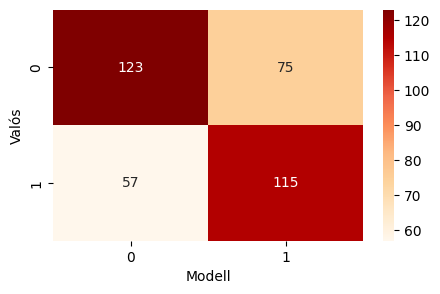

In [222]:
# target_col = 'target_o2.5'
# drop = ['target_home_win', 'target_away_win', 'target_draw',
#        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

# la_liga_test_UO = logistic_regression_test_underover(
#     la_liga,
#     target_col,
#     drop,
#     odds,
#     la_liga_params_UO
# )

In [481]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(la_liga_tuned_UO, stake=1)

ROI: 6.95%


>0% profit 25 fordulóban


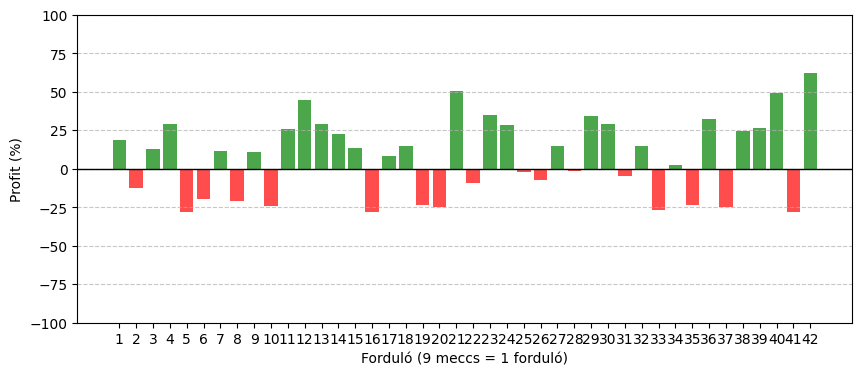

In [482]:
ROI_sim_UO(la_liga_tuned_UO, round_size=9)

## Ligue 1


Tanító halmaz indexek: (i: 1 -> 2816)
Validációs halmaz:  (i: 2817 -> 3168)
Teszt halmaz:  (i: 3169 -> 3521)
Hyperparaméterek hangolása...

Legjobb hiperparaméterek:
C: 429.8855215124967
class_weight: balanced
max_iter: 500
penalty: l1
solver: liblinear

Legjobb threshold: 0.57, Legjobb F1: 0.5479


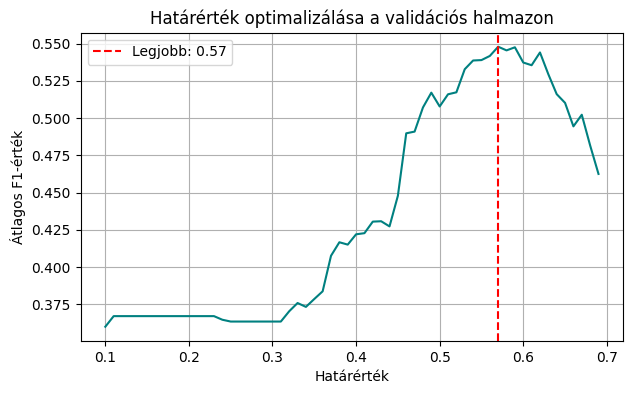


Validációs halmaz eredményei:
              precision    recall  f1-score   support

           0       0.49      0.59      0.53       154
           1       0.62      0.52      0.56       198

    accuracy                           0.55       352
   macro avg       0.55      0.55      0.55       352
weighted avg       0.56      0.55      0.55       352



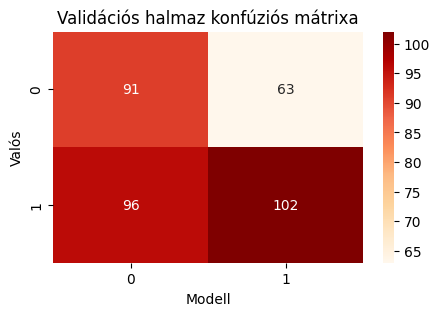

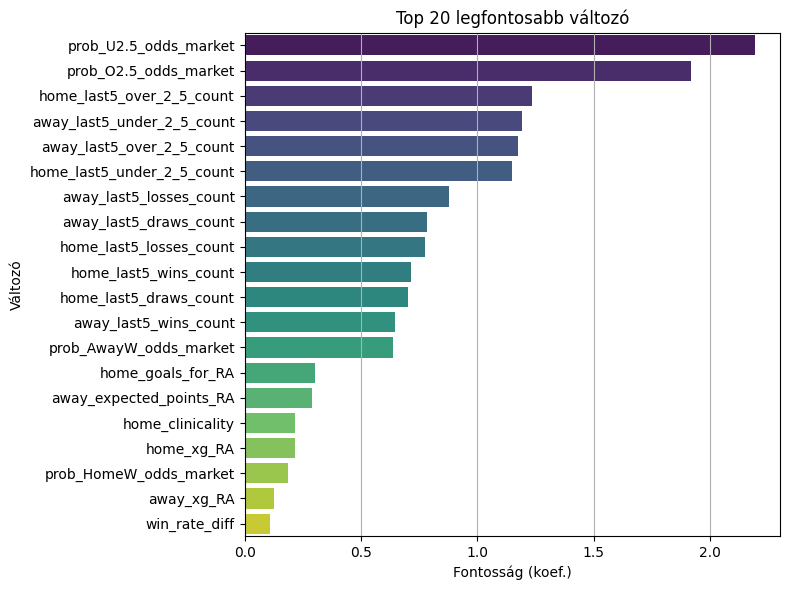


Teszt halmaz eredményei:
              precision    recall  f1-score   support

           0       0.50      0.58      0.54       163
           1       0.58      0.50      0.54       190

    accuracy                           0.54       353
   macro avg       0.54      0.54      0.54       353
weighted avg       0.54      0.54      0.54       353



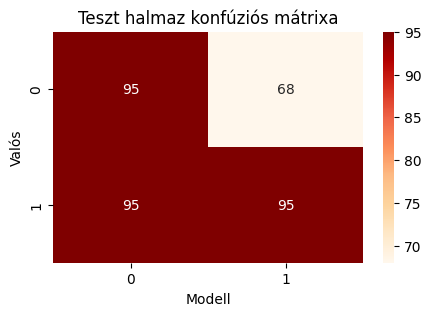

In [483]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


ligue_1_tuned_UO, fr_lr_uo, ligue_1_features_UO = logistic_regression_tuning_underover(
    ligue_1,  
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 3169)
teszt halmaz:  (i: 3170 -> 3521)

Best threshold: 0.53, Best F1: 0.5484


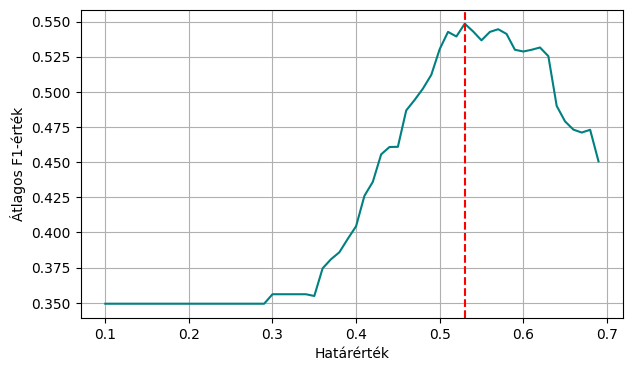

              precision    recall  f1-score   support

           0       0.52      0.48      0.50       163
           1       0.58      0.62      0.60       189

    accuracy                           0.55       352
   macro avg       0.55      0.55      0.55       352
weighted avg       0.55      0.55      0.55       352



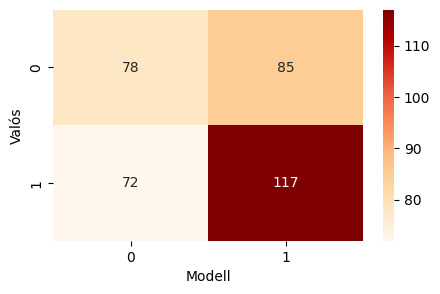

In [226]:
# target_col = 'target_o2.5'
# drop = ['target_home_win', 'target_away_win', 'target_draw',
#        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
# odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

# ligue_1_test_UO = logistic_regression_test_underover(
#     ligue_1,
#     target_col,
#     drop,
#     odds,
#     ligue_1_params_UO
# )

In [484]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(ligue_1_tuned_UO, stake=1)

ROI: -6.65%


>0% profit 15 fordulóban


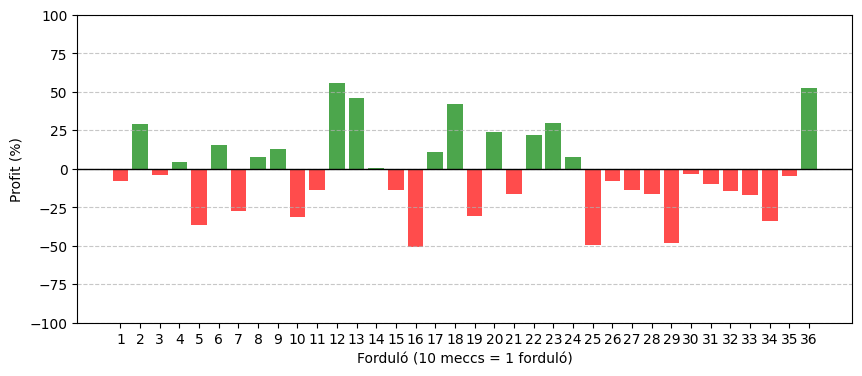

In [228]:
ROI_sim_UO(ligue_1_test_UO, round_size=10)

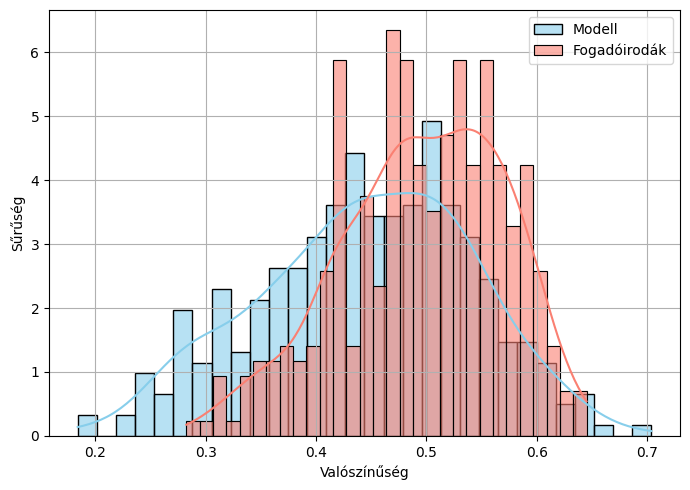

In [303]:
prob_dist_uo(ligue_1_test_UO)

## Kombinált


tanító halmaz indexek: (i: 1 -> 13971)
validációs halmaz:  (i: 13972 -> 15717)
teszt halmaz:  (i: 15718 -> 17464)

Legjobb threshold: 0.53, Legjobb F1: 0.5785


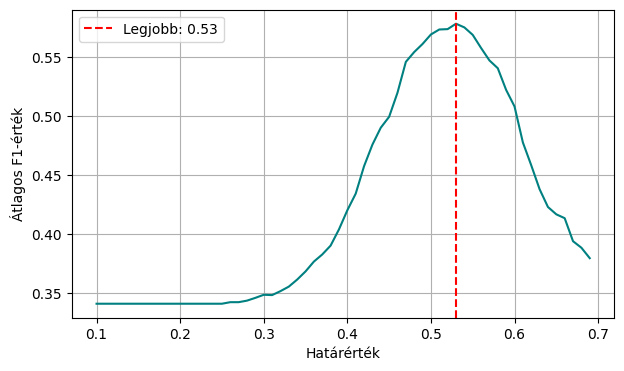

              precision    recall  f1-score   support

           0       0.56      0.60      0.58       843
           1       0.60      0.55      0.58       903

    accuracy                           0.58      1746
   macro avg       0.58      0.58      0.58      1746
weighted avg       0.58      0.58      0.58      1746



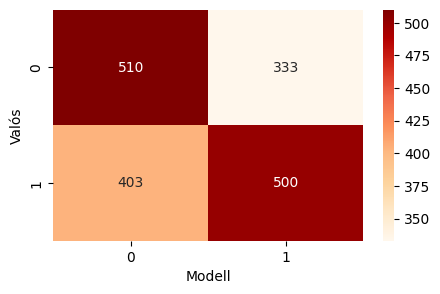

['prob_O2.5_odds_market', 'prob_U2.5_odds_market', 'home_goals_for_RA', 'away_np_xg_RA', 'away_expected_points_RA', 'away_xg_RA', 'home_clinicality', 'home_np_xg_difference_RA', 'home_goals_against_RA', 'away_shots_RA', 'away_goals_against_RA', 'away_cumulative_goals_diff', 'cumulative_points_diff', 'home_deep_completions_RA', 'prob_AwayW_odds_market', 'away_ppda_RA', 'away_deep_completions_RA', 'home_xg_RA', 'home_points_RA', 'away_last5_over_2_5_count']


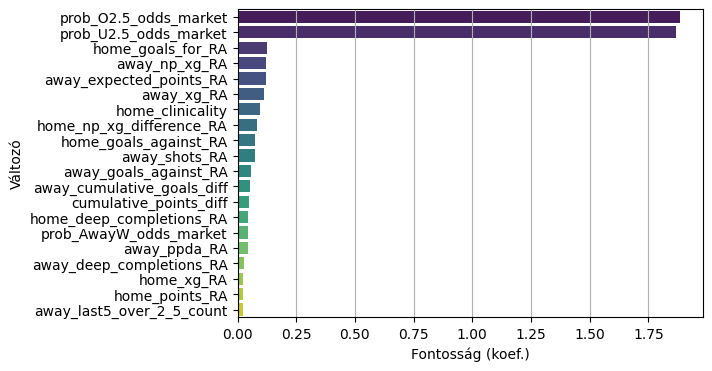

In [229]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market', 'U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market', 'prob_U2.5_odds_market', 'prob_O2.5_odds_market']


big5_tuned_UO, big5_params_UO, big5_features_UO = logistic_regression_tuning_underover(
    big5,  
    target_col,
    drop,
    odds
)


tanító halmaz indexek: (i: 1 -> 15718)
teszt halmaz:  (i: 15719 -> 17464)

Best threshold: 0.51, Best F1: 0.5941


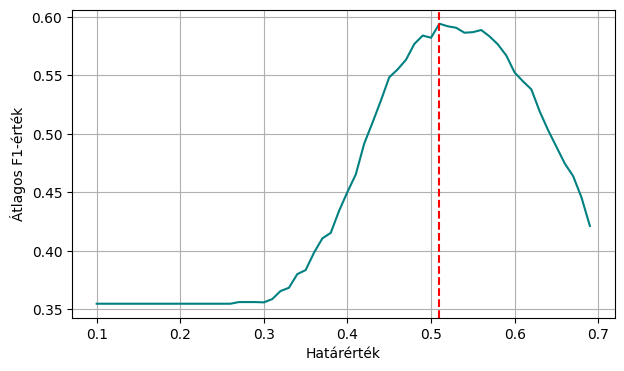

              precision    recall  f1-score   support

           0       0.57      0.49      0.53       786
           1       0.63      0.70      0.66       960

    accuracy                           0.60      1746
   macro avg       0.60      0.59      0.59      1746
weighted avg       0.60      0.60      0.60      1746



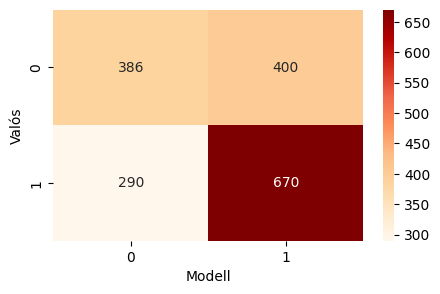

In [230]:
target_col = 'target_o2.5'
drop = ['target_home_win', 'target_away_win', 'target_draw',
       'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market','U2.5_odds_market', 'O2.5_odds_market']
odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

big5_test_UO = logistic_regression_test_underover(
    big5,
    target_col,
    drop,
    odds,
    big5_params_UO
)

In [231]:
roi, df_profit, df_loss, pred_odds = betting_logreg_underover(big5_test_UO, stake=1)

ROI: -0.27%


>0% profit 18 fordulóban


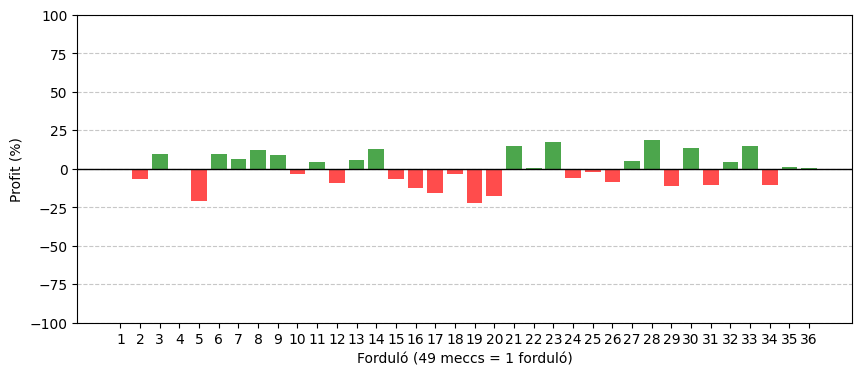

In [236]:
ROI_sim_UO(big5_test_UO, round_size=49)

# összehasonlitas

## UO

### PL

### Fgv-k definiálása

In [661]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def generalization_underover(model, df_dict, target_col, drop_cols=[], odds=[]):
    results = {}

    for league_name, df in df_dict.items():
        print(f"\n=== {league_name} ===")

        df_cleaned = df.dropna().reset_index(drop=True)

        train_n = int(len(df_cleaned) * 0.8)
        val_n = int(len(df_cleaned) * 0.1)

        df_train = df_cleaned[:train_n]
        df_val = df_cleaned[train_n:train_n + val_n]
        df_test = df_cleaned[train_n + val_n:]

        X_train_raw = df_train.drop(columns=[target_col] + drop_cols)
        y_train = df_train[target_col]

        X_val_raw = df_val.drop(columns=[target_col] + drop_cols)
        y_val = df_val[target_col]

        X_test_raw = df_test.drop(columns=[target_col] + drop_cols)
        y_test = df_test[target_col]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_raw.drop(columns=odds))
        X_val_scaled = scaler.transform(X_val_raw.drop(columns=odds))
        X_test_scaled = scaler.transform(X_test_raw.drop(columns=odds))

        X_train = np.hstack((X_train_scaled, X_train_raw[odds].values))
        X_val = np.hstack((X_val_scaled, X_val_raw[odds].values))
        X_test = np.hstack((X_test_scaled, X_test_raw[odds].values))

        model.fit(X_train, y_train)

        probs_val = model.predict_proba(X_val)
        thresholds = np.arange(0.4, 0.6, 0.01)
        f1_scores = []

        for t in thresholds:
            preds_val = (probs_val[:, 1] >= t).astype(int)
            f1_scores.append(f1_score(y_val, preds_val, average='macro'))

        best_threshold = thresholds[np.argmax(f1_scores)]
        best_f1 = max(f1_scores)

        print(f"Legjobb küszöbérték a validációs halmazon: {best_threshold:.2f}")
        print(f"Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: {best_f1:.4f}")

        probs_test = model.predict_proba(X_test)
        preds_test = (probs_test[:, 1] >= best_threshold).astype(int)

        print(classification_report(y_test, preds_test))

        plt.figure(figsize=(4, 3))
        cm = confusion_matrix(y_test, preds_test)
        sns.heatmap(cm, annot=True, fmt="d", cmap="OrRd", xticklabels=['0', '1'], yticklabels=['0', '1'])
        plt.xlabel("Modell")
        plt.ylabel("Valós")
        plt.title(league_name)
        plt.tight_layout()
        plt.show()

        df_result = df_test.copy()
        df_result['P_0'] = probs_test[:, 0]
        df_result['P_1'] = probs_test[:, 1]
        df_result['Predicted'] = preds_test

        results[league_name] = df_result

    return results

def logreg_dict_underover(model, df_dict, target_col, drop_cols=[], odds=[]):
    results = generalization_underover(model, df_dict, target_col, drop_cols, odds)
    return results

In [662]:
def generalization_betting(df_dict, stake=1):

    results = {}

    for league_name, df in df_dict.items():
        df = df.copy() 

        df['Profit'] = df.apply(
            lambda row: (stake * row['O2.5_odds_market'] - stake) if row['Predicted'] == 1 and row['target_o2.5'] == 1 else
                         (stake * row['U2.5_odds_market'] - stake) if row['Predicted'] == 0 and row['target_o2.5'] == 0 else
                         -stake, axis=1
        )

        total_profit = df['Profit'].sum()
        total_bets = len(df)

        roi = (total_profit / (total_bets * stake)) * 100
        
        print(f"{league_name} - ROI: {roi:.2f}%")

        df_profit = df[df['target_o2.5'] == df['Predicted']]
        df_loss = df[df['target_o2.5'] != df['Predicted']]

        results[league_name] = {
            'ROI': roi,
            'df_profit': df_profit,
            'df_loss': df_loss,
            'df': df
        }

    return results

### PL


=== La Liga ===
Legjobb küszöbérték a validációs halmazon: 0.45
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5848
              precision    recall  f1-score   support

           0       0.66      0.54      0.59       198
           1       0.56      0.68      0.62       173

    accuracy                           0.60       371
   macro avg       0.61      0.61      0.60       371
weighted avg       0.61      0.60      0.60       371



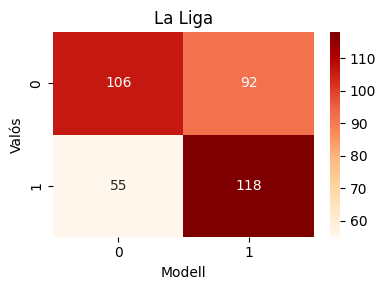


=== Ligue 1 ===
Legjobb küszöbérték a validációs halmazon: 0.58
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5524
              precision    recall  f1-score   support

           0       0.50      0.69      0.58       163
           1       0.61      0.42      0.50       190

    accuracy                           0.54       353
   macro avg       0.56      0.55      0.54       353
weighted avg       0.56      0.54      0.54       353



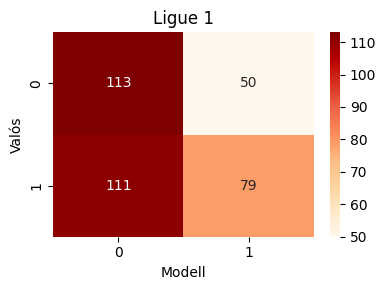


=== Serie A ===
Legjobb küszöbérték a validációs halmazon: 0.51
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5358
              precision    recall  f1-score   support

           0       0.55      0.71      0.62       182
           1       0.58      0.41      0.48       177

    accuracy                           0.56       359
   macro avg       0.57      0.56      0.55       359
weighted avg       0.57      0.56      0.55       359



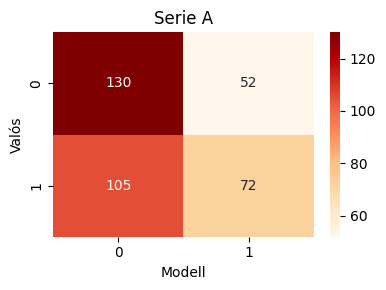


=== Bundesliga ===
Legjobb küszöbérték a validációs halmazon: 0.56
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5171
              precision    recall  f1-score   support

           0       0.57      0.35      0.43       112
           1       0.68      0.84      0.75       185

    accuracy                           0.66       297
   macro avg       0.63      0.60      0.59       297
weighted avg       0.64      0.66      0.63       297



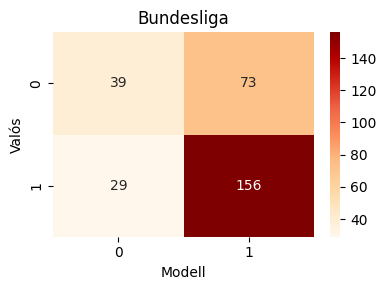

In [659]:
pl_dict = {
    'La Liga': la_liga,
    'Ligue 1': ligue_1,
    'Serie A': serie_a,
    'Bundesliga': bundesliga
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_pl = logreg_dict_underover(
    model=pl_lr_uo, 
    df_dict=pl_dict,
    target_col='target_o2.5',  
    drop_cols=drop,  
    odds=odds 
)

In [660]:
general_betting_pl = generalization_betting(results_pl, stake=1)

La Liga - ROI: 4.16%
Ligue 1 - ROI: -4.60%
Serie A - ROI: -1.87%
Bundesliga - ROI: 6.70%


### bundesliga


=== La Liga ===
Legjobb küszöbérték a validációs halmazon: 0.46
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5902
              precision    recall  f1-score   support

           0       0.69      0.59      0.64       198
           1       0.60      0.69      0.64       173

    accuracy                           0.64       371
   macro avg       0.64      0.64      0.64       371
weighted avg       0.65      0.64      0.64       371



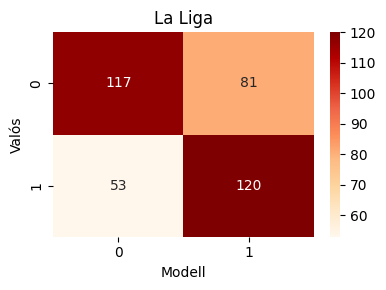


=== Ligue 1 ===
Legjobb küszöbérték a validációs halmazon: 0.52
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5818
              precision    recall  f1-score   support

           0       0.51      0.50      0.50       163
           1       0.58      0.58      0.58       190

    accuracy                           0.54       353
   macro avg       0.54      0.54      0.54       353
weighted avg       0.54      0.54      0.54       353



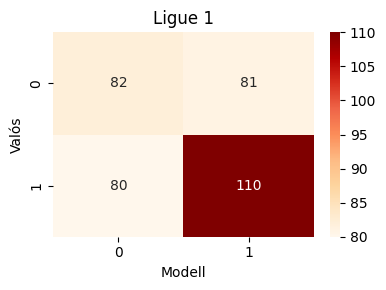


=== Serie A ===
Legjobb küszöbérték a validációs halmazon: 0.52
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5639
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       182
           1       0.63      0.47      0.54       177

    accuracy                           0.60       359
   macro avg       0.61      0.60      0.59       359
weighted avg       0.61      0.60      0.60       359



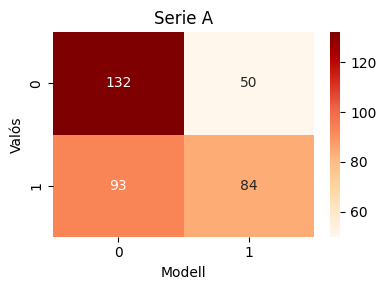


=== Premier League ===
Legjobb küszöbérték a validációs halmazon: 0.53
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5935
              precision    recall  f1-score   support

           0       0.36      0.26      0.30       129
           1       0.66      0.76      0.70       242

    accuracy                           0.58       371
   macro avg       0.51      0.51      0.50       371
weighted avg       0.55      0.58      0.56       371



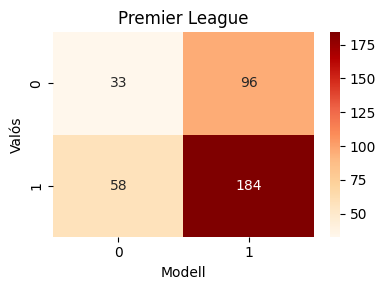

In [671]:
bundesliga_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Serie A':serie_a,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_bundeslgia = logreg_dict_underover(
    model=gm_lr_uo,
    df_dict=bundesliga_dict,
    target_col='target_o2.5',
    drop_cols=drop
)

In [672]:
general_betting_bundesliga = generalization_betting(results_bundeslgia, stake=1)

La Liga - ROI: 6.61%
Ligue 1 - ROI: -7.61%
Serie A - ROI: 3.53%
Premier League - ROI: -7.63%


### serie a


=== La Liga ===
Legjobb küszöbérték a validációs halmazon: 0.48
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5829
              precision    recall  f1-score   support

           0       0.65      0.73      0.69       198
           1       0.64      0.54      0.59       173

    accuracy                           0.64       371
   macro avg       0.64      0.64      0.64       371
weighted avg       0.64      0.64      0.64       371



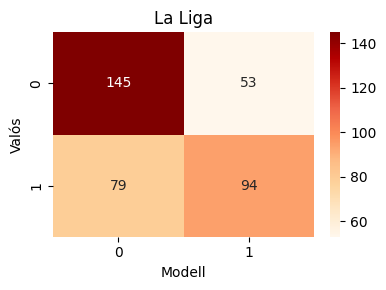


=== Ligue 1 ===
Legjobb küszöbérték a validációs halmazon: 0.56
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5540
              precision    recall  f1-score   support

           0       0.51      0.61      0.55       163
           1       0.59      0.49      0.54       190

    accuracy                           0.54       353
   macro avg       0.55      0.55      0.54       353
weighted avg       0.55      0.54      0.54       353



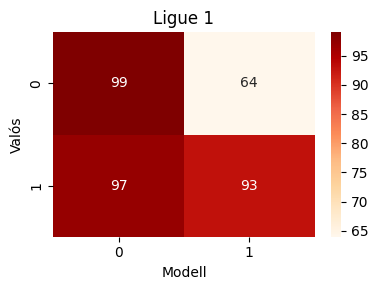


=== Bundesliga ===
Legjobb küszöbérték a validációs halmazon: 0.54
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5176
              precision    recall  f1-score   support

           0       0.51      0.17      0.26       112
           1       0.64      0.90      0.75       185

    accuracy                           0.63       297
   macro avg       0.58      0.54      0.50       297
weighted avg       0.59      0.63      0.56       297



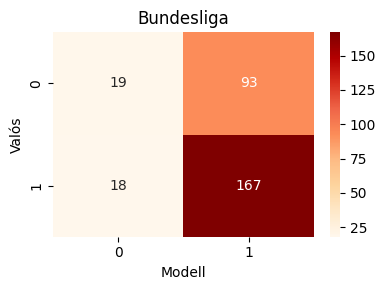


=== Premier League ===
Legjobb küszöbérték a validációs halmazon: 0.53
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5593
              precision    recall  f1-score   support

           0       0.37      0.28      0.32       129
           1       0.66      0.75      0.70       242

    accuracy                           0.58       371
   macro avg       0.52      0.51      0.51       371
weighted avg       0.56      0.58      0.57       371



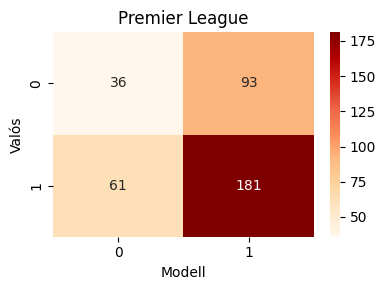

In [667]:
seriea_dict = {
    'La Liga': la_liga,
    'Ligue 1':ligue_1,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

results_seriea = logreg_dict_underover(
    model=it_lr_uo,
    df_dict=seriea_dict,
    target_col='target_o2.5',
    drop_cols=drop
)

In [669]:
general_betting_seriea = generalization_betting(results_seriea, stake=1)

La Liga - ROI: 10.88%
Ligue 1 - ROI: -5.44%
Bundesliga - ROI: -0.97%
Premier League - ROI: -5.62%


### laliga 


=== Serie A ===
Legjobb küszöbérték a validációs halmazon: 0.49
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5323
              precision    recall  f1-score   support

           0       0.55      0.73      0.63       182
           1       0.59      0.40      0.48       177

    accuracy                           0.57       359
   macro avg       0.57      0.56      0.55       359
weighted avg       0.57      0.57      0.55       359



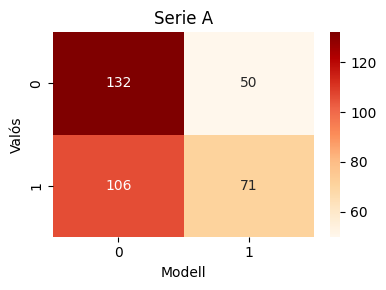


=== Ligue 1 ===
Legjobb küszöbérték a validációs halmazon: 0.56
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5483
              precision    recall  f1-score   support

           0       0.50      0.61      0.55       163
           1       0.59      0.48      0.53       190

    accuracy                           0.54       353
   macro avg       0.55      0.55      0.54       353
weighted avg       0.55      0.54      0.54       353



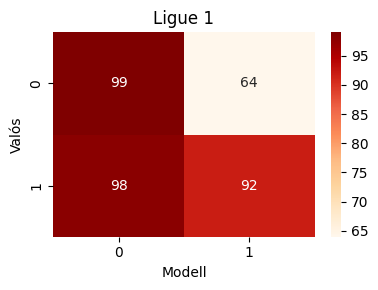


=== Bundesliga ===
Legjobb küszöbérték a validációs halmazon: 0.57
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5126
              precision    recall  f1-score   support

           0       0.55      0.32      0.40       112
           1       0.67      0.84      0.75       185

    accuracy                           0.64       297
   macro avg       0.61      0.58      0.57       297
weighted avg       0.62      0.64      0.62       297



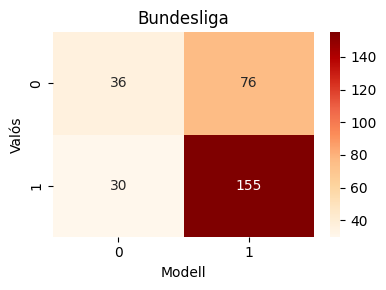


=== Premier League ===
Legjobb küszöbérték a validációs halmazon: 0.49
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5558
              precision    recall  f1-score   support

           0       0.43      0.20      0.28       129
           1       0.67      0.86      0.75       242

    accuracy                           0.63       371
   macro avg       0.55      0.53      0.51       371
weighted avg       0.59      0.63      0.59       371



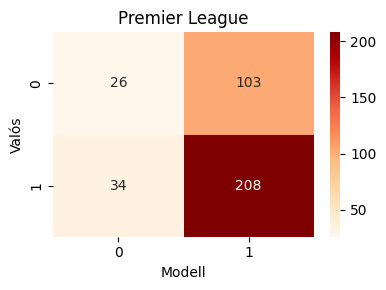

In [673]:
laliga_dict = {
    'Serie A': serie_a,
    'Ligue 1':ligue_1,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

results_laliga = logreg_dict_underover(
    model=sp_lr_uo,
    df_dict=laliga_dict,
    target_col='target_o2.5',
    drop_cols=drop
)

In [674]:
general_betting_laliga = generalization_betting(results_laliga, stake=1)

Serie A - ROI: -1.27%
Ligue 1 - ROI: -5.94%
Bundesliga - ROI: 4.04%
Premier League - ROI: 1.16%


### ligue 1


=== Serie A ===
Legjobb küszöbérték a validációs halmazon: 0.43
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5286
              precision    recall  f1-score   support

           0       0.56      0.68      0.61       182
           1       0.57      0.45      0.50       177

    accuracy                           0.56       359
   macro avg       0.56      0.56      0.56       359
weighted avg       0.56      0.56      0.56       359



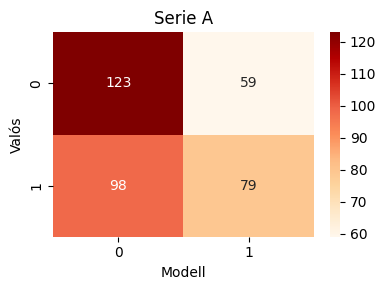


=== La Liga ===
Legjobb küszöbérték a validációs halmazon: 0.45
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5852
              precision    recall  f1-score   support

           0       0.67      0.60      0.63       198
           1       0.59      0.66      0.62       173

    accuracy                           0.63       371
   macro avg       0.63      0.63      0.63       371
weighted avg       0.63      0.63      0.63       371



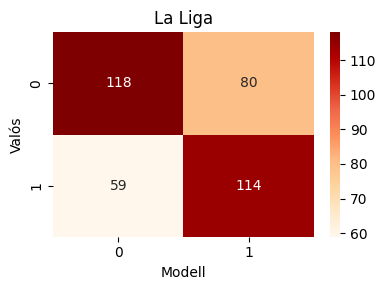


=== Bundesliga ===
Legjobb küszöbérték a validációs halmazon: 0.57
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5316
              precision    recall  f1-score   support

           0       0.50      0.54      0.52       112
           1       0.70      0.67      0.69       185

    accuracy                           0.62       297
   macro avg       0.60      0.60      0.60       297
weighted avg       0.63      0.62      0.62       297



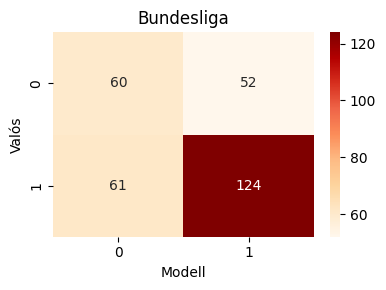


=== Premier League ===
Legjobb küszöbérték a validációs halmazon: 0.52
Maximum csoportos F1 átlag a validációson ezzel a küszöbbel: 0.5532
              precision    recall  f1-score   support

           0       0.36      0.29      0.32       129
           1       0.66      0.72      0.69       242

    accuracy                           0.57       371
   macro avg       0.51      0.51      0.51       371
weighted avg       0.55      0.57      0.56       371



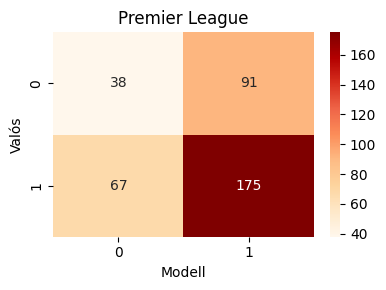

In [675]:
ligue1_dict = {
    'Serie A': serie_a,
    'La Liga':la_liga,
    'Bundesliga':bundesliga,
    'Premier League':premier_league
}

drop = ['target_home_win', 'target_away_win', 'target_draw',
        'HomeW_odds_market', 'AwayW_odds_market', 'Draw_odds_market',
        'U2.5_odds_market', 'O2.5_odds_market']

results_ligue1 = logreg_dict_underover(
    model=fr_lr_uo,
    df_dict=ligue1_dict,
    target_col='target_o2.5',
    drop_cols=drop
)

In [676]:
general_betting_ligue1 = generalization_betting(results_ligue1, stake=1)

Serie A - ROI: -2.20%
La Liga - ROI: 7.64%
Bundesliga - ROI: 5.22%
Premier League - ROI: -7.28%


## FTR

### Fgv-k definiálása

In [634]:
def logreg_general(df, df_test, drop_cols_home=[], drop_cols_away=[], odds=[], best_params_home={}, best_params_away={},
                  df_name='', df_test_name=''):
  
    df = df.dropna().reset_index(drop=True)
    df_test = df_test.dropna().reset_index(drop=True)


    """
    Szétválasztom a train, val és test seteket.
    A train az első 8 szezon.
    A val a 9.
    A test a 10. A lényeg, hogy a test másik ligából jön.

    Pl. Ha a PL-t hasonlítom össze a többi ligával, akkor
        A train a PL első 8 szezonja,  ezen történik a CV, hiperpm-hangolás
        A val a 9. szezonja, ezen történik a határérték kiválasztása - előrejelzek ezen is, majd azt
        a határértéket választom, amely maximalizálja a val halmazon az F1 macrot.
        A test pedig minden más liga 10. szezonja. Ezen csak előrejelzek, és a szavazókkal osztályzok - azt a határértéket használom, 
        amit a valon maximalizáltam. 
    """
    
    train_n = int(round(len(df) * 0.8, 0)) 
    train_set = df.iloc[:train_n].copy()
    
    val_set = df.iloc[train_n:].copy()
    
    test_n = int(round(len(df_test) * 0.1, 0))
    df_test = df_test.tail(test_n).copy()

    print(f"train_set indexek: {train_set.index[0]}–{train_set.index[-1]} | forrás: {df_name}")
    print(f"val_set indexek: {val_set.index[0]}–{val_set.index[-1]} | forrás: {df_name}")
    print(f"test_set indexek: {df_test.index[0]}–{df_test.index[-1]} | forrás: {df_test_name}")

    """
    Tanítás a train adatokon, a CV során lementett legjobb hiperparaméterekkel.
    Külön a home és away - nincs okom feltételezni, hogy ugyanazok lennének a hiperparaméterek.
    """
    
    lr_home, scaler_home = logreg_validation(
        train_set, "target_home_win", drop_cols_home, odds, best_params_home
    )

    lr_away, scaler_away = logreg_validation(
        train_set, "target_away_win", drop_cols_away, odds, best_params_away
    )

    """
    Normalizálom a validációs halmazt, a vszg-k nélkül, ezek a normalizálás után visszakerülnek.
    """
    
    X_val_home = val_set.drop(columns=drop_cols_home + ["target_home_win"])
    X_val_away = val_set.drop(columns=drop_cols_away + ["target_away_win"])

    X_val_home_odds = X_val_home[odds].copy()
    X_val_away_odds = X_val_away[odds].copy()

    X_val_home_no_odds = X_val_home.drop(columns=odds)
    X_val_away_no_odds = X_val_away.drop(columns=odds)

    X_val_home_scaled = scaler_home.transform(X_val_home_no_odds)
    X_val_away_scaled = scaler_away.transform(X_val_away_no_odds)

    X_val_home_scaled = pd.DataFrame(X_val_home_scaled, columns=X_val_home_no_odds.columns)
    X_val_away_scaled = pd.DataFrame(X_val_away_scaled, columns=X_val_away_no_odds.columns)

    X_val_home_scaled = pd.concat([X_val_home_scaled.reset_index(drop=True), 
                                   X_val_home_odds.reset_index(drop=True)], axis=1)
    X_val_away_scaled = pd.concat([X_val_away_scaled.reset_index(drop=True), 
                                   X_val_away_odds.reset_index(drop=True)], axis=1)

    """
    Előrejelzek a val halmazon, definiálom a vszgket, 0-1 között fixálom őket.
    """
    
    prob_home_win_val = lr_home.predict_proba(X_val_home_scaled)[:, 1]
    prob_away_win_val = lr_away.predict_proba(X_val_away_scaled)[:, 1]

    prob_home_win_val = np.maximum(prob_home_win_val, 0)
    prob_away_win_val = np.maximum(prob_away_win_val, 0)
    prob_draw_val = np.maximum(1 - (prob_home_win_val + prob_away_win_val), 0)

    total_prob_val = prob_home_win_val + prob_away_win_val + prob_draw_val
    prob_home_win_val /= total_prob_val
    prob_away_win_val /= total_prob_val
    prob_draw_val /= total_prob_val

    """
    Küszöb/határérték megállapítása.
    Tárolom a macrot és az F1-t, végigiterálok a thresholds halmazán, frissítem az értéket, 
    ha magasabb, mint az aktuálisan maximum.
    Ez csak a validációs előrejelzésen történik.
    """
    
    best_f1_macro = 0
    best_threshold = 0.15
    thresholds = np.arange(0.01, 0.30, 0.01)

    true_outcomes_val = []
    for i in range(len(val_set)):
        if val_set.iloc[i]["target_home_win"] == 1:
            true_outcomes_val.append("Home Win")
        elif val_set.iloc[i]["target_away_win"] == 1:
            true_outcomes_val.append("Away Win")
        else:
            true_outcomes_val.append("Draw")

    for threshold in thresholds:
        predictions = []
        for i in range(len(val_set)):
            home_prob = prob_home_win_val[i]
            away_prob = prob_away_win_val[i]

            if abs(home_prob - away_prob) < threshold:
                predictions.append("Draw")
            elif home_prob > away_prob:
                predictions.append("Home Win")
            else:
                predictions.append("Away Win")

        f1_macro = f1_score(true_outcomes_val, predictions, average='macro')

        if f1_macro > best_f1_macro:
            best_f1_macro = f1_macro
            best_threshold = threshold

    """
    Normalizálom a tesz halmazt, ugyanúgy, mint a valt.
    """
    
    X_test_home = df_test.drop(columns=["target_home_win"] + drop_cols_home)
    X_test_away = df_test.drop(columns=["target_away_win"] + drop_cols_away)

    X_test_home_odds = X_test_home[odds].copy()
    X_test_away_odds = X_test_away[odds].copy()

    X_test_home_no_odds = X_test_home.drop(columns=odds)
    X_test_away_no_odds = X_test_away.drop(columns=odds)

    X_test_home_scaled = scaler_home.transform(X_test_home_no_odds)
    X_test_away_scaled = scaler_away.transform(X_test_away_no_odds)

    X_test_home_scaled = pd.DataFrame(X_test_home_scaled, columns=X_test_home_no_odds.columns)
    X_test_away_scaled = pd.DataFrame(X_test_away_scaled, columns=X_test_away_no_odds.columns)

    X_test_home_scaled = pd.concat([X_test_home_scaled.reset_index(drop=True), X_test_home_odds.reset_index(drop=True)], axis=1)
    X_test_away_scaled = pd.concat([X_test_away_scaled.reset_index(drop=True), X_test_away_odds.reset_index(drop=True)], axis=1)

    """
    Előrejelzés a külső ligák teszthalmazán.
    Azért a 10., mert így konzisztensek lesznek az összehasoníltások, hiszen a teszthalmaz minden
    eddigi esetben a 23-24-es szezon volt.

    Ugyanúgy járok el a vszg-kel, mint a val halmazon
    """
    
    model_home_preds = lr_home.predict(X_test_home_scaled)
    model_away_preds = lr_away.predict(X_test_away_scaled)

    prob_home_win_test = lr_home.predict_proba(X_test_home_scaled)[:, 1]
    prob_away_win_test = lr_away.predict_proba(X_test_away_scaled)[:, 1]

    prob_home_win_test = np.maximum(prob_home_win_test, 0)
    prob_away_win_test = np.maximum(prob_away_win_test, 0)
    prob_draw_test = np.maximum(1 - (prob_home_win_test + prob_away_win_test), 0)

    total_prob_test = prob_home_win_test + prob_away_win_test + prob_draw_test
    prob_home_win_test /= total_prob_test
    prob_away_win_test /= total_prob_test
    prob_draw_test /= total_prob_test

    test_indices = df_test.index
    df_test.loc[test_indices, "model_home"] = model_home_preds
    df_test.loc[test_indices, "model_away"] = model_away_preds
    df_test.loc[test_indices, "prob_home_win"] = prob_home_win_test
    df_test.loc[test_indices, "prob_away_win"] = prob_away_win_test
    df_test.loc[test_indices, "prob_draw"] = prob_draw_test

    """
    Szavazó algoritmusok.

    Softnál döntetlen, ha a két kimenetel abszolút különbsége kisebb, mint a 
    validációs halmazon F1-et maximalizáló határérték.
    """
    
    def voting_hard(row):
        if row["model_home"] == 1 and row["model_away"] == 0:
            return "Home Win"
        elif row["model_away"] == 1 and row["model_home"] == 0:
            return "Away Win"
        elif row["model_home"] == 0 and row["model_away"] == 0:
            return "Draw"
        elif row["model_home"] == 1 and row["model_away"] == 1:
            return "Home Win"
        else:
            return "-"

    def voting_soft(row):
        prob_home_win = row['prob_home_win']
        prob_away_win = row['prob_away_win']

        if abs(prob_home_win - prob_away_win) < best_threshold:
            return "Draw"
        elif prob_home_win > prob_away_win:
            return "Home Win"
        elif prob_home_win < prob_away_win:
            return "Away Win"
        else:
            return "-"

    df_test["test_pred_hard"] = df_test.apply(voting_hard, axis=1)
    df_test["test_pred_soft"] = df_test.apply(voting_soft, axis=1)

    """
    Konf mx, ahol az eredmények mindig a 10. szezonokon értelmezendők
    """
    
    plt.figure(figsize=(5, 4))
    cm_home = confusion_matrix(df_test["target_home_win"], model_home_preds)
    sns.heatmap(cm_home, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem hazai Gy', 'Hazai Gy'], yticklabels=['Nem hazai Gy', 'Hazai Gy'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title(f"Hazai modell - {df_name} első 8 szezon, {df_test_name} 10.en tesztelve")
    plt.show()

    plt.figure(figsize=(5, 4))
    cm_away = confusion_matrix(df_test["target_away_win"], model_away_preds)
    sns.heatmap(cm_away, annot=True, fmt="d", cmap="Blues", xticklabels=['Nem vendég Gy', 'Vendég Gy'], yticklabels=['Nem vendég Gy', 'Vendég Gy'])
    plt.xlabel("Modell")
    plt.ylabel("Valós")
    plt.title(f"Vendég modell - {df_name} első 8 szezon, {df_test_name} 10.en tesztelve")
    plt.show()
    
    """
    Az a küszöbérték, amellyel a val halmazon max. lett az F1 csoportátlag - ugye ez kerül
    használatra a teszt halmazon.
    """
    
    print(f"Legjobb küszöbérték a validációs halmazon: {best_threshold:.2f}")

    return df_test, lr_home, lr_away


In [635]:
def logreg_dictionary(train_df, test_df_dict, drop_cols_home, drop_cols_away, odds,
                       best_params_home, best_params_away, train_name):
    results = {}

    """
    Ez a fgv. behívja a logreg_general()-t, és végigterál egy olyan
    dictionary-n, amelyben minden bajnokság benne van, kivéve az éppen tanulót,
    és a kombináltat.

    Ha a PL-n tanult modellt hasonlítom össze, akkor az input dictionaryben
    a Serie A, a Ligue 1, a Bundesliga és a La Liga lesznek. 

    Az előrejelzés ezeknek a 10. szezonján történik.
    """
    
    for league_name, test_df in test_df_dict.items():
        print(f"\n{'='*50}\nFuttatás {train_name} → {league_name}\n{'='*50}")
        
        test_predictions, lr_home, lr_away = logreg_general(
            train_df,
            test_df,
            drop_cols_home,
            drop_cols_away,
            odds,
            best_params_home,
            best_params_away,
            df_name=train_name,
            df_test_name=league_name
        )

        pred_odds = process_predictions(test_predictions)
        evaluation(pred_odds)

        roi_hard, roi_soft, df_profit_hard, df_loss_hard, df_profit_soft, df_loss_soft, pred_odds_soft = betting_logreg(
            pred_odds,
            stake=1
        )

        results[league_name] = {
            "test_predictions": test_predictions,
            "logreg_home": lr_home,
            "logreg_away": lr_away,
            "pred_odds": pred_odds,
            "roi_hard": roi_hard,
            "roi_soft": roi_soft,
            "df_profit_hard": df_profit_hard,
            "df_loss_hard": df_loss_hard,
            "df_profit_soft": df_profit_soft,
            "df_loss_soft": df_loss_soft,
            "pred_odds_soft": pred_odds_soft
        }

    return results

### PL


Futtatás Premier League → La Liga
train_set indexek: 0–2957 | forrás: Premier League
val_set indexek: 2958–3697 | forrás: Premier League
test_set indexek: 3327–3696 | forrás: La Liga


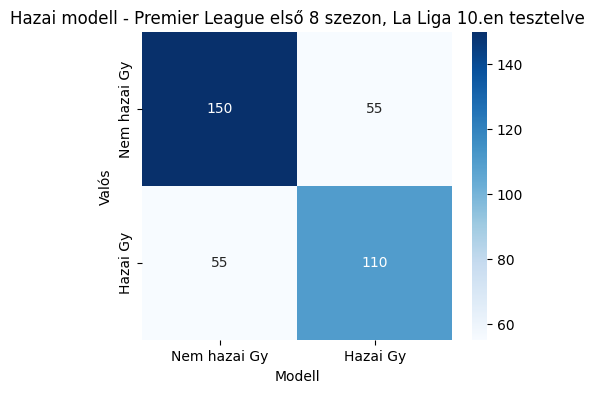

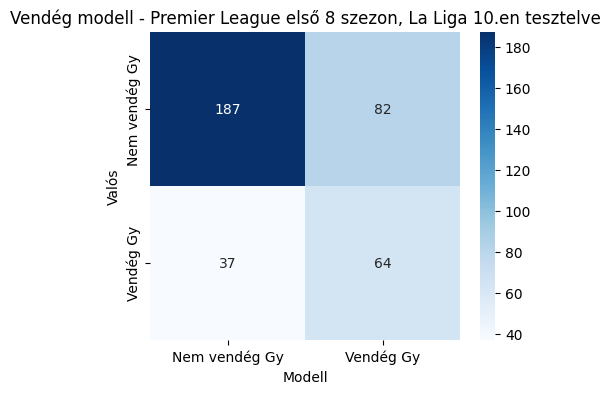

Legjobb küszöbérték a validációs halmazon: 0.20
Summary for HARD VOTING model


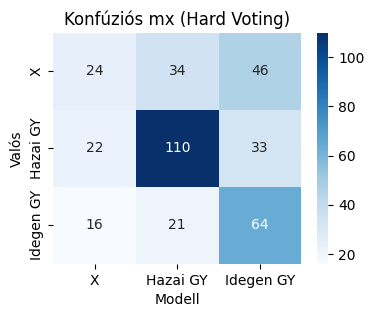

              precision    recall  f1-score   support

           0     0.3871    0.2308    0.2892       104
           1     0.6667    0.6667    0.6667       165
           2     0.4476    0.6337    0.5246       101

    accuracy                         0.5351       370
   macro avg     0.5004    0.5104    0.4935       370
weighted avg     0.5283    0.5351    0.5218       370


Summary for SOFT VOTING model


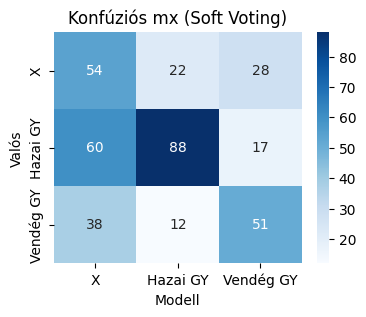

              precision    recall  f1-score   support

           0     0.3553    0.5192    0.4219       104
           1     0.7213    0.5333    0.6132       165
           2     0.5312    0.5050    0.5178       101

    accuracy                         0.5216       370
   macro avg     0.5359    0.5192    0.5176       370
weighted avg     0.5665    0.5216    0.5334       370

ROI hard : 7.33%
ROI soft : 14.52%

Futtatás Premier League → Ligue 1
train_set indexek: 0–2957 | forrás: Premier League
val_set indexek: 2958–3697 | forrás: Premier League
test_set indexek: 3169–3520 | forrás: Ligue 1


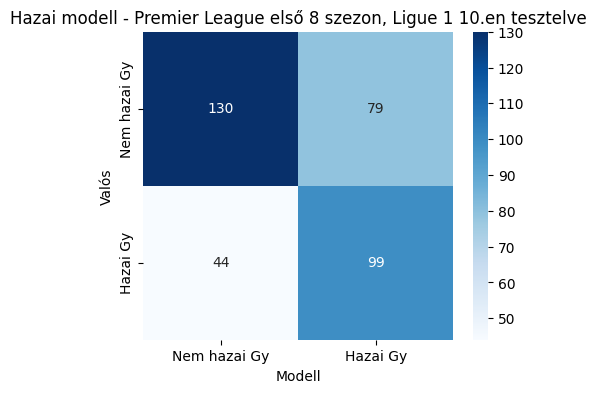

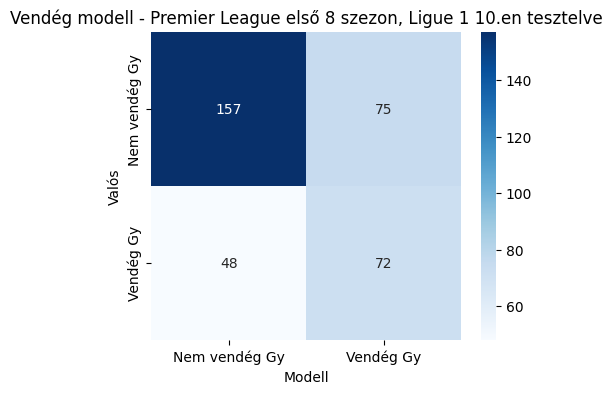

Legjobb küszöbérték a validációs halmazon: 0.20
Summary for HARD VOTING model


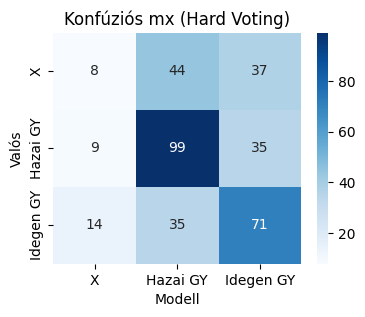

              precision    recall  f1-score   support

           0     0.2581    0.0899    0.1333        89
           1     0.5562    0.6923    0.6168       143
           2     0.4965    0.5917    0.5399       120

    accuracy                         0.5057       352
   macro avg     0.4369    0.4580    0.4300       352
weighted avg     0.4605    0.5057    0.4684       352


Summary for SOFT VOTING model


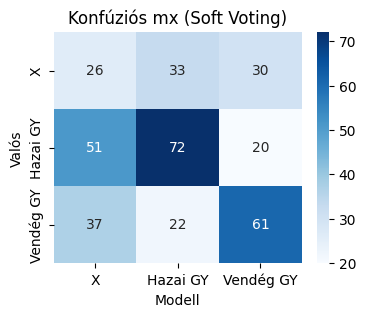

              precision    recall  f1-score   support

           0     0.2281    0.2921    0.2562        89
           1     0.5669    0.5035    0.5333       143
           2     0.5495    0.5083    0.5281       120

    accuracy                         0.4517       352
   macro avg     0.4482    0.4347    0.4392       352
weighted avg     0.4753    0.4517    0.4615       352

ROI hard : -0.38%
ROI soft : -7.79%

Futtatás Premier League → Serie A
train_set indexek: 0–2957 | forrás: Premier League
val_set indexek: 2958–3697 | forrás: Premier League
test_set indexek: 3220–3577 | forrás: Serie A


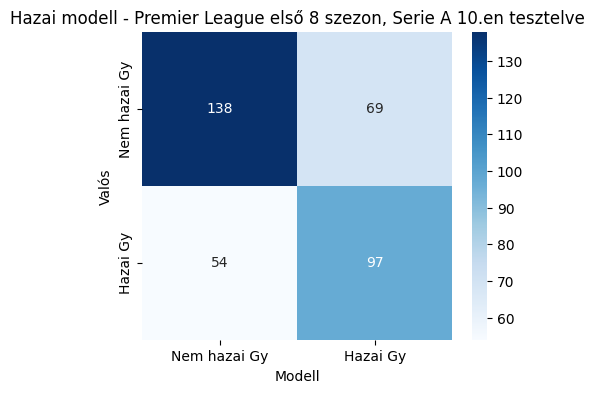

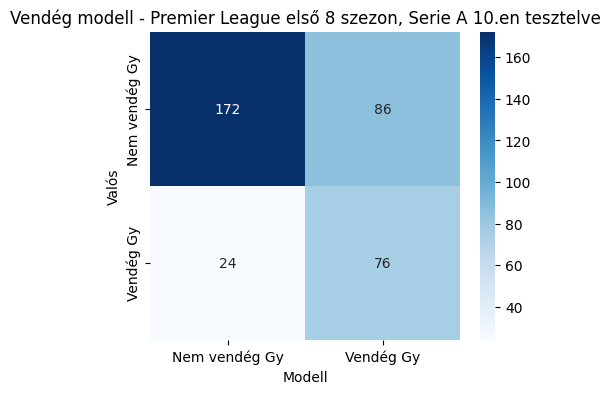

Legjobb küszöbérték a validációs halmazon: 0.20
Summary for HARD VOTING model


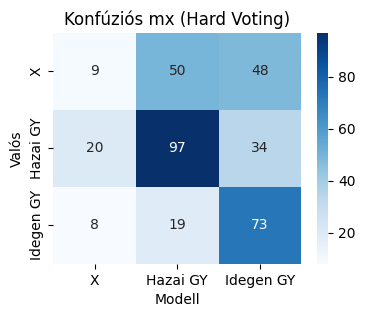

              precision    recall  f1-score   support

           0     0.2432    0.0841    0.1250       107
           1     0.5843    0.6424    0.6120       151
           2     0.4710    0.7300    0.5725       100

    accuracy                         0.5000       358
   macro avg     0.4328    0.4855    0.4365       358
weighted avg     0.4507    0.5000    0.4554       358


Summary for SOFT VOTING model


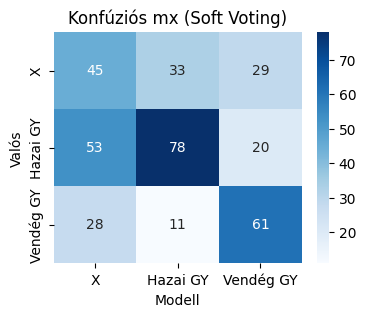

              precision    recall  f1-score   support

           0     0.3571    0.4206    0.3863       107
           1     0.6393    0.5166    0.5714       151
           2     0.5545    0.6100    0.5810       100

    accuracy                         0.5140       358
   macro avg     0.5170    0.5157    0.5129       358
weighted avg     0.5313    0.5140    0.5187       358

ROI hard : -3.77%
ROI soft : 9.01%

Futtatás Premier League → Bundesliga
train_set indexek: 0–2957 | forrás: Premier League
val_set indexek: 2958–3697 | forrás: Premier League
test_set indexek: 2673–2969 | forrás: Bundesliga


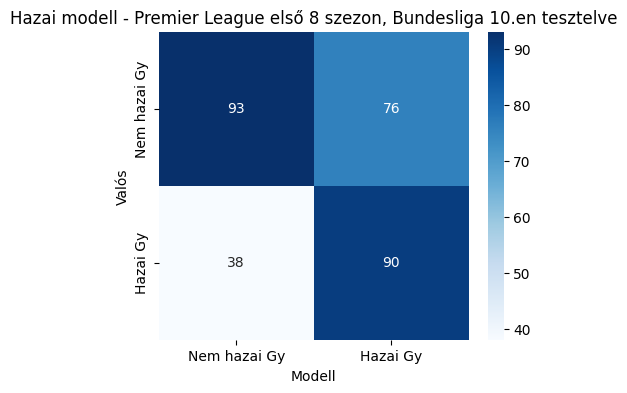

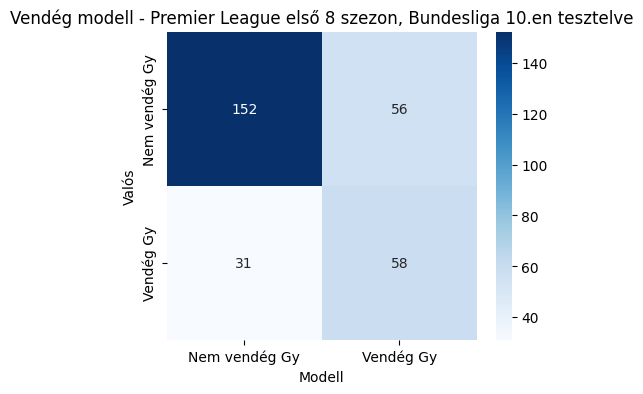

Legjobb küszöbérték a validációs halmazon: 0.20
Summary for HARD VOTING model


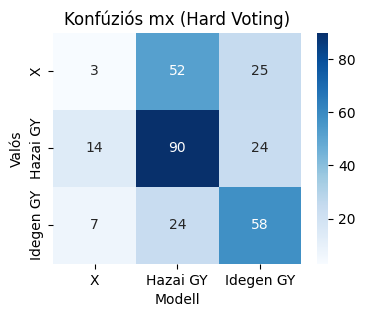

              precision    recall  f1-score   support

           0     0.1250    0.0375    0.0577        80
           1     0.5422    0.7031    0.6122       128
           2     0.5421    0.6517    0.5918        89

    accuracy                         0.5084       297
   macro avg     0.4031    0.4641    0.4206       297
weighted avg     0.4298    0.5084    0.4568       297


Summary for SOFT VOTING model


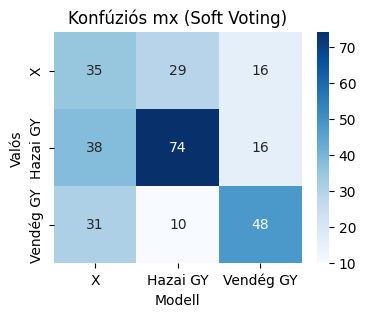

              precision    recall  f1-score   support

           0     0.3365    0.4375    0.3804        80
           1     0.6549    0.5781    0.6141       128
           2     0.6000    0.5393    0.5680        89

    accuracy                         0.5286       297
   macro avg     0.5305    0.5183    0.5209       297
weighted avg     0.5527    0.5286    0.5374       297

ROI hard : -9.41%
ROI soft : 10.51%


In [636]:
pl_dict = {
    'La Liga': la_liga,
    'Ligue 1': ligue_1,
    'Serie A': serie_a,
    'Bundesliga': bundesliga
}

odds = ['prob_HomeW_odds_market', 'prob_AwayW_odds_market', 'prob_Draw_odds_market','prob_U2.5_odds_market', 'prob_O2.5_odds_market']

results_pl = run_logreg_on_dict(
    premier_league,
    pl_dict,
    drop_cols_home,
    drop_cols_away,
    odds,
    premier_league_params_home,
    premier_league_params_away,
    train_name='Premier League'
)

### LaLiga


Futtatás LaLiga → PL
train_set indexek: 0–2957 | forrás: LaLiga
val_set indexek: 2958–3696 | forrás: LaLiga
test_set indexek: 3328–3697 | forrás: PL


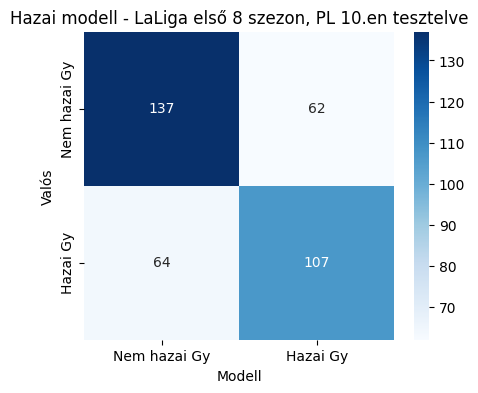

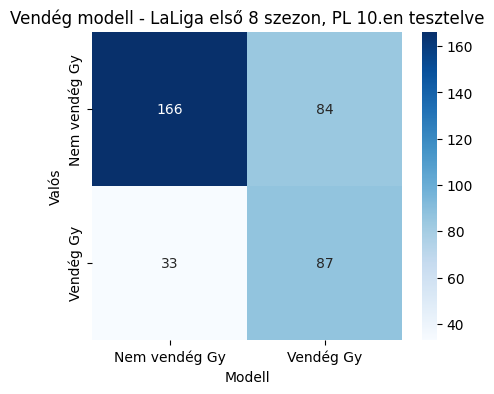

Legjobb küszöbérték a validációs halmazon: 0.16
Summary for HARD VOTING model


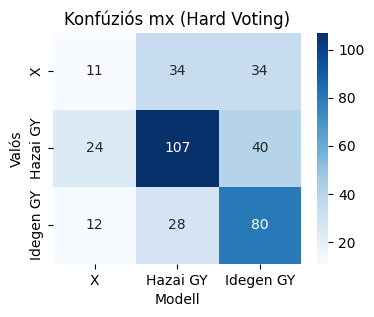

              precision    recall  f1-score   support

           0     0.2340    0.1392    0.1746        79
           1     0.6331    0.6257    0.6294       171
           2     0.5195    0.6667    0.5839       120

    accuracy                         0.5351       370
   macro avg     0.4622    0.4772    0.4627       370
weighted avg     0.5111    0.5351    0.5176       370


Summary for SOFT VOTING model


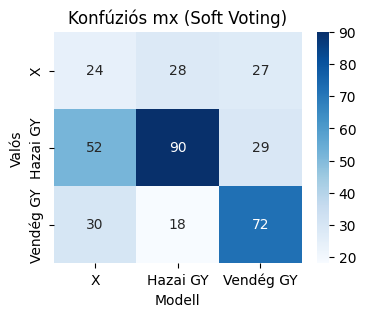

              precision    recall  f1-score   support

           0     0.2264    0.3038    0.2595        79
           1     0.6618    0.5263    0.5863       171
           2     0.5625    0.6000    0.5806       120

    accuracy                         0.5027       370
   macro avg     0.4836    0.4767    0.4755       370
weighted avg     0.5366    0.5027    0.5147       370

ROI hard : -3.69%
ROI soft : -6.97%

Futtatás LaLiga → Ligue 1
train_set indexek: 0–2957 | forrás: LaLiga
val_set indexek: 2958–3696 | forrás: LaLiga
test_set indexek: 3169–3520 | forrás: Ligue 1


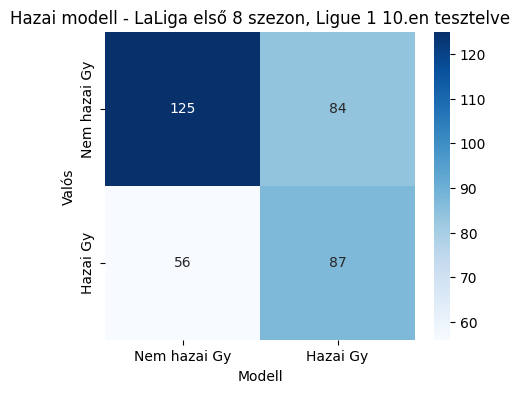

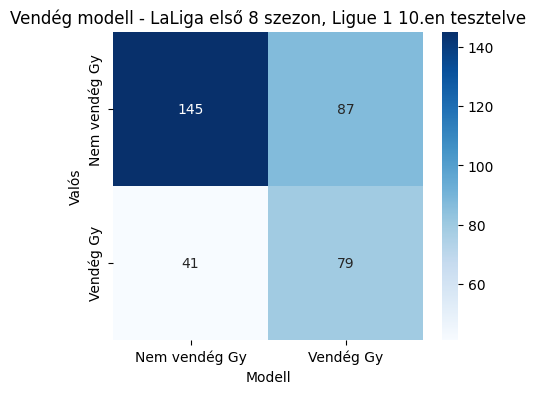

Legjobb küszöbérték a validációs halmazon: 0.16
Summary for HARD VOTING model


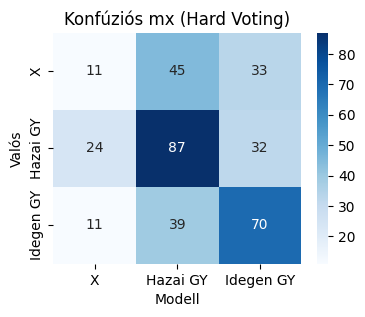

              precision    recall  f1-score   support

           0     0.2391    0.1236    0.1630        89
           1     0.5088    0.6084    0.5541       143
           2     0.5185    0.5833    0.5490       120

    accuracy                         0.4773       352
   macro avg     0.4221    0.4384    0.4220       352
weighted avg     0.4439    0.4773    0.4535       352


Summary for SOFT VOTING model


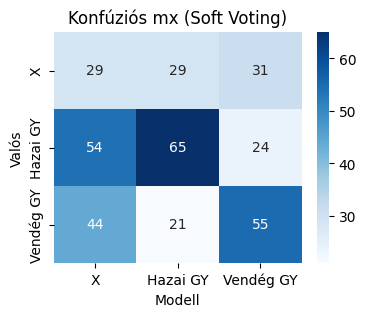

              precision    recall  f1-score   support

           0     0.2283    0.3258    0.2685        89
           1     0.5652    0.4545    0.5039       143
           2     0.5000    0.4583    0.4783       120

    accuracy                         0.4233       352
   macro avg     0.4312    0.4129    0.4169       352
weighted avg     0.4578    0.4233    0.4356       352

ROI hard : -5.57%
ROI soft : -12.51%

Futtatás LaLiga → Serie A
train_set indexek: 0–2957 | forrás: LaLiga
val_set indexek: 2958–3696 | forrás: LaLiga
test_set indexek: 3220–3577 | forrás: Serie A


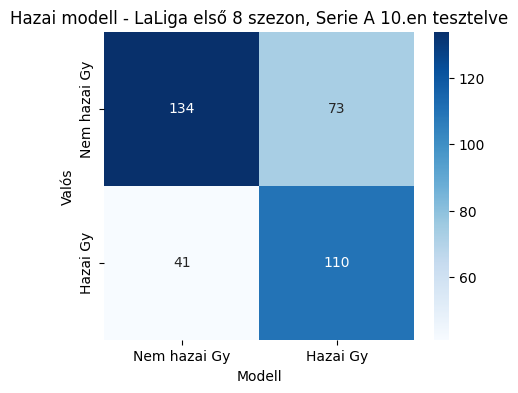

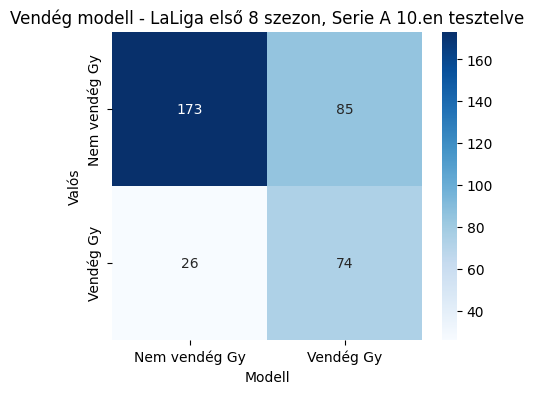

Legjobb küszöbérték a validációs halmazon: 0.16
Summary for HARD VOTING model


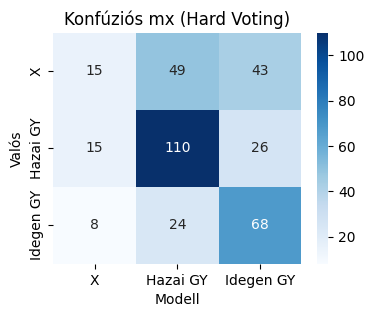

              precision    recall  f1-score   support

           0     0.3947    0.1402    0.2069       107
           1     0.6011    0.7285    0.6587       151
           2     0.4964    0.6800    0.5738       100

    accuracy                         0.5391       358
   macro avg     0.4974    0.5162    0.4798       358
weighted avg     0.5102    0.5391    0.5000       358


Summary for SOFT VOTING model


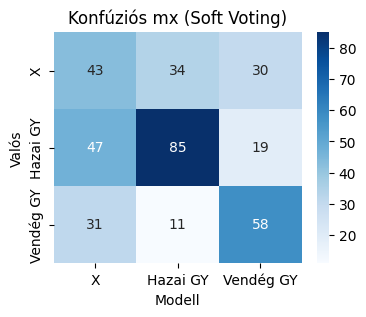

              precision    recall  f1-score   support

           0     0.3554    0.4019    0.3772       107
           1     0.6538    0.5629    0.6050       151
           2     0.5421    0.5800    0.5604       100

    accuracy                         0.5196       358
   macro avg     0.5171    0.5149    0.5142       358
weighted avg     0.5334    0.5196    0.5244       358

ROI hard : 6.12%
ROI soft : 8.18%

Futtatás LaLiga → Bundesliga
train_set indexek: 0–2957 | forrás: LaLiga
val_set indexek: 2958–3696 | forrás: LaLiga
test_set indexek: 2673–2969 | forrás: Bundesliga


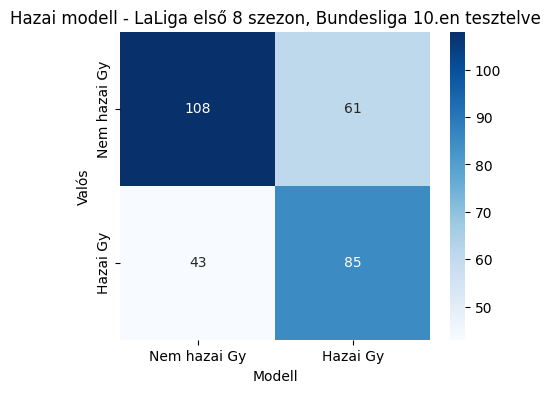

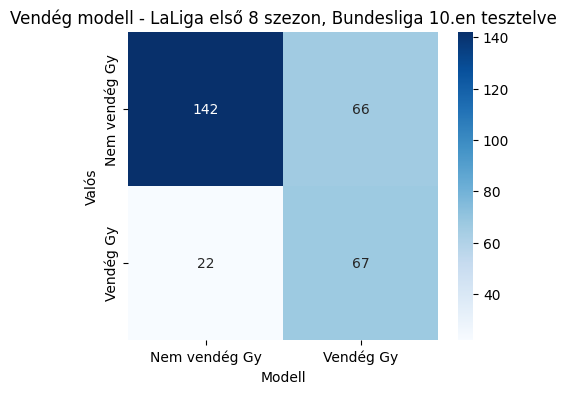

Legjobb küszöbérték a validációs halmazon: 0.16
Summary for HARD VOTING model


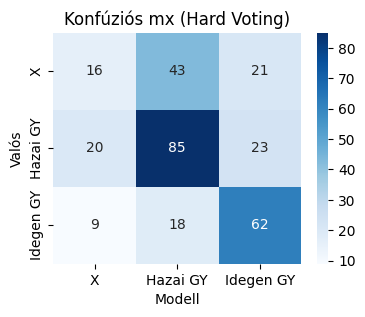

              precision    recall  f1-score   support

           0     0.3556    0.2000    0.2560        80
           1     0.5822    0.6641    0.6204       128
           2     0.5849    0.6966    0.6359        89

    accuracy                         0.5488       297
   macro avg     0.5076    0.5202    0.5041       297
weighted avg     0.5220    0.5488    0.5269       297


Summary for SOFT VOTING model


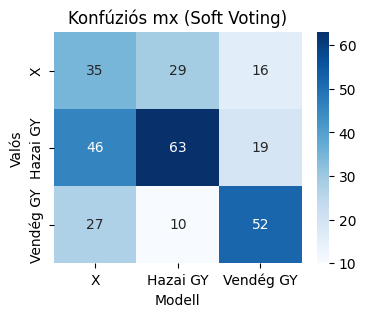

              precision    recall  f1-score   support

           0     0.3241    0.4375    0.3723        80
           1     0.6176    0.4922    0.5478       128
           2     0.5977    0.5843    0.5909        89

    accuracy                         0.5051       297
   macro avg     0.5131    0.5047    0.5037       297
weighted avg     0.5326    0.5051    0.5135       297

ROI hard : 9.42%
ROI soft : 5.48%


In [625]:
laliga_dict = {
    'PL': premier_league,
    'Ligue 1': ligue_1,
    'Serie A': serie_a,
    'Bundesliga': bundesliga
}

results_laliga = logreg_dictionary(
    la_liga,
    laliga_dict,
    drop_cols_home,
    drop_cols_away,
    odds,
    la_liga_params_home,
    la_liga_params_away,
    train_name='LaLiga'
)


### Budnesliga

In [ ]:
bundesliga_dict = {
    'PL': premier_league,
    'Ligue 1': ligue_1,
    'Serie A': serie_a,
    'La Liga': la_liga,
}

results_bundesliga = logreg_dictionary(
    bundesliga,
    bundesliga_dict,
    drop_cols_home,
    drop_cols_away,
    odds,
    bundesliga_params_home,
    bundesliga_params_away,
    train_name='Bundesliga'
)


### Serie A


Futtatás Serie A → PL
train_set indexek: 0–2861 | forrás: Serie A
val_set indexek: 2862–3577 | forrás: Serie A
test_set indexek: 3328–3697 | forrás: PL


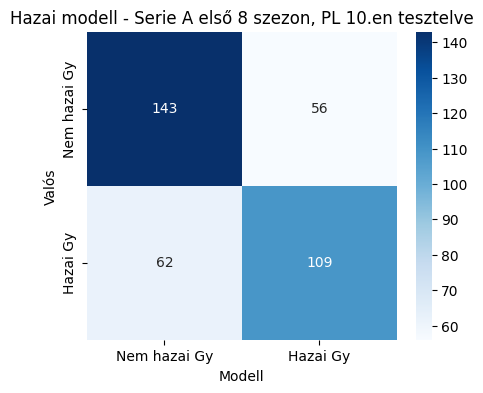

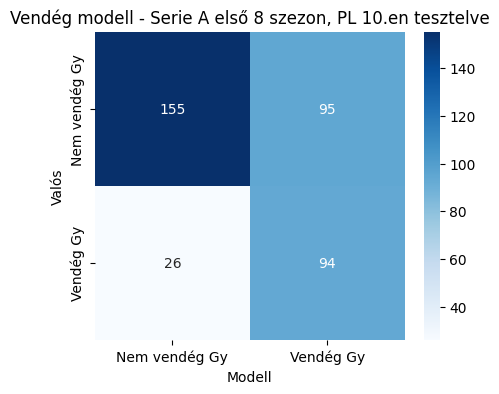

Legjobb küszöbérték a validációs halmazon: 0.19
Summary for HARD VOTING model


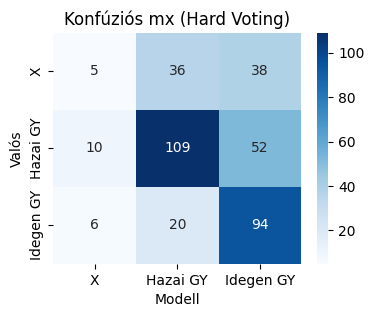

              precision    recall  f1-score   support

           0     0.2381    0.0633    0.1000        79
           1     0.6606    0.6374    0.6488       171
           2     0.5109    0.7833    0.6184       120

    accuracy                         0.5622       370
   macro avg     0.4699    0.4947    0.4557       370
weighted avg     0.5218    0.5622    0.5218       370


Summary for SOFT VOTING model


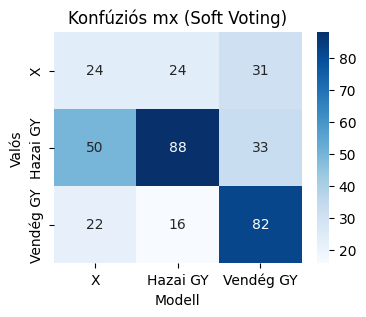

              precision    recall  f1-score   support

           0     0.2500    0.3038    0.2743        79
           1     0.6875    0.5146    0.5886       171
           2     0.5616    0.6833    0.6165       120

    accuracy                         0.5243       370
   macro avg     0.4997    0.5006    0.4932       370
weighted avg     0.5533    0.5243    0.5306       370

ROI hard : 0.05%
ROI soft : -1.71%

Futtatás Serie A → Ligue 1
train_set indexek: 0–2861 | forrás: Serie A
val_set indexek: 2862–3577 | forrás: Serie A
test_set indexek: 3169–3520 | forrás: Ligue 1


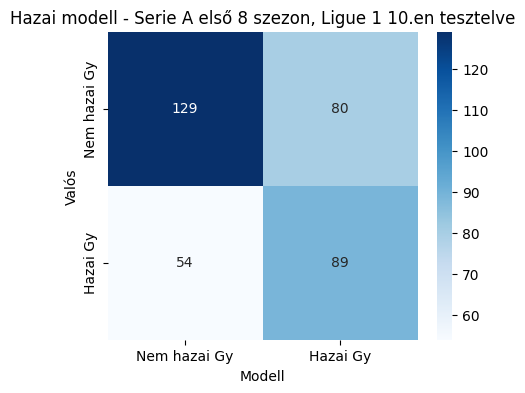

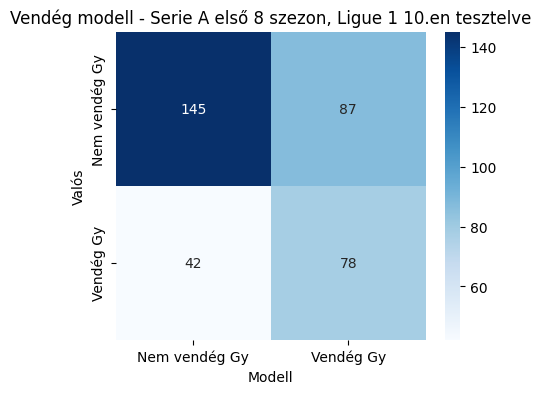

Legjobb küszöbérték a validációs halmazon: 0.19
Summary for HARD VOTING model


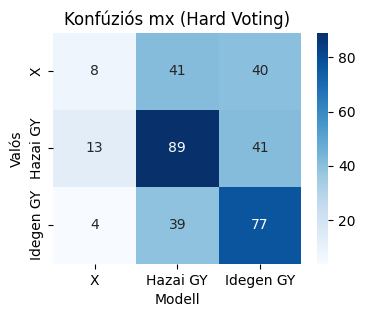

              precision    recall  f1-score   support

           0     0.3200    0.0899    0.1404        89
           1     0.5266    0.6224    0.5705       143
           2     0.4873    0.6417    0.5540       120

    accuracy                         0.4943       352
   macro avg     0.4447    0.4513    0.4216       352
weighted avg     0.4610    0.4943    0.4561       352


Summary for SOFT VOTING model


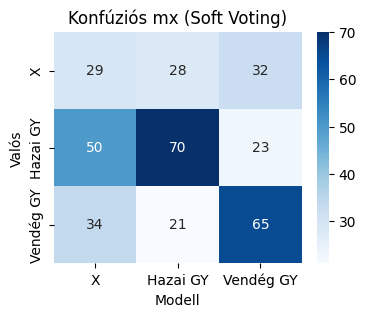

              precision    recall  f1-score   support

           0     0.2566    0.3258    0.2871        89
           1     0.5882    0.4895    0.5344       143
           2     0.5417    0.5417    0.5417       120

    accuracy                         0.4659       352
   macro avg     0.4622    0.4523    0.4544       352
weighted avg     0.4885    0.4659    0.4743       352

ROI hard : -3.73%
ROI soft : -3.54%

Futtatás Serie A → Bundesliga
train_set indexek: 0–2861 | forrás: Serie A
val_set indexek: 2862–3577 | forrás: Serie A
test_set indexek: 2673–2969 | forrás: Bundesliga


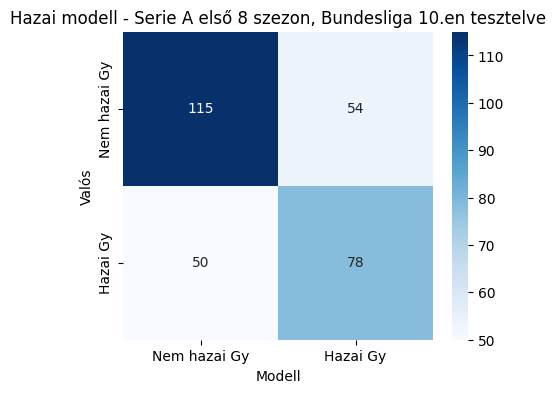

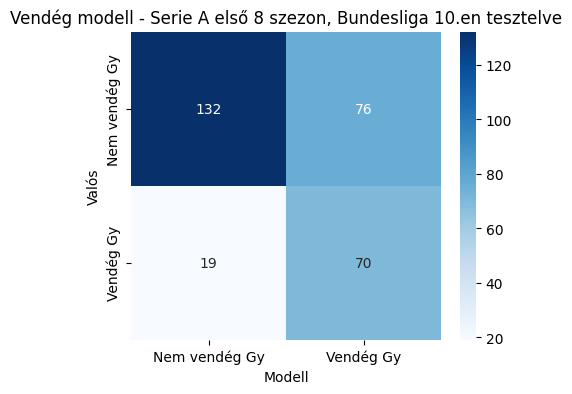

Legjobb küszöbérték a validációs halmazon: 0.19
Summary for HARD VOTING model


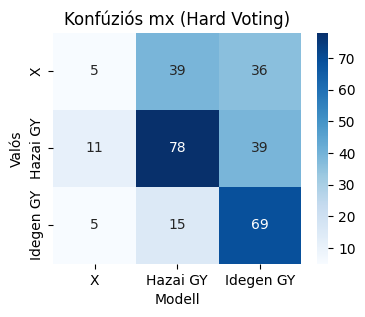

              precision    recall  f1-score   support

           0     0.2381    0.0625    0.0990        80
           1     0.5909    0.6094    0.6000       128
           2     0.4792    0.7753    0.5923        89

    accuracy                         0.5118       297
   macro avg     0.4361    0.4824    0.4304       297
weighted avg     0.4624    0.5118    0.4627       297


Summary for SOFT VOTING model


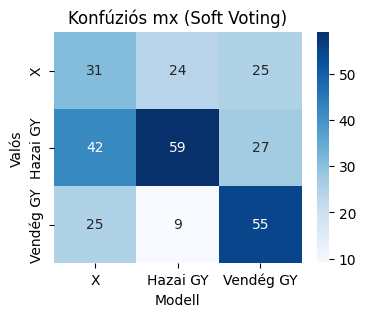

              precision    recall  f1-score   support

           0     0.3163    0.3875    0.3483        80
           1     0.6413    0.4609    0.5364       128
           2     0.5140    0.6180    0.5612        89

    accuracy                         0.4882       297
   macro avg     0.4905    0.4888    0.4820       297
weighted avg     0.5156    0.4882    0.4932       297

ROI hard : -5.68%
ROI soft : 0.73%

Futtatás Serie A → La Liga
train_set indexek: 0–2861 | forrás: Serie A
val_set indexek: 2862–3577 | forrás: Serie A
test_set indexek: 3327–3696 | forrás: La Liga


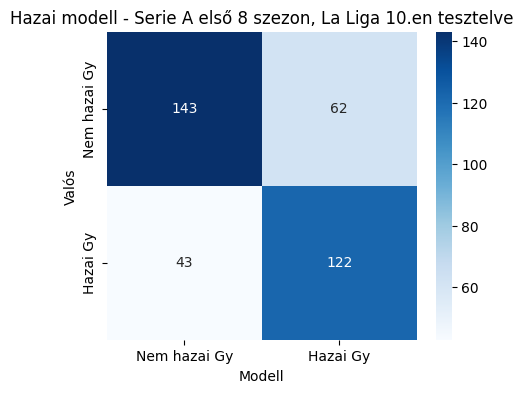

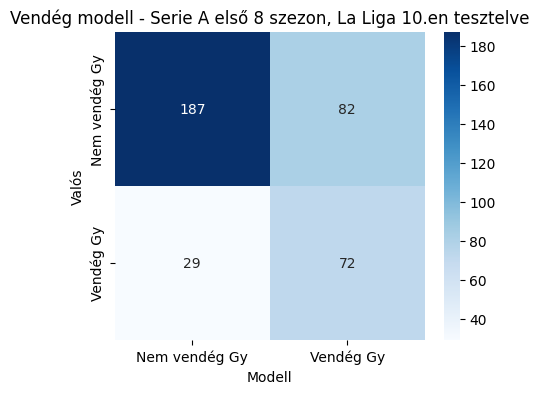

Legjobb küszöbérték a validációs halmazon: 0.19
Summary for HARD VOTING model


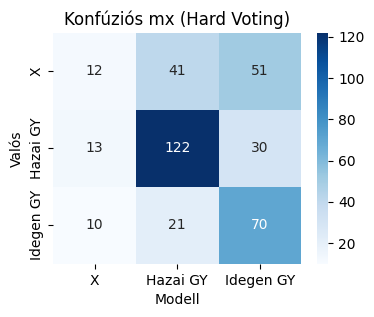

              precision    recall  f1-score   support

           0     0.3429    0.1154    0.1727       104
           1     0.6630    0.7394    0.6991       165
           2     0.4636    0.6931    0.5556       101

    accuracy                         0.5514       370
   macro avg     0.4898    0.5159    0.4758       370
weighted avg     0.5186    0.5514    0.5120       370


Summary for SOFT VOTING model


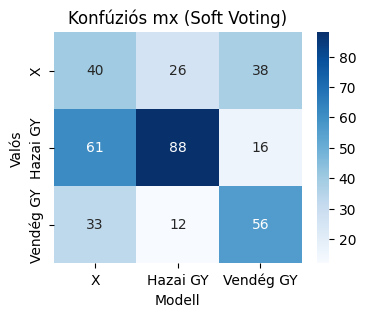

              precision    recall  f1-score   support

           0     0.2985    0.3846    0.3361       104
           1     0.6984    0.5333    0.6048       165
           2     0.5091    0.5545    0.5308       101

    accuracy                         0.4973       370
   macro avg     0.5020    0.4908    0.4906       370
weighted avg     0.5343    0.4973    0.5091       370

ROI hard : 7.21%
ROI soft : 3.68%


In [632]:
serie_a_dict = {
    'PL': premier_league,
    'Ligue 1': ligue_1,
    'Bundesliga': bundesliga,
    'La Liga': la_liga
}

results_seriea = logreg_dictionary(
    serie_a,
    serie_a_dict,
    drop_cols_home,
    drop_cols_away,
    odds,
    serie_a_params_home,
    serie_a_params_away,
    train_name='Serie A'
)


### Ligue 1


Futtatás Ligue 1 → PL
train_set indexek: 0–2816 | forrás: Ligue 1
val_set indexek: 2817–3520 | forrás: Ligue 1
test_set indexek: 3328–3697 | forrás: PL


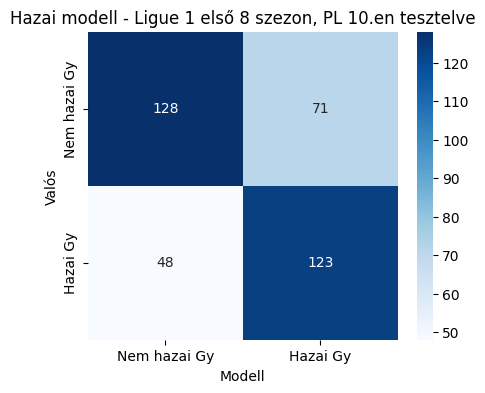

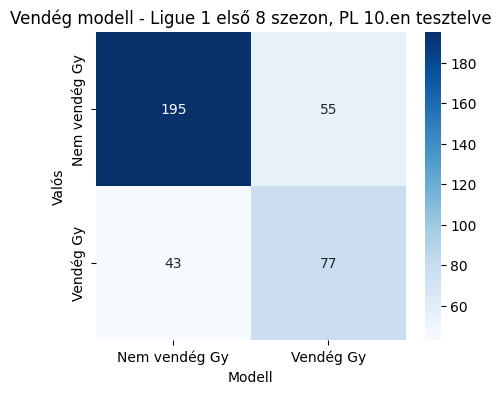

Legjobb küszöbérték a validációs halmazon: 0.20
Summary for HARD VOTING model


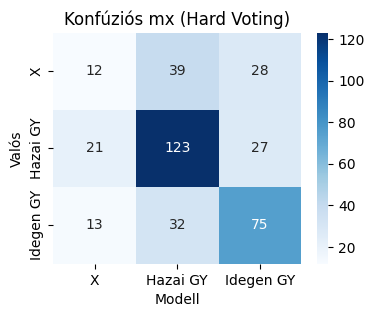

              precision    recall  f1-score   support

           0     0.2609    0.1519    0.1920        79
           1     0.6340    0.7193    0.6740       171
           2     0.5769    0.6250    0.6000       120

    accuracy                         0.5676       370
   macro avg     0.4906    0.4987    0.4887       370
weighted avg     0.5358    0.5676    0.5471       370


Summary for SOFT VOTING model


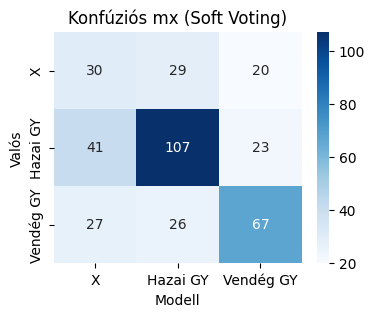

              precision    recall  f1-score   support

           0     0.3061    0.3797    0.3390        79
           1     0.6605    0.6257    0.6426       171
           2     0.6091    0.5583    0.5826       120

    accuracy                         0.5514       370
   macro avg     0.5252    0.5213    0.5214       370
weighted avg     0.5682    0.5514    0.5583       370

ROI hard : 1.58%
ROI soft : 4.94%

Futtatás Ligue 1 → Serie A
train_set indexek: 0–2816 | forrás: Ligue 1
val_set indexek: 2817–3520 | forrás: Ligue 1
test_set indexek: 3220–3577 | forrás: Serie A


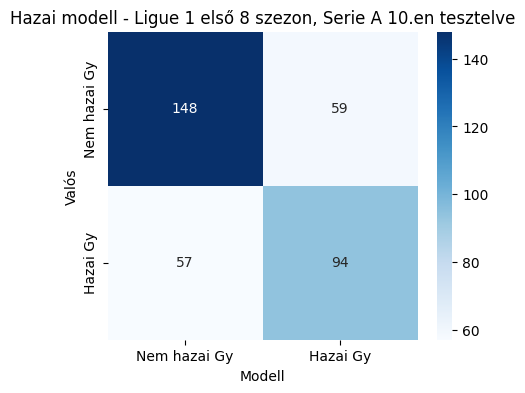

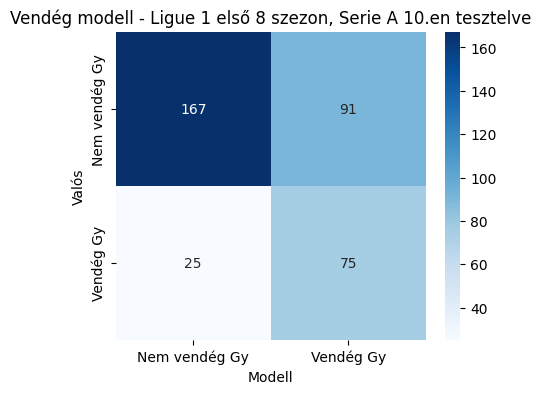

Legjobb küszöbérték a validációs halmazon: 0.20
Summary for HARD VOTING model


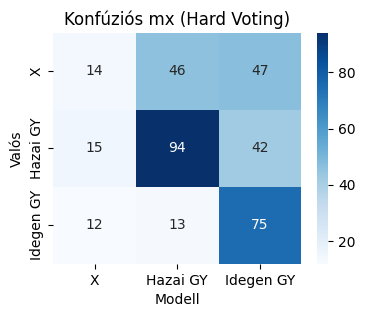

              precision    recall  f1-score   support

           0     0.3415    0.1308    0.1892       107
           1     0.6144    0.6225    0.6184       151
           2     0.4573    0.7500    0.5682       100

    accuracy                         0.5112       358
   macro avg     0.4711    0.5011    0.4586       358
weighted avg     0.4889    0.5112    0.4761       358


Summary for SOFT VOTING model


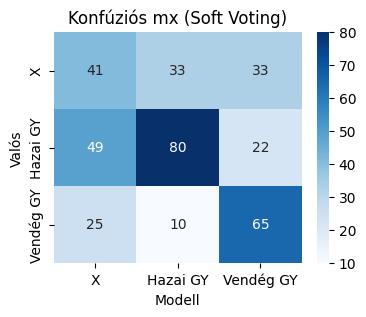

              precision    recall  f1-score   support

           0     0.3565    0.3832    0.3694       107
           1     0.6504    0.5298    0.5839       151
           2     0.5417    0.6500    0.5909       100

    accuracy                         0.5196       358
   macro avg     0.5162    0.5210    0.5147       358
weighted avg     0.5322    0.5196    0.5218       358

ROI hard : -0.69%
ROI soft : 8.76%

Futtatás Ligue 1 → Bundesliga
train_set indexek: 0–2816 | forrás: Ligue 1
val_set indexek: 2817–3520 | forrás: Ligue 1
test_set indexek: 2673–2969 | forrás: Bundesliga


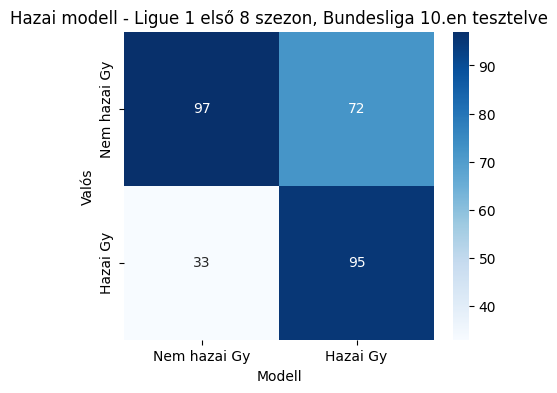

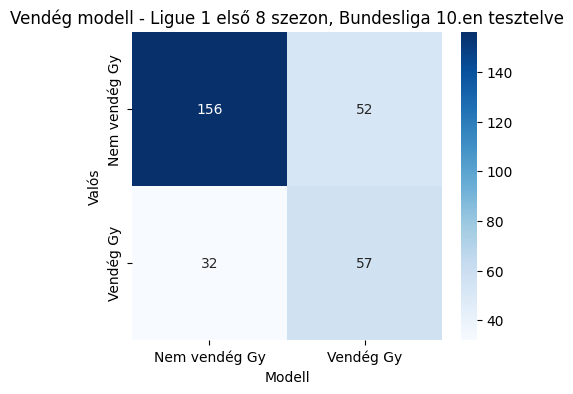

Legjobb küszöbérték a validációs halmazon: 0.20
Summary for HARD VOTING model


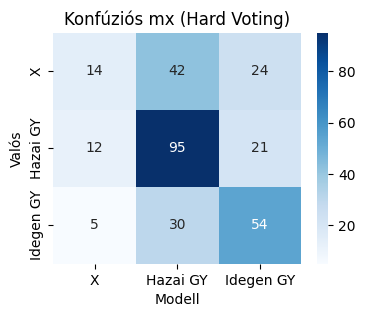

              precision    recall  f1-score   support

           0     0.4516    0.1750    0.2523        80
           1     0.5689    0.7422    0.6441       128
           2     0.5455    0.6067    0.5745        89

    accuracy                         0.5488       297
   macro avg     0.5220    0.5080    0.4903       297
weighted avg     0.5303    0.5488    0.5177       297


Summary for SOFT VOTING model


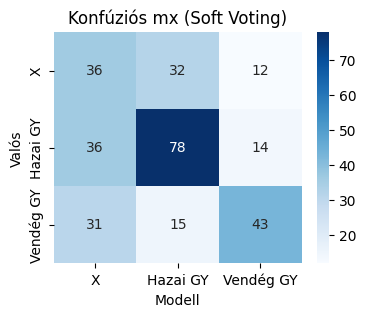

              precision    recall  f1-score   support

           0     0.3495    0.4500    0.3934        80
           1     0.6240    0.6094    0.6166       128
           2     0.6232    0.4831    0.5443        89

    accuracy                         0.5286       297
   macro avg     0.5322    0.5142    0.5181       297
weighted avg     0.5498    0.5286    0.5348       297

ROI hard : 4.40%
ROI soft : 9.42%

Futtatás Ligue 1 → La Liga
train_set indexek: 0–2816 | forrás: Ligue 1
val_set indexek: 2817–3520 | forrás: Ligue 1
test_set indexek: 3327–3696 | forrás: La Liga


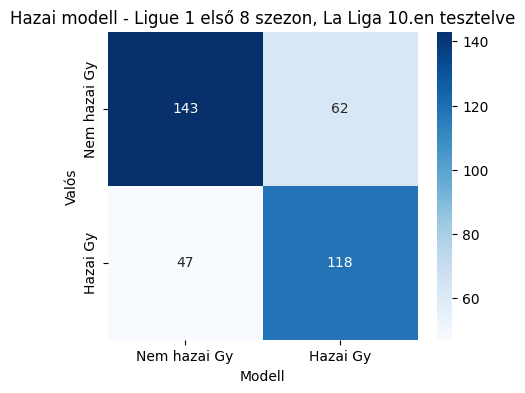

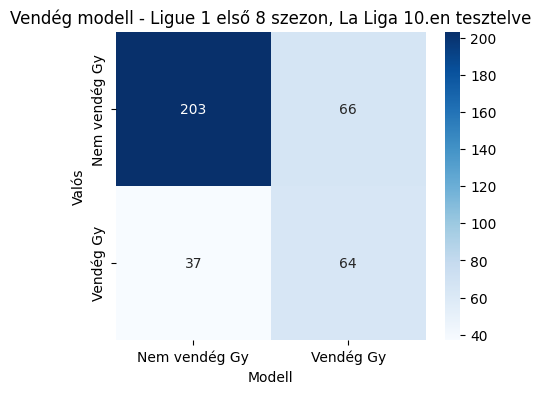

Legjobb küszöbérték a validációs halmazon: 0.20
Summary for HARD VOTING model


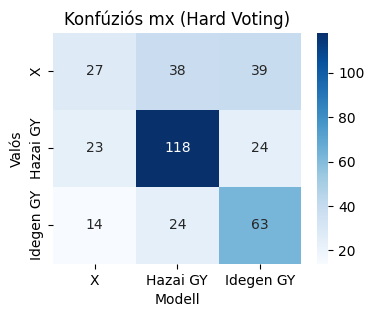

              precision    recall  f1-score   support

           0     0.4219    0.2596    0.3214       104
           1     0.6556    0.7152    0.6841       165
           2     0.5000    0.6238    0.5551       101

    accuracy                         0.5622       370
   macro avg     0.5258    0.5328    0.5202       370
weighted avg     0.5474    0.5622    0.5469       370


Summary for SOFT VOTING model


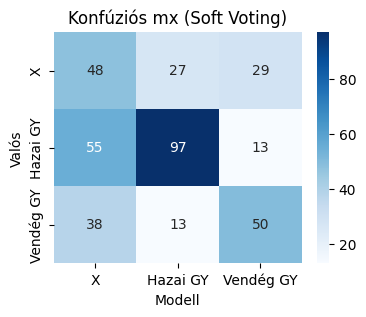

              precision    recall  f1-score   support

           0     0.3404    0.4615    0.3918       104
           1     0.7080    0.5879    0.6424       165
           2     0.5435    0.4950    0.5181       101

    accuracy                         0.5270       370
   macro avg     0.5306    0.5148    0.5175       370
weighted avg     0.5598    0.5270    0.5380       370

ROI hard : 13.05%
ROI soft : 11.91%


In [631]:
ligue1_dict = {
    'PL': premier_league,
    'Serie A': serie_a,
    'Bundesliga': bundesliga,
    'La Liga': la_liga
}

results_ligue1 = logreg_dictionary(
    ligue_1,
    ligue1_dict,
    drop_cols_home,
    drop_cols_away,
    odds,
    ligue_1_params_home,
    ligue_1_params_away,
    train_name='Ligue 1'
)
